# Project 2: Advanced Lane Finding
Software pipeline to identify the lane boundaries effectively and robustly
Goals:
---
* Camera calibration matrix and distortion coefficients from chessboard images
* Processing images: apply distortion correction to raw images; apply perspective transform (birds-eye view); color, gradient transforms
* Detect lane pixels and fitting (histogram, sliding windows and polynomial fitting)
* Detect lane pixels using prior fitting coefficients
* Determine the curvature of the lane and the vehicle position with respect to center
* Warp the detected lane boundaries back onto the original image and display output along with numerical estimation of lane curvature and vehicle position

---
Need to check:
* Perspective transform
* Conversion from pixel space to world space
* Radius of curvature

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline
# %matplotlib qt

In [2]:
# Test images
test_img_list = os.listdir("test_images/")
test_img_list = [t for t in test_img_list if not t.startswith('.')]
test_img_list = [x[0]+x[1] for x in zip(['test_images/']*len(test_img_list), test_img_list)]
print(test_img_list)

['test_images/test6.jpg', 'test_images/straight_lines1.jpg', 'test_images/test4.jpg', 'test_images/test3.jpg', 'test_images/test5.jpg', 'test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/straight_lines2.jpg']


# Camera Calibration
---

In [3]:
# 9-by-6 chessboard

# Function to calibrate camera --- need to run only ONCE
# return calibration matrix (mtx) and distortion coefficients (dist) for later usage to undistort images
def calibrateCam(cam_images):
    # Object points (3D) and Image points (2D)
    obj_pts = [] # 3D points in real worl space
    img_pts = [] # 2D points in image plane

    # Prepare object points {(0,0,0), (1,0,0), ... (8,5,0)}
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    for cam in cam_images:
        cam_img = mpimg.imread(cam)

        # Image points: find corners of the chessboard
        gray = cv2.cvtColor(cam_img, cv2.COLOR_RGB2GRAY)   # convert to gray scale
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # if detected corners...
        if ret:
            img_pts.append(corners)
            obj_pts.append(objp)

            # draw and display corners
            #corner_img = cv2.drawChessboardCorners(cam_img, (9,6), corners, ret)
            #plt.imshow(corner_img)
            #plt.title(cam)

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, gray.shape[::-1], None, None)
    
    return mtx, dist

cam_images = glob.glob('camera_cal/calibration*.jpg')
mtx, dist = calibrateCam(cam_images)

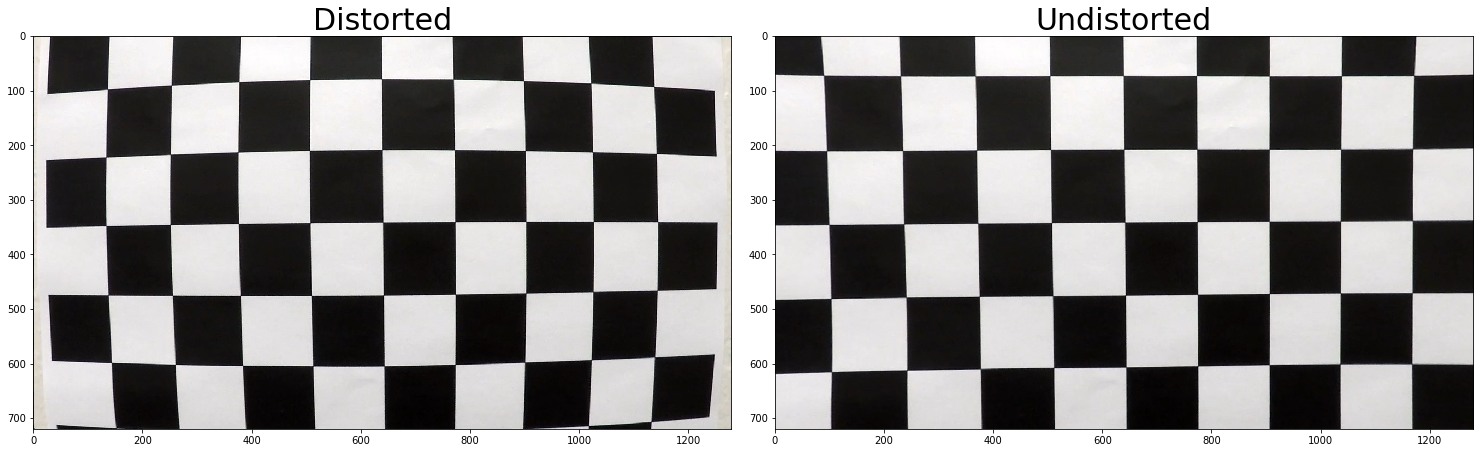

In [4]:
# Applying Camera Calibration
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Distorted', fontsize=30)
ax1.imshow(img)
ax2.set_title('Undistorted', fontsize=30)
ax2.imshow(undistorted, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Processing images
---
Distortion correction, color-gradient threshold, perspective transform

In [5]:
# OPTIONAL: Canny edge after perspective transform
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

In [5]:
# --------------- HELPER FUNCTIONS FOR PROCESSING IMAGES ---------------

# Gradient threshold (Sobel x)
def gradient_threshold(img, orient='x', sobel_kernel=3, thresh=(15, 100)):   
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        grad = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        grad = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    grad = np.absolute(grad)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled = (grad*255/np.max(grad)).astype(np.uint8)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    mask = np.zeros_like(scaled)
    mask[(scaled>=thresh[0]) & (scaled<=thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    binary_output = mask
   
    return binary_output
# -----------------------------------------------------------------------

# HLS threshold (convert from RGB to HLS color space)
# Can detect both YELLOW AND WHITE
def hls_threshold(img, thresh_S=(100,255), thresh_H=(15,50), thresh_L=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H, L, S = hls[:,:,0], hls[:,:,1], hls[:,:,2]
    
    binary_S = np.zeros_like(S)
    binary_S[(S>thresh_S[0]) & (S<=thresh_S[1])] = 1
    
    binary_H = np.zeros_like(H)
    binary_H[(H>thresh_H[0]) & (H<=thresh_H[1])] = 1
    
    binary_L = np.zeros_like(L)
    binary_L[((L>thresh_L[0]) & (L<=thresh_L[1]))] = 1
    
    binary_output = binary_S & binary_H
#     binary_output = binary_H
    
    # Return binary_S for detecting lines
    # binary_H for supporting gradient threshold
    return binary_output, binary_H

# HSV threshold
# Hue is in range [0,179], Saturation and Value are both in range [0,255]
# Used for detecting YELLOW only
def hsv_threshold(img, thresh_S=(100,255), thresh_H=(13,30), thresh_V=(100,255)):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    H, S, V = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

    binary_S = np.zeros_like(S)
    binary_S[(S>thresh_S[0]) & (S<=thresh_S[1])] = 1
    
    binary_H = np.zeros_like(H)
    binary_H[(H>thresh_H[0]) & (H<=thresh_H[1])] = 1
    
    binary_V = np.zeros_like(V)
    binary_V[((V>thresh_V[0]) & (V<=thresh_V[1]))] = 1
    
    binary_output = binary_S & binary_H
#     binary_output = H
    
    return binary_output

# Used for detecting WHITE only
def RGB_threshold(img, thresh_R=(200,255), thresh_G=(200,255), thresh_B=(200,255)):
    lower_thresh = np.array([thresh_R[0],thresh_G[0],thresh_B[0]])
    higher_thresh = np.array([thresh_R[1],thresh_G[1],thresh_B[1]])
    mask = cv2.inRange(img, lower_thresh, higher_thresh)
#     R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    
#     binary_R = np.zeros_like(R)
#     binary_R[(R>thresh_R[0]) & (R<=thresh_R[1])] = 1
    
#     binary_G = np.zeros_like(G)
#     binary_G[(G>thresh_G[0]) & (G<=thresh_G[1])] = 1
    
#     binary_B = np.zeros_like(B)
#     binary_G[(B>thresh_B[0]) & (B<=thresh_B[1])] = 1
    
    binary_output = np.zeros_like(img[:,:,0])
    binary_output[(mask==255)] = 1

    return binary_output
# -----------------------------------------------------------------------

# Combine gradient and color thresholds
def gradient_color_threshold(img, isColor=False):
    img = np.copy(img)
    grad_binary = gradient_threshold(img, orient='x')
    hls_binary, binary_H = hls_threshold(img)
    hsv_binary = hsv_threshold(img)
    rgb_binary = RGB_threshold(img)
    
    if isColor:
        pipeline_img = np.dstack((np.zeros_like(hls_binary), grad_binary, hls_binary)) * 255
    else:
        pipeline_img = np.zeros_like(grad_binary)
        pipeline_img[((grad_binary==1) & (binary_H==1)) | (hls_binary==1) | (hsv_binary==1) | (rgb_binary==1)] = 1
#         pipeline_img[(hsv_binary==1) | (rgb_binary==1)] = 1
    
    return pipeline_img
# -----------------------------------------------------------------------

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)
# -----------------------------------------------------------------------

def processing_img(img):
    img_size = img.shape
    
    # Step 0: Distortion correction
    test_img_undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Step 1: Color-gradient threshold
    color_grad_thresh_img = gradient_color_threshold(test_img_undistorted, isColor=False)
#     color_grad_thresh_img, binary_H = hls_threshold(test_img_undistorted)
#     color_grad_thresh_img = hsv_threshold(test_img_undistorted)
#     color_grad_thresh_img = gradient_threshold(test_img_undistorted, orient='x', thresh=(15,100))
#     color_grad_thresh_img = RGB_threshold(test_img_undistorted)
    
    # Step 2: Perspective transform (bird-eye view)
    # Top-left -> top-right -> bottom-right -> bottom-left (clock-wise)
    #src = np.float32([[(598,452), (694,452), (1135,720), (196,720)]])
    #dst = np.float32([[(322,0), (958,0), (958,720), (322,720)]])
    src = np.float32(
        [[(img_size[1] / 2) - 55, img_size[0] / 2 + 100],
        [((img_size[1] / 6) - 10), img_size[0]],
        [(img_size[1] * 5 / 6) + 60, img_size[0]],
        [(img_size[1] / 2 + 55), img_size[0] / 2 + 100]])
    dst = np.float32(
        [[(img_size[1] / 4), 0],
        [(img_size[1] / 4), img_size[0]],
        [(img_size[1] * 3 / 4), img_size[0]],
        [(img_size[1] * 3 / 4), 0]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    warped_img = cv2.warpPerspective(color_grad_thresh_img, M, (img_size[1],img_size[0]), flags=cv2.INTER_LINEAR)
    #test_img_undistorted = cv2.polylines(test_img_undistorted, [np.int32(src)], True, color=[255,0,0], thickness=6)
    #warped_img = cv2.polylines(warped_img, [np.int32(dst)], True, color=[255,0,0], thickness=6)
    
    # Step 3: Output image
    output_img = warped_img

# #     # Try Canny
#     gray = grayscale(warped_img)
#     blur = gaussian_blur(gray, kernel_size=3)
#     edges = canny(gray, low_threshold=10, high_threshold=20)
#     output_img = edges
    
    return output_img, color_grad_thresh_img, test_img_undistorted, M_inv

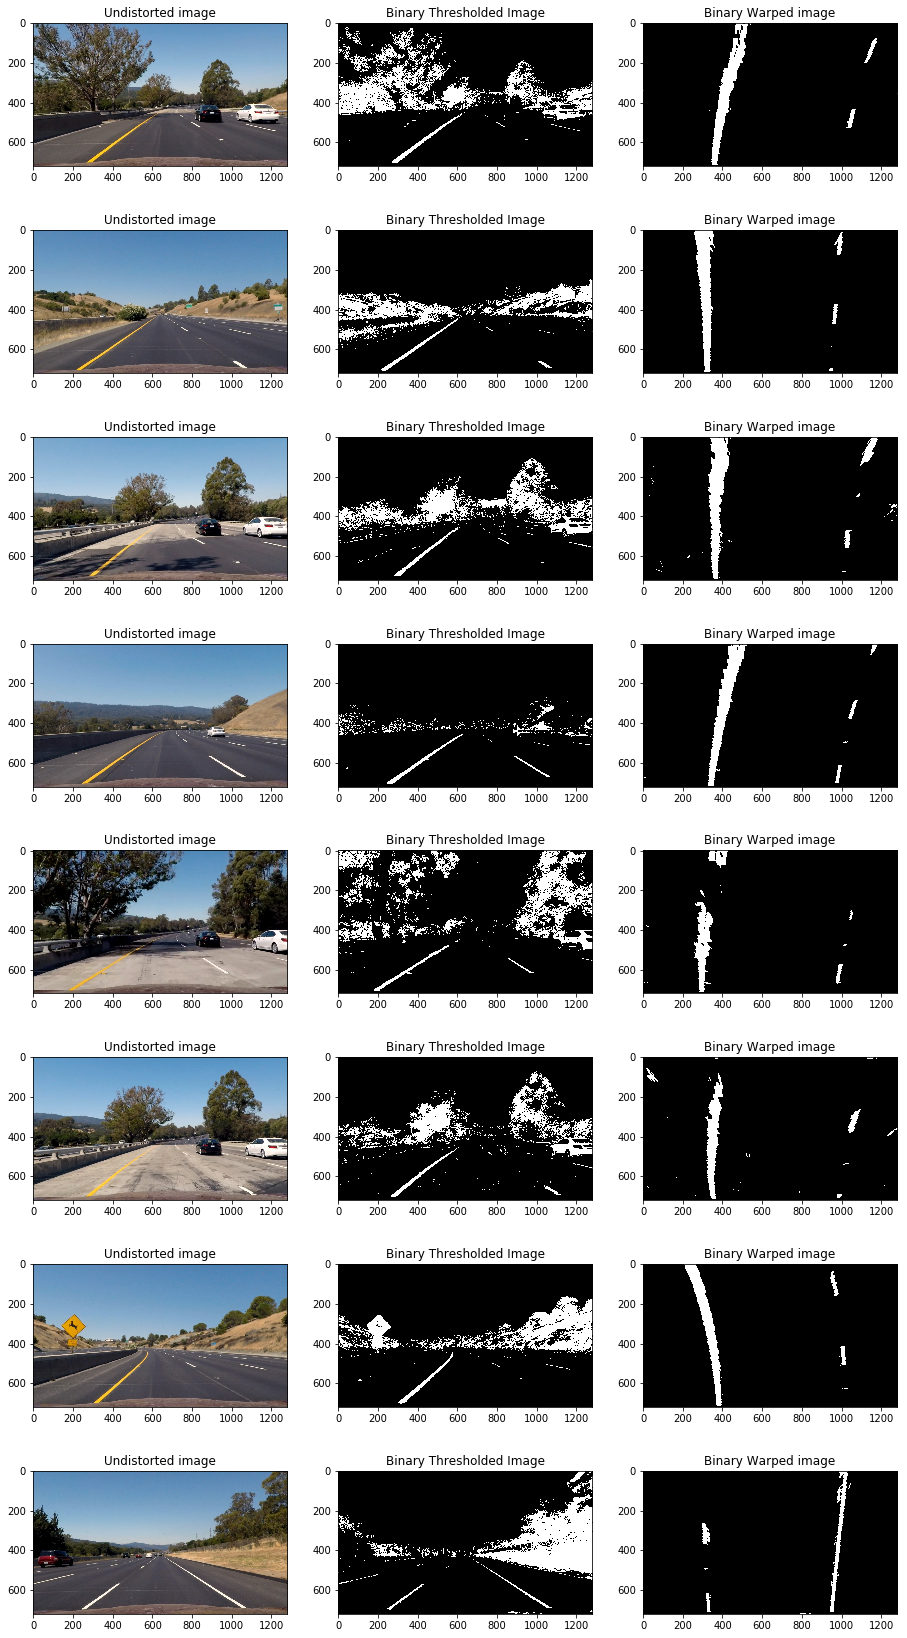

In [6]:
fig = plt.figure(figsize=(12,25))
fig.tight_layout()
fig.add_axes()

for idx, test_img in enumerate(test_img_list):
    test_img = mpimg.imread(test_img)
#     test_img = check_img
    output_img, color_binary, test_img_undistorted, M_inv = processing_img(test_img)
    
    # Display images
    ax0 = fig.add_subplot(len(test_img_list), 3, 3*idx+1)
    ax0.imshow(test_img_undistorted, cmap='gray')
    ax0.set_title('Undistorted image')
    
    ax1 = fig.add_subplot(len(test_img_list), 3, 3*idx+2)
    ax1.imshow(color_binary, cmap='gray')
    ax1.set_title('Binary Thresholded Image')
    
    ax2 = fig.add_subplot(len(test_img_list), 3, 3*idx+3)
    ax2.imshow(output_img, cmap='gray')
    ax2.set_title('Binary Warped image')
#     break

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Lane Finding & Calculating Curvature and Vehicle Position
---
* Detect lane using Histogram and polynomial fitting
* Compute the radius of curvature of the fit

In [32]:
# Tracking and Sanity Check

# Define a class to receive characteristics of each line detection
class Line():
    def __init__(self):
        # is this the first frame?
        self.isFirstFrame = True
        
        # Smoothing over n iterations
        self.n = 3
        
        # was the line detected in the last iteration?
        self.detected = False
        
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None
        
        #polynomial coefficients averaged over the last n iterations
        self.left_best_fit = None
        self.right_best_fit = None
        self.left_best_fit_realworld = None
        self.right_best_fit_realworld = None
        
        #polynomial coefficients for the most recent fit
        self.left_current_fit = []          # coefficients
        self.left_current_fit_obj = []      # object of coefficients
        self.right_current_fit = []          # coefficients
        self.right_current_fit_obj = []      # object of coefficients
        self.left_current_fit_realworld = []    #  coefficients in real world (meter)
        self.right_current_fit_realworld = []
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        # maximum number of bad frames before re-sliding window
        self.thresh_frame = 5
        # number of bad frames 
        self.bad_frame = 0
        
    def increment_bad_frame(self):
        self.bad_frame += 1
        
    def isNeedSliding(self):
        # check if needed to slide window again as bad_frame >= thresh_frame
        status = True if self.bad_frame>=self.thresh_frame else False
        if status:
            # Reset number of bad_frame if status==True (will re-slide window next frame)
            self.bad_frame = 0
        return status
    
    def turn_off_line_detected(self):
        self.detected = False
        
    def turn_on_line_detected(self):
        self.detected = True
        
    def line_detect_status(self):
        return self.detected
    
    def update_fit(self, left_fit, right_fit, left_fit_realworld, right_fit_realworld):
        # store the latest fit coefficients
        self.left_current_fit.append(left_fit)
        self.left_current_fit_obj.append(np.poly1d(left_fit))
        self.right_current_fit.append(right_fit)
        self.right_current_fit_obj.append(np.poly1d(right_fit))
        
        self.left_current_fit_realworld.append(left_fit_realworld)
        self.right_current_fit_realworld.append(right_fit_realworld)
        
        # remove the previous fit coefficients
        if (len(self.left_current_fit_obj) > 1) or ((len(self.right_current_fit_obj) > 1)):
            del self.left_current_fit_obj[0]
            del self.right_current_fit_obj[0]
            
        self.smooth_fit_coeff()
        
    def compare_fit_coefficients(self, left_new_coeffs, right_new_coeffs):
        delta_coeff_0 = 0.001
        delta_coeff_1 = 0.4
        delta_coeff_2 = 150
#         if ((np.absolute(self.left_current_fit[-1][0]-left_new_coeffs[0])>=delta_coeff_0) or
#             (np.absolute(self.left_current_fit[-1][1]-left_new_coeffs[1])>=delta_coeff_1) or 
#             (np.absolute(self.left_current_fit[-1][2]-left_new_coeffs[2])>=delta_coeff_2) or
#             (np.absolute(self.right_current_fit[-1][0]-right_new_coeffs[0])>=delta_coeff_0) or
#             (np.absolute(self.right_current_fit[-1][1]-right_new_coeffs[1])>=delta_coeff_1) or 
#             (np.absolute(self.right_current_fit[-1][2]-right_new_coeffs[2])>=delta_coeff_2)):
        if ((np.absolute(self.left_best_fit[0]-left_new_coeffs[0])>=delta_coeff_0) or
            (np.absolute(self.left_best_fit[1]-left_new_coeffs[1])>=delta_coeff_1) or 
            (np.absolute(self.left_best_fit[2]-left_new_coeffs[2])>=delta_coeff_2) or
            (np.absolute(self.right_best_fit[0]-right_new_coeffs[0])>=delta_coeff_0) or
            (np.absolute(self.right_best_fit[1]-right_new_coeffs[1])>=delta_coeff_1) or 
            (np.absolute(self.right_best_fit[2]-right_new_coeffs[2])>=delta_coeff_2)):
            # consider as bad frame
            return True
        else:
            return False
        
    def smooth_fit_coeff(self):
        if (len(self.left_current_fit) == self.n):
            print('......smoothing......')
            left_temp = np.stack(self.left_current_fit)
            self.left_best_fit = np.average(left_temp, axis=0)
            right_temp = np.stack(self.right_current_fit)
            self.right_best_fit = np.average(right_temp, axis=0)
            
            left_temp_realworld = np.stack(self.left_current_fit_realworld)
            self.left_best_fit_realworld = np.average(left_temp_realworld, axis=0)
            right_temp_realworld = np.stack(self.right_current_fit_realworld)
            self.right_best_fit_realworld = np.average(right_temp_realworld, axis=0)
            
            # reset current_fit list
            del self.left_current_fit[:]
            del self.right_current_fit[:]
            del self.left_current_fit_realworld[:]
            del self.right_current_fit_realworld[:]
            
    def get_best_fit_obj(self, left=False, right=False):
        if left:
            return np.poly1d(self.left_best_fit)
        elif right:
            return np.poly1d(self.right_best_fit)

In [33]:
# --------------- HELPER FUNCTIONS FOR FINDING LANES ---------------

def find_lane_pixels(binary_warped, xm_per_pix, ym_per_pix, nwindows=9, margin=100, minpix=20, isDebugging=False):
    """
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30
    """
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print('Distance between 2 lanes: ',rightx_base-leftx_base)    # in pixel
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])    # row of matrix = y-axis of image (vertical)
    nonzerox = np.array(nonzero[1])    # col of matrix = x-axis of image (horizontal)
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height    # i.e. for window=0, win_y_low=720-window_height
        win_y_high = binary_warped.shape[0] - window*window_height       # i.e. for window=0, win_y_high=720
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        if isDebugging:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
            (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
            (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        #good_left_inds = binary_warped[win_y_low:win_y_high, win_xleft_low:win_xleft_high].nonzero()[0]
        #good_right_inds = binary_warped[win_y_low:win_y_high, win_xright_low:win_xright_high].nonzero()[0]
        good_left_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xleft_low) 
                          & (nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low) & (nonzeroy<win_y_high) & (nonzerox>=win_xright_low)
                          & (nonzerox<win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if (len(good_left_inds) > minpix):
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if (len(good_right_inds) > minpix):
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    try:
        # Update fit coefficients and objects
        left_fit = np.polyfit(lefty, leftx, deg=2)
        right_fit = np.polyfit(righty, rightx, deg=2)
        left_fit_realworld = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
        right_fit_realworld = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)
        
        line_class.update_fit(left_fit, right_fit, left_fit_realworld, right_fit_realworld)
#         line_class.smooth_fit_coeff()    # update best_fit after every n iterations
        if line_class.isFirstFrame:
            line_class.isFirstFrame = False
            line_class.left_best_fit = left_fit
            line_class.right_best_fit = right_fit
            line_class.left_best_fit_realworld = left_fit_realworld
            line_class.right_best_fit_realworld = right_fit_realworld
        else:
            if ((640-200)<(rightx_base-leftx_base)<(640+200)) and (not line_class.compare_fit_coefficients(left_fit, right_fit)):
                # '640' is from perspective transform and conversion from pixel to meter

                # Turn line detected to True so no need to slide window again in next frame
                line_class.turn_on_line_detected()
    
    except:
        print('Error in finding lane pixels...')
        return None
    
    return None
# -----------------------------------------------------------------------

'''
Finding lane lines using prior information from previous frame
Similar to customized ROI for each frame of the video
If lose track of the lane lines, do sliding window again
=> grab only those pixels with x-values that are +/- margin from the previous polynomial lines
'''
def search_around_poly(binary_warped, xm_per_pix, ym_per_pix, margin=100):
    is_update_fit_obj = True
    
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    left_f_obj, right_f_obj = line_class.left_current_fit_obj[-1], line_class.right_current_fit_obj[-1]
    left_lane_inds = ((nonzerox > (left_f_obj(nonzeroy)-margin)) & (nonzerox < (left_f_obj(nonzeroy)+margin)))
    right_lane_inds = ((nonzerox > (right_f_obj(nonzeroy)-margin)) & (nonzerox < (right_f_obj(nonzeroy)+margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    try:
        left_fit = np.polyfit(lefty, leftx, deg=2)
        right_fit = np.polyfit(righty, rightx, deg=2)
        left_fit_realworld = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
        right_fit_realworld = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)
    except:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        is_update_fit_obj = False
        line_class.increment_bad_frame()
        if line_class.isNeedSliding():
            line_class.turn_off_line_detected()
        return None
    
    # Calculate x-base for left and right lane
    leftx_base = np.poly1d(left_fit)(binary_warped.shape[0])
    rightx_base = np.poly1d(right_fit)(binary_warped.shape[0])
    print('in search_around_poly...', rightx_base-leftx_base)
    
    # Check if bad frame...
    # The majority of activated pixels should be identified for lanes; if not, slide window again to find lanes
    used_pixels = len(left_lane_inds) + len(right_lane_inds)
    total_pixels = len(nonzerox)
    thresh_percent = 0.5
    if ((used_pixels/total_pixels < thresh_percent) or 
        line_class.compare_fit_coefficients(left_fit, right_fit) or
        (not ((640-150)<(rightx_base-leftx_base)<(640+150))) ):
        
        print('...Bad Frame...')
        is_update_fit_obj = False
        line_class.increment_bad_frame()
        
        if line_class.isNeedSliding():
            line_class.turn_off_line_detected()
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    if is_update_fit_obj:
        line_class.update_fit(left_fit, right_fit, left_fit_realworld, right_fit_realworld)
#         print('Updating fit obj...', left_fit[0], left_fit[1], left_fit[2], right_fit[0], right_fit[1], right_fit[2])
    
    return None

# -----------------------------------------------------------------------

def fit_polynomial(binary_warped, xm_per_pix, ym_per_pix, isDebugging=True):
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    if not line_class.line_detect_status():
        # if detect FALSE
        print('Sliding Window...')
        # Find lane pixels using Sliding Window method
        find_lane_pixels(binary_warped, xm_per_pix, ym_per_pix, isDebugging=isDebugging)
    else:
        # print('Using prior search...')
        # Find lane pixels based on prior foundation (no need to slide window again)
        search_around_poly(binary_warped, xm_per_pix, ym_per_pix)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = (line_class.get_best_fit_obj(left=True))(ploty)
        right_fitx = (line_class.get_best_fit_obj(right=True))(ploty)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    # Plots the left and right polynomials on the lane lines
    left_pts = np.dstack((left_fitx, ploty)).astype(int)
    right_pts = np.dstack((right_fitx, ploty)).astype(int)
    cv2.polylines(out_img, [left_pts], isClosed=False, color=[255,0,0], thickness=10)
    cv2.polylines(out_img, [right_pts], isClosed=False, color=[0,0,255], thickness=10)
    
    ## Visualization ##
    if isDebugging:
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
    else:
        cv2.fillPoly(out_img, np.concatenate((left_pts[0], np.flip(right_pts[0], 0)), axis=0)[np.newaxis], color=[2,94,14])

    return out_img, ploty
# -----------------------------------------------------------------------

def measure_curvature_real(ploty, xm_per_pix, ym_per_pix):
    '''
    Calculates the curvature of polynomial functions in meters. (not in pixels)
    '''
    left_fit, right_fit = line_class.left_best_fit_realworld, line_class.right_best_fit_realworld
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1+(2*left_fit[0]*y_eval*ym_per_pix+left_fit[1])**2)**(3/2)) / np.absolute(2*left_fit[0])
    right_curverad = ((1+(2*right_fit[0]*y_eval*ym_per_pix+right_fit[1])**2)**(3/2)) / np.absolute(2*right_fit[0])
#     temp = xm_per_pix/ym_per_pix
#     temp_square = xm_per_pix/(ym_per_pix**2)
#     left_curverad = (1+(2*temp_square*left_fit[0]*y_eval+temp*left_fit[1])**2)**(3/2) / np.absolute(2*left_fit[0]*temp_square)
#     right_curverad = (1+(2*temp_square*right_fit[0]*y_eval+temp*right_fit[1])**2)**(3/2) / np.absolute(2*right_fit[0]*temp_square)
    
    # Calculating vehicle's position w.r.t the lane center
    left_f = np.poly1d(left_fit)
    right_f = np.poly1d(right_fit)
    bottom_left_lane = left_f(y_eval*ym_per_pix)
    bottom_right_lane = right_f(y_eval*ym_per_pix)
    lane_center = (bottom_left_lane+bottom_right_lane)/2    # in meter!

    return left_curverad, right_curverad, lane_center
# -----------------------------------------------------------------------

def lane_finding(binary_warped, xm_per_pix, ym_per_pix):
    imshape = binary_warped.shape

#     # Gaussian Blur
#     blur = gaussian_blur(binary_warped, kernel_size=3)
    
#     # Histogram
#     # Lane lines are likely to be most vertical nearest to the car -> grab only bottom half of the image
#     bottom_half = blur[int(imshape[0]/2):,:]
#     histogram = np.sum(bottom_half, axis=0)
    
    # Window Sliding method to find lanes on both sides
    lane_img, ploty = fit_polynomial(binary_warped, xm_per_pix, ym_per_pix, isDebugging=False)
    
    # Compute curvature
    left_curverad, right_curverad, lane_center = measure_curvature_real(ploty, xm_per_pix, ym_per_pix)
    
    output_img = lane_img
    return output_img, left_curverad, right_curverad, lane_center

# -----------------------------------------------------------------------
# Annotate image and generate final output
def annotate_img(original_img, lane_img, left_curverad, right_curverad, M_inv, lane_center, xm_per_pix, ym_per_pix):
    cv2.putText(original_img, 'Radius of Left Curvature = {} (m)'.format(int(left_curverad)), 
                org=(50,60), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=[255,255,255], thickness=3)
    cv2.putText(original_img, 'Radius of Right Curvature = {} (m)'.format(int(right_curverad)), 
                org=(50,120), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=[255,255,255], thickness=3)
    #text_width, text_height = cv2.getTextSize('Radius of Curvature: = {0}(m)'.format(int(curverad)), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, thickness=5)[0]
    
    # Calculate vehicle position offset from lane center
    offset_meter = lane_center - (original_img.shape[1]/2)*xm_per_pix
    cv2.putText(original_img, 'Vehicle is {:.2f}m left of center'.format(offset_meter), 
                org=(50,180), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1.5, color=[255,255,255], thickness=3)
    
    imshape = lane_img.shape
    unwarped = cv2.warpPerspective(lane_img, M_inv, (imshape[1],imshape[0]), flags=cv2.INTER_LINEAR)
    output_img = weighted_img(original_img, unwarped)
    
    return output_img
# ----------------------------------------------------------------------- 

# FINAL PIPELINE
def pipeline_p2(image, xm_per_pix, ym_per_pix):
    img_cpy = np.copy(image)
    # Step 1: Processing image => return binary warped image
    binary_warped, warped_img, test_img_undistorted, M_inv = processing_img(img_cpy)
    
    # Step 2: Finding lanes => return binary image with only lane found
    lane_img, left_curverad, right_curverad, lane_center = lane_finding(binary_warped, xm_per_pix, ym_per_pix)
    
    # Step 3: Annotate image with text, statistics and lane lines => return final output
    output_img = annotate_img(img_cpy, lane_img, left_curverad, right_curverad, M_inv, lane_center, xm_per_pix, ym_per_pix)
    return output_img


Sliding Window...
Distance between 2 lanes:  671
measure curvature... 3.92769695469
Sliding Window...
Distance between 2 lanes:  639
measure curvature... 3.66881923065
Sliding Window...
Distance between 2 lanes:  662
measure curvature... 3.97607456983
Sliding Window...
Distance between 2 lanes:  624
measure curvature... 3.78794554887
Sliding Window...
Distance between 2 lanes:  692
measure curvature... 3.66262910145
Sliding Window...
Distance between 2 lanes:  638
measure curvature... 3.83579837105
Sliding Window...
Distance between 2 lanes:  633
measure curvature... 4.02990072454
Sliding Window...
Distance between 2 lanes:  635
measure curvature... 3.67311109247


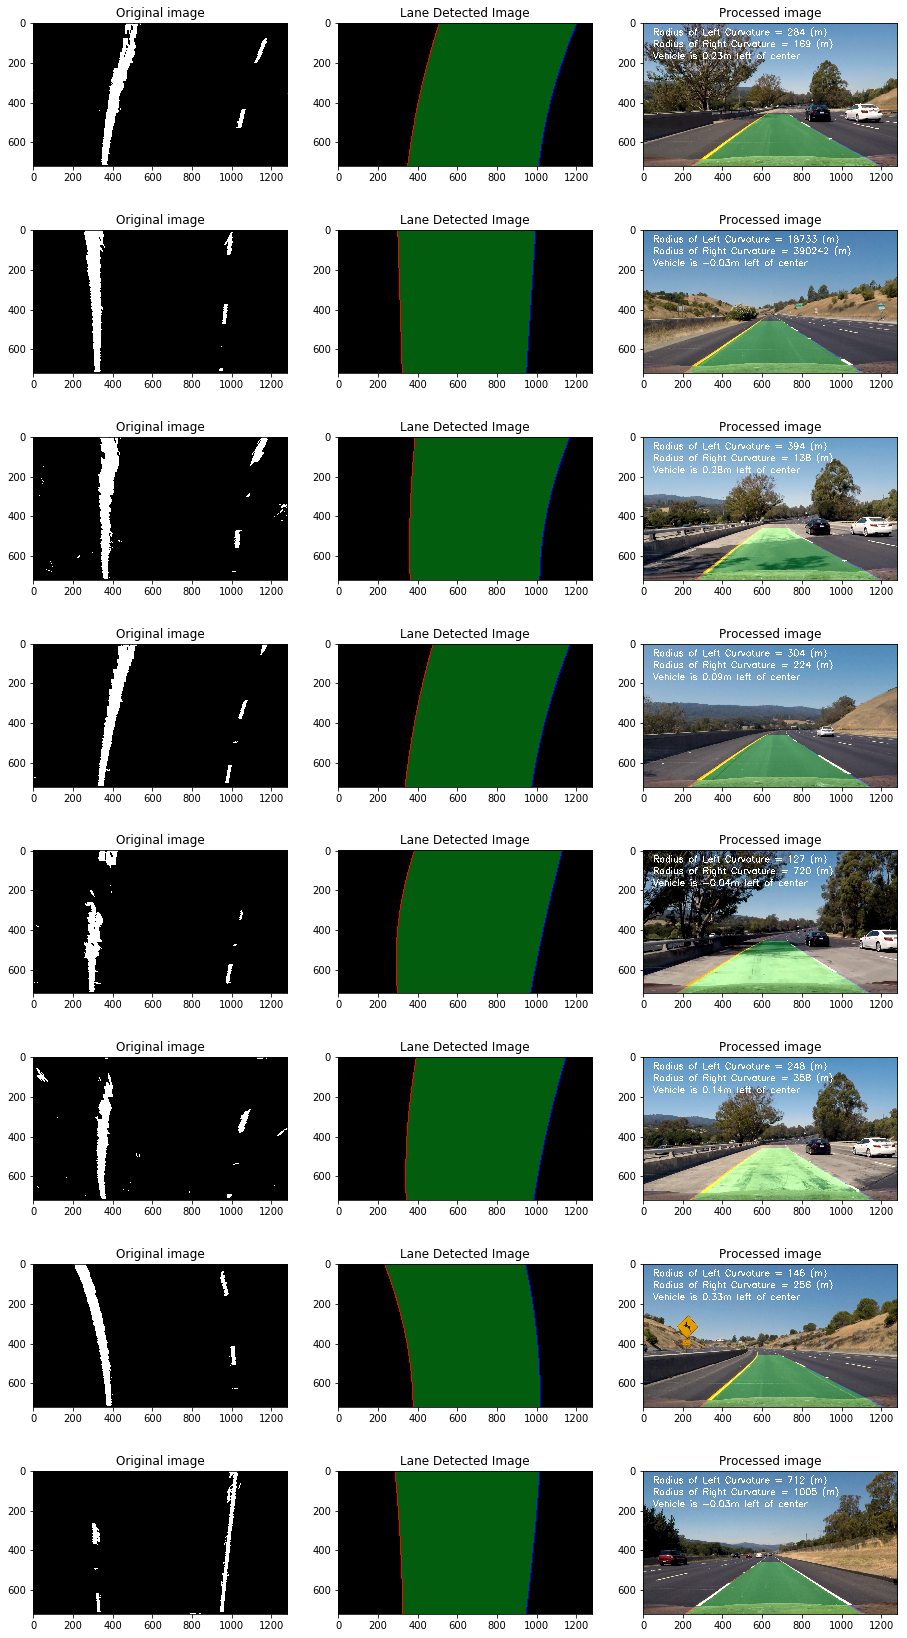

In [28]:
fig = plt.figure(figsize=(12,25))
fig.tight_layout()
fig.add_axes()

for idx, test_img in enumerate(test_img_list):
    line_class = Line()
    test_img = mpimg.imread(test_img)
#     test_img = check_img
    '''
    The lane is about 30 meters long and 3.7 meters wide
    In the perspective-transformed image, it has 720 relevant pixels in y-dimension and
    roughly 640 relevant pixels (320 to 960)
    '''
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    ym_per_pix = 15/720 # meters per pixel in y dimension (???)
    img_cpy = np.copy(test_img)
    binary_warped, warped_img, test_img_undistorted, M_inv = processing_img(img_cpy)
    lane_img, left_curverad, right_curverad, lane_center = lane_finding(binary_warped, xm_per_pix, ym_per_pix)
    output_img = annotate_img(img_cpy, lane_img, left_curverad, right_curverad, M_inv, lane_center, xm_per_pix, ym_per_pix)

    # output_img = pipeline_p2(check_img, xm_per_pix, ym_per_pix)
    
    # Display images
    ax0 = fig.add_subplot(len(test_img_list), 3, 3*idx+1)
    ax0.imshow(binary_warped, cmap='gray')
    ax0.set_title('Original image')
    
    ax1 = fig.add_subplot(len(test_img_list), 3, 3*idx+2)
    ax1.imshow(lane_img, cmap='gray')
#     ax1.plot(histogram)
    ax1.set_title('Lane Detected Image')
    
    ax2 = fig.add_subplot(len(test_img_list), 3, 3*idx+3)
    ax2.imshow(output_img, cmap='gray')
    ax2.set_title('Processed image')
#     break

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Test on Video
---

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

line_class = Line()

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)
    
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    ym_per_pix = 15/720 # meters per pixel in y dimension
    
    result = pipeline_p2(image, xm_per_pix, ym_per_pix)
    return result

### Project Video

In [34]:
line_class = Line()

output_file = 'output_images/project_video.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(0,3)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_file, audio=False)

Sliding Window...
Distance between 2 lanes:  647
[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

Sliding Window...
Distance between 2 lanes:  647



  0%|          | 2/1261 [00:00<04:11,  5.00it/s]

in search_around_poly... 637.110165669
......smoothing......
in search_around_poly... 626.146183821



  0%|          | 4/1261 [00:00<04:11,  5.00it/s]

in search_around_poly... 631.421466789
in search_around_poly... 631.304250316
......smoothing......



  0%|          | 6/1261 [00:01<04:09,  5.03it/s]

in search_around_poly... 629.384917902
in search_around_poly... 628.744950925



  1%|          | 8/1261 [00:01<04:07,  5.06it/s]

in search_around_poly... 643.305428503
......smoothing......



  1%|          | 9/1261 [00:01<04:12,  4.95it/s]

in search_around_poly... 640.651063304
in search_around_poly... 641.685289644



  1%|          | 11/1261 [00:02<04:08,  5.03it/s]

in search_around_poly... 635.330178473
......smoothing......
in search_around_poly... 636.071542799



  1%|          | 13/1261 [00:02<04:07,  5.04it/s]

in search_around_poly... 634.840856266
in search_around_poly... 628.798758503
......smoothing......



  1%|          | 15/1261 [00:02<04:05,  5.07it/s]

in search_around_poly... 627.465893332



  1%|▏         | 16/1261 [00:03<04:07,  5.02it/s]

in search_around_poly... 620.275105752
in search_around_poly... 618.320638573
......smoothing......



  1%|▏         | 18/1261 [00:03<04:09,  4.98it/s]

in search_around_poly... 618.139298032
in search_around_poly... 619.260857144



  2%|▏         | 20/1261 [00:04<04:07,  5.01it/s]

in search_around_poly... 618.909291542
......smoothing......



  2%|▏         | 21/1261 [00:04<04:09,  4.98it/s]

in search_around_poly... 622.086105176
in search_around_poly... 640.153434969



  2%|▏         | 23/1261 [00:04<04:07,  5.01it/s]

in search_around_poly... 634.381754579
......smoothing......
in search_around_poly...


  2%|▏         | 24/1261 [00:04<04:07,  5.01it/s]

 629.045038712
in search_around_poly... 625.842556687



  2%|▏         | 26/1261 [00:05<04:05,  5.02it/s]

in search_around_poly... 630.202928231
......smoothing......
in search_around_poly... 630.014845486



  2%|▏         | 28/1261 [00:05<04:04,  5.04it/s]

in search_around_poly... 637.799915549
in search_around_poly... 635.819782725
......smoothing......



  2%|▏         | 30/1261 [00:05<04:04,  5.03it/s]

in search_around_poly... 638.122496273
in search_around_poly... 638.445421472



  3%|▎         | 32/1261 [00:06<04:04,  5.04it/s]

in search_around_poly... 637.401243092
......smoothing......
in search_around_poly... 646.873538226



  3%|▎         | 34/1261 [00:06<04:01,  5.08it/s]

in search_around_poly... 652.835144761
in search_around_poly... 649.182369403
......smoothing......



  3%|▎         | 35/1261 [00:06<04:03,  5.02it/s]

in search_around_poly... 646.525420861



  3%|▎         | 37/1261 [00:07<04:00,  5.09it/s]

in search_around_poly... 645.600654645
in search_around_poly... 650.218352094
......smoothing......



  3%|▎         | 39/1261 [00:07<03:59,  5.10it/s]

in search_around_poly... 637.237858346
in search_around_poly... 628.242623613



  3%|▎         | 41/1261 [00:08<04:00,  5.07it/s]

in search_around_poly... 628.992683564
......smoothing......
in search_around_poly... 627.177876168



  3%|▎         | 43/1261 [00:08<05:48,  3.50it/s]

in search_around_poly... 626.554214197



  3%|▎         | 44/1261 [00:09<05:43,  3.54it/s]

in search_around_poly... 627.703711299
......smoothing......



  4%|▎         | 45/1261 [00:09<05:47,  3.50it/s]

in search_around_poly... 626.663670902



  4%|▎         | 46/1261 [00:09<05:45,  3.52it/s]

in search_around_poly... 661.266005401



  4%|▎         | 47/1261 [00:09<05:41,  3.55it/s]

in search_around_poly... 653.41505683
......smoothing......



  4%|▍         | 48/1261 [00:10<05:38,  3.59it/s]

in search_around_poly... 641.924955863



  4%|▍         | 49/1261 [00:10<05:38,  3.58it/s]

in search_around_poly... 641.076181306



  4%|▍         | 50/1261 [00:10<05:28,  3.69it/s]

in search_around_poly... 636.413538407
......smoothing......



  4%|▍         | 51/1261 [00:11<05:35,  3.61it/s]

in search_around_poly... 645.696154027



  4%|▍         | 52/1261 [00:11<05:23,  3.74it/s]

in search_around_poly... 636.113934738



  4%|▍         | 53/1261 [00:11<05:28,  3.67it/s]

in search_around_poly... 622.986091982
......smoothing......



  4%|▍         | 54/1261 [00:11<05:34,  3.61it/s]

in search_around_poly... 619.067295582



  4%|▍         | 55/1261 [00:12<05:25,  3.71it/s]

in search_around_poly... 619.292368119



  4%|▍         | 56/1261 [00:12<05:31,  3.64it/s]

in search_around_poly... 621.083873111
......smoothing......



  5%|▍         | 57/1261 [00:12<05:38,  3.55it/s]

in search_around_poly... 621.694930368



  5%|▍         | 58/1261 [00:12<05:27,  3.67it/s]

in search_around_poly... 627.586595794



  5%|▍         | 59/1261 [00:13<05:37,  3.56it/s]

in search_around_poly... 633.793772694
......smoothing......



  5%|▍         | 60/1261 [00:13<05:28,  3.66it/s]

in search_around_poly... 653.658449558



  5%|▍         | 61/1261 [00:13<05:31,  3.62it/s]

in search_around_poly... 632.971824496



  5%|▍         | 62/1261 [00:14<05:37,  3.56it/s]

in search_around_poly... 625.724435591
......smoothing......



  5%|▍         | 63/1261 [00:14<05:24,  3.69it/s]

in search_around_poly... 623.466185513



  5%|▌         | 64/1261 [00:14<05:32,  3.60it/s]

in search_around_poly... 625.442292618



  5%|▌         | 65/1261 [00:14<05:37,  3.55it/s]

in search_around_poly... 627.485223747
......smoothing......



  5%|▌         | 66/1261 [00:15<05:26,  3.66it/s]

in search_around_poly... 626.407014942



  5%|▌         | 67/1261 [00:15<05:32,  3.59it/s]

in search_around_poly... 623.526995217



  5%|▌         | 68/1261 [00:15<05:38,  3.52it/s]

in search_around_poly... 625.251189821
......smoothing......



  5%|▌         | 69/1261 [00:16<05:36,  3.54it/s]

in search_around_poly... 622.929266597



  6%|▌         | 70/1261 [00:16<05:40,  3.50it/s]

in search_around_poly... 624.1432664



  6%|▌         | 71/1261 [00:16<05:27,  3.63it/s]

in search_around_poly... 637.136842412
......smoothing......



  6%|▌         | 72/1261 [00:16<05:29,  3.61it/s]

in search_around_poly... 625.298807498



  6%|▌         | 73/1261 [00:17<05:38,  3.51it/s]

in search_around_poly... 628.235100041



  6%|▌         | 74/1261 [00:17<05:27,  3.62it/s]

in search_around_poly... 621.024018455
......smoothing......



  6%|▌         | 75/1261 [00:17<05:34,  3.54it/s]

in search_around_poly... 618.709682698



  6%|▌         | 76/1261 [00:17<05:25,  3.65it/s]

in search_around_poly... 613.403822944



  6%|▌         | 77/1261 [00:18<05:32,  3.56it/s]

in search_around_poly... 613.811333062
......smoothing......



  6%|▌         | 78/1261 [00:18<05:21,  3.67it/s]

in search_around_poly... 618.813408649



  6%|▋         | 79/1261 [00:18<05:31,  3.56it/s]

in search_around_poly... 619.056893217



  6%|▋         | 80/1261 [00:19<05:22,  3.66it/s]

in search_around_poly... 620.224436342
......smoothing......



  6%|▋         | 81/1261 [00:19<05:23,  3.65it/s]

in search_around_poly... 623.028957214



  7%|▋         | 82/1261 [00:19<05:22,  3.66it/s]

in search_around_poly... 625.542644688



  7%|▋         | 83/1261 [00:19<05:24,  3.63it/s]

in search_around_poly... 631.267841042
......smoothing......



  7%|▋         | 84/1261 [00:20<05:27,  3.60it/s]

in search_around_poly... 646.518398082



  7%|▋         | 85/1261 [00:20<05:16,  3.72it/s]

in search_around_poly... 652.365408391



  7%|▋         | 86/1261 [00:20<05:24,  3.62it/s]

in search_around_poly... 651.106783494
......smoothing......



  7%|▋         | 87/1261 [00:21<05:25,  3.61it/s]

in search_around_poly... 643.515765783



  7%|▋         | 88/1261 [00:21<05:28,  3.57it/s]

in search_around_poly... 641.096453941



  7%|▋         | 89/1261 [00:21<05:20,  3.66it/s]

in search_around_poly... 643.920963045
......smoothing......



  7%|▋         | 90/1261 [00:21<05:27,  3.57it/s]

in search_around_poly... 635.13455742



  7%|▋         | 91/1261 [00:22<05:16,  3.70it/s]

in search_around_poly... 632.803391243



  7%|▋         | 92/1261 [00:22<05:25,  3.60it/s]

in search_around_poly... 631.498123756
......smoothing......



  7%|▋         | 93/1261 [00:22<05:39,  3.44it/s]

in search_around_poly... 630.383113793



  7%|▋         | 94/1261 [00:22<05:29,  3.54it/s]

in search_around_poly... 627.463825089



  8%|▊         | 95/1261 [00:23<05:28,  3.55it/s]

in search_around_poly... 626.383536338
......smoothing......



  8%|▊         | 96/1261 [00:23<05:26,  3.57it/s]

in search_around_poly... 616.768124899



  8%|▊         | 97/1261 [00:23<05:23,  3.60it/s]

in search_around_poly... 624.609194778



  8%|▊         | 98/1261 [00:24<05:23,  3.60it/s]

in search_around_poly... 624.178431305
......smoothing......



  8%|▊         | 99/1261 [00:24<05:28,  3.54it/s]

in search_around_poly... 617.602317367



  8%|▊         | 100/1261 [00:24<05:17,  3.66it/s]

in search_around_poly... 620.924428795



  8%|▊         | 101/1261 [00:24<05:23,  3.58it/s]

in search_around_poly... 615.745624226
......smoothing......



  8%|▊         | 102/1261 [00:25<05:30,  3.51it/s]

in search_around_poly... 613.249894686



  8%|▊         | 103/1261 [00:25<05:20,  3.62it/s]

in search_around_poly... 614.88494299



  8%|▊         | 104/1261 [00:25<05:28,  3.53it/s]

in search_around_poly... 616.107481303
......smoothing......



  8%|▊         | 105/1261 [00:26<05:15,  3.66it/s]

in search_around_poly... 619.508528728



  8%|▊         | 106/1261 [00:26<05:27,  3.53it/s]

in search_around_poly... 621.350138126



  8%|▊         | 107/1261 [00:26<05:18,  3.62it/s]

in search_around_poly... 625.100770618
......smoothing......



  9%|▊         | 108/1261 [00:26<05:25,  3.54it/s]

in search_around_poly... 633.074490185



  9%|▊         | 109/1261 [00:27<05:13,  3.68it/s]

in search_around_poly... 656.830764689



  9%|▊         | 110/1261 [00:27<05:19,  3.60it/s]

in search_around_poly... 658.472593259
......smoothing......



  9%|▉         | 111/1261 [00:27<05:07,  3.73it/s]

in search_around_poly... 643.186346721



  9%|▉         | 112/1261 [00:27<05:20,  3.59it/s]

in search_around_poly... 630.5953822



  9%|▉         | 113/1261 [00:28<05:14,  3.65it/s]

in search_around_poly... 625.644030039
......smoothing......



  9%|▉         | 114/1261 [00:28<05:24,  3.53it/s]

in search_around_poly... 633.831153577



  9%|▉         | 115/1261 [00:28<05:13,  3.65it/s]

in search_around_poly... 627.124590135



  9%|▉         | 116/1261 [00:29<05:22,  3.55it/s]

in search_around_poly... 620.058630123
......smoothing......



  9%|▉         | 117/1261 [00:29<05:12,  3.67it/s]

in search_around_poly... 621.227150991



  9%|▉         | 118/1261 [00:29<05:16,  3.61it/s]

in search_around_poly... 622.132721064



  9%|▉         | 119/1261 [00:29<05:23,  3.53it/s]

in search_around_poly... 622.783669859
......smoothing......



 10%|▉         | 120/1261 [00:30<05:16,  3.61it/s]

in search_around_poly... 620.784424974



 10%|▉         | 121/1261 [00:30<05:19,  3.57it/s]

in search_around_poly... 626.23472359



 10%|▉         | 122/1261 [00:30<05:23,  3.52it/s]

in search_around_poly... 628.960123775
......smoothing......



 10%|▉         | 123/1261 [00:31<05:10,  3.66it/s]

in search_around_poly... 621.44901694



 10%|▉         | 124/1261 [00:31<05:18,  3.57it/s]

in search_around_poly... 622.593101616



 10%|▉         | 125/1261 [00:31<05:09,  3.67it/s]

in search_around_poly... 620.806503867
......smoothing......



 10%|▉         | 126/1261 [00:31<05:17,  3.58it/s]

in search_around_poly... 619.791610204



 10%|█         | 127/1261 [00:32<05:07,  3.68it/s]

in search_around_poly... 620.846104776



 10%|█         | 128/1261 [00:32<05:17,  3.57it/s]

in search_around_poly... 619.849362242
......smoothing......



 10%|█         | 129/1261 [00:32<05:08,  3.67it/s]

in search_around_poly... 616.744928894



 10%|█         | 130/1261 [00:32<05:15,  3.59it/s]

in search_around_poly... 616.256014068



 10%|█         | 131/1261 [00:33<05:07,  3.68it/s]

in search_around_poly... 616.287915573
......smoothing......



 10%|█         | 132/1261 [00:33<05:19,  3.54it/s]

in search_around_poly... 615.141247262



 11%|█         | 133/1261 [00:33<05:09,  3.64it/s]

in search_around_poly... 615.838468329



 11%|█         | 134/1261 [00:34<05:12,  3.60it/s]

in search_around_poly... 619.466333639
......smoothing......



 11%|█         | 135/1261 [00:34<05:28,  3.43it/s]

in search_around_poly... 616.668837562



 11%|█         | 136/1261 [00:34<05:14,  3.58it/s]

in search_around_poly... 621.642475352



 11%|█         | 137/1261 [00:34<05:17,  3.54it/s]

in search_around_poly... 622.505189984
......smoothing......



 11%|█         | 138/1261 [00:35<05:03,  3.69it/s]

in search_around_poly... 621.310329875



 11%|█         | 139/1261 [00:35<05:09,  3.62it/s]

in search_around_poly... 626.185499991



 11%|█         | 140/1261 [00:35<05:02,  3.71it/s]

in search_around_poly... 626.456063599
......smoothing......



 11%|█         | 141/1261 [00:36<05:12,  3.59it/s]

in search_around_poly... 636.62590356



 11%|█▏        | 142/1261 [00:36<05:03,  3.69it/s]

in search_around_poly... 628.19793444



 11%|█▏        | 143/1261 [00:36<05:07,  3.64it/s]

in search_around_poly... 627.535379314
......smoothing......



 11%|█▏        | 144/1261 [00:36<05:08,  3.62it/s]

in search_around_poly... 624.761120888



 11%|█▏        | 145/1261 [00:37<05:14,  3.54it/s]

in search_around_poly... 624.983660903



 12%|█▏        | 146/1261 [00:37<05:05,  3.64it/s]

in search_around_poly... 625.879928368
......smoothing......



 12%|█▏        | 147/1261 [00:37<05:14,  3.55it/s]

in search_around_poly... 651.396328541



 12%|█▏        | 148/1261 [00:37<05:02,  3.68it/s]

in search_around_poly... 631.406387965



 12%|█▏        | 149/1261 [00:38<05:13,  3.55it/s]

in search_around_poly... 630.067609916
......smoothing......



 12%|█▏        | 150/1261 [00:38<05:05,  3.64it/s]

in search_around_poly... 659.702305547



 12%|█▏        | 151/1261 [00:38<05:08,  3.60it/s]

in search_around_poly... 633.542508492



 12%|█▏        | 152/1261 [00:39<05:10,  3.58it/s]

in search_around_poly... 626.492188318
......smoothing......



 12%|█▏        | 153/1261 [00:39<05:08,  3.59it/s]

in search_around_poly... 616.135137621



 12%|█▏        | 154/1261 [00:39<05:00,  3.68it/s]

in search_around_poly... 618.813216483



 12%|█▏        | 155/1261 [00:39<05:04,  3.63it/s]

in search_around_poly... 625.486172803
......smoothing......



 12%|█▏        | 156/1261 [00:40<05:05,  3.61it/s]

in search_around_poly... 626.274944062



 12%|█▏        | 157/1261 [00:40<05:10,  3.55it/s]

in search_around_poly... 626.60748811



 13%|█▎        | 158/1261 [00:40<05:01,  3.65it/s]

in search_around_poly... 624.673381808
......smoothing......



 13%|█▎        | 159/1261 [00:41<05:02,  3.64it/s]

in search_around_poly... 654.9074988



 13%|█▎        | 160/1261 [00:41<05:06,  3.59it/s]

in search_around_poly... 641.384021286



 13%|█▎        | 161/1261 [00:41<04:58,  3.68it/s]

in search_around_poly... 677.985869533
......smoothing......



 13%|█▎        | 162/1261 [00:41<05:09,  3.55it/s]

in search_around_poly... 691.828746126



 13%|█▎        | 163/1261 [00:42<04:59,  3.67it/s]

in search_around_poly... 676.50957146



 13%|█▎        | 164/1261 [00:42<05:08,  3.56it/s]

in search_around_poly... 689.69632346
...Bad Frame...



 13%|█▎        | 165/1261 [00:42<04:58,  3.67it/s]

in search_around_poly... 633.689068011
......smoothing......



 13%|█▎        | 166/1261 [00:42<05:03,  3.61it/s]

in search_around_poly... 627.506046431



 13%|█▎        | 167/1261 [00:43<04:53,  3.73it/s]

in search_around_poly... 629.791861052



 13%|█▎        | 168/1261 [00:43<04:58,  3.66it/s]

in search_around_poly... 630.082133356
......smoothing......



 13%|█▎        | 169/1261 [00:43<04:48,  3.78it/s]

in search_around_poly... 630.109604409



 13%|█▎        | 170/1261 [00:44<04:57,  3.67it/s]

in search_around_poly... 630.249432716



 14%|█▎        | 171/1261 [00:44<04:47,  3.79it/s]

in search_around_poly... 638.558309443
......smoothing......



 14%|█▎        | 172/1261 [00:44<04:50,  3.75it/s]

in search_around_poly... 653.057635201



 14%|█▎        | 173/1261 [00:44<04:56,  3.66it/s]

in search_around_poly... 633.578682083



 14%|█▍        | 174/1261 [00:45<04:48,  3.77it/s]

in search_around_poly... 621.760719737
......smoothing......



 14%|█▍        | 175/1261 [00:45<04:56,  3.66it/s]

in search_around_poly... 619.599404948



 14%|█▍        | 176/1261 [00:45<04:49,  3.75it/s]

in search_around_poly... 610.278688765



 14%|█▍        | 177/1261 [00:45<04:56,  3.66it/s]

in search_around_poly... 616.475345516
......smoothing......



 14%|█▍        | 178/1261 [00:46<04:49,  3.75it/s]

in search_around_poly... 622.825669596



 14%|█▍        | 179/1261 [00:46<04:54,  3.68it/s]

in search_around_poly... 628.657181026



 14%|█▍        | 180/1261 [00:46<05:01,  3.58it/s]

in search_around_poly... 636.372271458
......smoothing......



 14%|█▍        | 181/1261 [00:46<04:51,  3.71it/s]

in search_around_poly... 637.025436193



 14%|█▍        | 182/1261 [00:47<04:55,  3.65it/s]

in search_around_poly... 642.652681342



 15%|█▍        | 183/1261 [00:47<04:54,  3.66it/s]

in search_around_poly... 644.560200234
......smoothing......



 15%|█▍        | 184/1261 [00:47<04:57,  3.61it/s]

in search_around_poly... 652.95035803



 15%|█▍        | 185/1261 [00:48<05:00,  3.59it/s]

in search_around_poly... 647.136212599



 15%|█▍        | 186/1261 [00:48<04:58,  3.60it/s]

in search_around_poly... 628.188152161
......smoothing......



 15%|█▍        | 187/1261 [00:48<04:57,  3.60it/s]

in search_around_poly... 634.879438626



 15%|█▍        | 188/1261 [00:48<05:02,  3.55it/s]

in search_around_poly... 642.124837686



 15%|█▍        | 189/1261 [00:49<04:52,  3.66it/s]

in search_around_poly... 642.676074313
......smoothing......



 15%|█▌        | 190/1261 [00:49<04:57,  3.60it/s]

in search_around_poly... 638.542515667



 15%|█▌        | 191/1261 [00:49<05:02,  3.53it/s]

in search_around_poly... 633.883386197



 15%|█▌        | 192/1261 [00:50<04:53,  3.64it/s]

in search_around_poly... 631.86726301
......smoothing......



 15%|█▌        | 193/1261 [00:50<05:04,  3.51it/s]

in search_around_poly... 628.602106847



 15%|█▌        | 194/1261 [00:50<04:55,  3.61it/s]

in search_around_poly... 625.164147204



 15%|█▌        | 195/1261 [00:50<04:59,  3.56it/s]

in search_around_poly... 629.948801458
......smoothing......



 16%|█▌        | 196/1261 [00:51<04:49,  3.68it/s]

in search_around_poly... 673.750461311



 16%|█▌        | 197/1261 [00:51<04:58,  3.57it/s]

in search_around_poly... 665.597318216



 16%|█▌        | 198/1261 [00:51<05:01,  3.52it/s]

in search_around_poly... 661.985688617
......smoothing......



 16%|█▌        | 199/1261 [00:52<04:52,  3.63it/s]

in search_around_poly... 649.841612442



 16%|█▌        | 200/1261 [00:52<05:00,  3.54it/s]

in search_around_poly... 640.177304078



 16%|█▌        | 201/1261 [00:52<04:51,  3.64it/s]

in search_around_poly... 634.759328971
......smoothing......



 16%|█▌        | 202/1261 [00:52<04:51,  3.63it/s]

in search_around_poly... 640.057452511



 16%|█▌        | 203/1261 [00:53<04:56,  3.57it/s]

in search_around_poly... 646.854206987



 16%|█▌        | 204/1261 [00:53<04:44,  3.71it/s]

in search_around_poly... 644.103436581
......smoothing......



 16%|█▋        | 205/1261 [00:53<04:54,  3.59it/s]

in search_around_poly... 639.602256189



 16%|█▋        | 206/1261 [00:53<04:46,  3.68it/s]

in search_around_poly... 639.653620778



 16%|█▋        | 207/1261 [00:54<04:50,  3.63it/s]

in search_around_poly... 637.560044768
......smoothing......



 16%|█▋        | 208/1261 [00:54<04:55,  3.57it/s]

in search_around_poly... 632.350194655



 17%|█▋        | 209/1261 [00:54<04:49,  3.63it/s]

in search_around_poly... 661.346158659



 17%|█▋        | 210/1261 [00:55<04:59,  3.51it/s]

in search_around_poly... 645.839729195
......smoothing......



 17%|█▋        | 211/1261 [00:55<04:49,  3.63it/s]

in search_around_poly... 652.041440297



 17%|█▋        | 212/1261 [00:55<04:55,  3.55it/s]

in search_around_poly... 670.185701734



 17%|█▋        | 213/1261 [00:55<04:44,  3.68it/s]

in search_around_poly... 674.561634782
......smoothing......



 17%|█▋        | 214/1261 [00:56<04:49,  3.62it/s]

in search_around_poly... 644.452667982



 17%|█▋        | 215/1261 [00:56<04:42,  3.70it/s]

in search_around_poly... 641.180000585



 17%|█▋        | 216/1261 [00:56<04:49,  3.61it/s]

in search_around_poly... 637.65741326
......smoothing......



 17%|█▋        | 217/1261 [00:56<04:43,  3.68it/s]

in search_around_poly... 635.562490101



 17%|█▋        | 218/1261 [00:57<04:46,  3.65it/s]

in search_around_poly... 634.117355879



 17%|█▋        | 219/1261 [00:57<04:51,  3.58it/s]

in search_around_poly... 632.299809462
......smoothing......



 17%|█▋        | 220/1261 [00:57<04:42,  3.69it/s]

in search_around_poly... 632.490672522



 18%|█▊        | 221/1261 [00:58<04:49,  3.59it/s]

in search_around_poly... 638.25651006



 18%|█▊        | 222/1261 [00:58<04:42,  3.68it/s]

in search_around_poly... 638.168790204
......smoothing......



 18%|█▊        | 223/1261 [00:58<04:53,  3.54it/s]

in search_around_poly... 637.280215909



 18%|█▊        | 224/1261 [00:58<04:46,  3.62it/s]

in search_around_poly... 633.464174031



 18%|█▊        | 225/1261 [00:59<05:33,  3.11it/s]

in search_around_poly... 635.246441767
......smoothing......



 18%|█▊        | 226/1261 [00:59<06:04,  2.84it/s]

in search_around_poly... 631.67206287



 18%|█▊        | 227/1261 [01:00<06:32,  2.63it/s]

in search_around_poly... 624.445853397



 18%|█▊        | 228/1261 [01:00<06:55,  2.48it/s]

in search_around_poly... 622.265807037
......smoothing......



 18%|█▊        | 229/1261 [01:00<06:08,  2.80it/s]

in search_around_poly... 622.333630066



 18%|█▊        | 230/1261 [01:01<05:50,  2.94it/s]

in search_around_poly... 624.769528313



 18%|█▊        | 231/1261 [01:01<05:23,  3.19it/s]

in search_around_poly... 626.555304571
......smoothing......



 18%|█▊        | 232/1261 [01:01<05:18,  3.23it/s]

in search_around_poly... 632.451065073



 18%|█▊        | 233/1261 [01:02<04:59,  3.43it/s]

in search_around_poly... 659.136213873



 19%|█▊        | 234/1261 [01:02<05:01,  3.40it/s]

in search_around_poly... 648.553275304
......smoothing......



 19%|█▊        | 235/1261 [01:02<04:47,  3.57it/s]

in search_around_poly... 646.191716101



 19%|█▊        | 236/1261 [01:02<04:53,  3.50it/s]

in search_around_poly... 636.510106937



 19%|█▉        | 237/1261 [01:03<04:43,  3.61it/s]

in search_around_poly... 633.388183864
......smoothing......



 19%|█▉        | 238/1261 [01:03<04:51,  3.51it/s]

in search_around_poly... 634.966116843



 19%|█▉        | 239/1261 [01:03<04:44,  3.60it/s]

in search_around_poly... 628.585163441



 19%|█▉        | 240/1261 [01:03<04:52,  3.49it/s]

in search_around_poly... 627.88504756
......smoothing......



 19%|█▉        | 241/1261 [01:04<04:42,  3.61it/s]

in search_around_poly... 627.463840856



 19%|█▉        | 242/1261 [01:04<04:43,  3.59it/s]

in search_around_poly... 632.009304415



 19%|█▉        | 243/1261 [01:04<04:44,  3.57it/s]

in search_around_poly... 631.104988427
......smoothing......



 19%|█▉        | 244/1261 [01:05<04:42,  3.60it/s]

in search_around_poly... 630.903322117



 19%|█▉        | 245/1261 [01:05<04:47,  3.53it/s]

in search_around_poly... 634.965741126



 20%|█▉        | 246/1261 [01:05<04:36,  3.67it/s]

in search_around_poly... 630.481144509
......smoothing......



 20%|█▉        | 247/1261 [01:05<04:42,  3.59it/s]

in search_around_poly... 634.766638815



 20%|█▉        | 248/1261 [01:06<04:33,  3.70it/s]

in search_around_poly... 628.576589917



 20%|█▉        | 249/1261 [01:06<04:42,  3.58it/s]

in search_around_poly... 629.691682522
......smoothing......



 20%|█▉        | 250/1261 [01:06<04:36,  3.66it/s]

in search_around_poly... 627.051823677



 20%|█▉        | 251/1261 [01:07<04:42,  3.57it/s]

in search_around_poly... 630.380264186



 20%|█▉        | 252/1261 [01:07<04:33,  3.69it/s]

in search_around_poly... 631.574387121
......smoothing......



 20%|██        | 253/1261 [01:07<04:42,  3.56it/s]

in search_around_poly... 631.086775529



 20%|██        | 254/1261 [01:07<04:33,  3.68it/s]

in search_around_poly... 633.094959764



 20%|██        | 255/1261 [01:08<04:38,  3.61it/s]

in search_around_poly... 631.513917444
......smoothing......



 20%|██        | 256/1261 [01:08<04:29,  3.73it/s]

in search_around_poly... 633.109606628



 20%|██        | 257/1261 [01:08<04:35,  3.65it/s]

in search_around_poly... 643.309298598



 20%|██        | 258/1261 [01:08<04:38,  3.60it/s]

in search_around_poly... 637.47641813
......smoothing......



 21%|██        | 259/1261 [01:09<04:29,  3.71it/s]

in search_around_poly... 642.158789363



 21%|██        | 260/1261 [01:09<04:38,  3.59it/s]

in search_around_poly... 633.597404417



 21%|██        | 261/1261 [01:09<04:30,  3.70it/s]

in search_around_poly... 633.052459398
......smoothing......



 21%|██        | 262/1261 [01:10<04:39,  3.58it/s]

in search_around_poly... 630.887296935



 21%|██        | 263/1261 [01:10<04:31,  3.67it/s]

in search_around_poly... 623.337498124



 21%|██        | 264/1261 [01:10<04:35,  3.62it/s]

in search_around_poly... 627.151894437
......smoothing......



 21%|██        | 265/1261 [01:10<04:38,  3.58it/s]

in search_around_poly... 630.535932115



 21%|██        | 266/1261 [01:11<04:32,  3.65it/s]

in search_around_poly... 634.899681273



 21%|██        | 267/1261 [01:11<04:34,  3.63it/s]

in search_around_poly... 635.321939567
......smoothing......



 21%|██▏       | 268/1261 [01:11<04:37,  3.58it/s]

in search_around_poly... 637.091730517



 21%|██▏       | 269/1261 [01:11<04:41,  3.52it/s]

in search_around_poly... 646.002080348



 21%|██▏       | 270/1261 [01:12<04:33,  3.63it/s]

in search_around_poly... 679.580576428
......smoothing......



 21%|██▏       | 271/1261 [01:12<04:33,  3.63it/s]

in search_around_poly... 646.442182594



 22%|██▏       | 272/1261 [01:12<04:38,  3.55it/s]

in search_around_poly... 642.723569795



 22%|██▏       | 273/1261 [01:13<04:29,  3.66it/s]

in search_around_poly... 637.57140523
......smoothing......



 22%|██▏       | 274/1261 [01:13<04:31,  3.64it/s]

in search_around_poly... 634.089813037



 22%|██▏       | 275/1261 [01:13<04:37,  3.55it/s]

in search_around_poly... 635.868215066



 22%|██▏       | 276/1261 [01:13<04:28,  3.67it/s]

in search_around_poly... 636.719696871
......smoothing......



 22%|██▏       | 277/1261 [01:14<04:34,  3.59it/s]

in search_around_poly... 636.824022085



 22%|██▏       | 278/1261 [01:14<04:30,  3.64it/s]

in search_around_poly... 637.996196281



 22%|██▏       | 279/1261 [01:14<04:26,  3.68it/s]

in search_around_poly... 634.843176904
......smoothing......



 22%|██▏       | 280/1261 [01:15<04:30,  3.63it/s]

in search_around_poly... 632.608341836



 22%|██▏       | 281/1261 [01:15<04:31,  3.61it/s]

in search_around_poly... 640.878364921



 22%|██▏       | 282/1261 [01:15<04:37,  3.52it/s]

in search_around_poly... 637.736057476
......smoothing......



 22%|██▏       | 283/1261 [01:15<04:30,  3.61it/s]

in search_around_poly... 639.914314312



 23%|██▎       | 284/1261 [01:16<04:32,  3.59it/s]

in search_around_poly... 631.027698455



 23%|██▎       | 285/1261 [01:16<04:31,  3.60it/s]

in search_around_poly... 629.278120945
......smoothing......



 23%|██▎       | 286/1261 [01:16<04:29,  3.62it/s]

in search_around_poly... 631.634576593



 23%|██▎       | 287/1261 [01:16<04:27,  3.64it/s]

in search_around_poly... 636.090729327



 23%|██▎       | 288/1261 [01:17<04:28,  3.62it/s]

in search_around_poly... 636.001162919
......smoothing......



 23%|██▎       | 289/1261 [01:17<04:35,  3.53it/s]

in search_around_poly... 634.109258839



 23%|██▎       | 290/1261 [01:17<04:30,  3.59it/s]

in search_around_poly... 635.239647146



 23%|██▎       | 291/1261 [01:18<04:26,  3.64it/s]

in search_around_poly... 633.922809512
......smoothing......



 23%|██▎       | 292/1261 [01:18<04:26,  3.64it/s]

in search_around_poly... 632.376365808



 23%|██▎       | 293/1261 [01:18<04:22,  3.68it/s]

in search_around_poly... 628.707497467



 23%|██▎       | 294/1261 [01:18<04:18,  3.75it/s]

in search_around_poly... 636.622744911
......smoothing......



 23%|██▎       | 295/1261 [01:19<04:08,  3.88it/s]

in search_around_poly... 637.185878611



 23%|██▎       | 296/1261 [01:19<04:16,  3.77it/s]

in search_around_poly... 631.158613891



 24%|██▎       | 297/1261 [01:19<04:10,  3.85it/s]

in search_around_poly... 628.087844477
......smoothing......



 24%|██▎       | 298/1261 [01:19<04:19,  3.70it/s]

in search_around_poly... 631.21771458



 24%|██▎       | 299/1261 [01:20<04:14,  3.78it/s]

in search_around_poly... 628.46044032



 24%|██▍       | 300/1261 [01:20<04:24,  3.63it/s]

in search_around_poly... 632.184978132
......smoothing......



 24%|██▍       | 301/1261 [01:20<04:16,  3.74it/s]

in search_around_poly... 633.829618397



 24%|██▍       | 302/1261 [01:21<04:25,  3.61it/s]

in search_around_poly... 635.615589253



 24%|██▍       | 303/1261 [01:21<04:18,  3.71it/s]

in search_around_poly... 635.872409239
......smoothing......



 24%|██▍       | 304/1261 [01:21<04:20,  3.67it/s]

in search_around_poly... 635.371252439



 24%|██▍       | 305/1261 [01:21<04:28,  3.56it/s]

in search_around_poly... 649.024094653



 24%|██▍       | 306/1261 [01:22<04:18,  3.69it/s]

in search_around_poly... 644.772592242
......smoothing......



 24%|██▍       | 307/1261 [01:22<04:24,  3.61it/s]

in search_around_poly... 650.510480928



 24%|██▍       | 308/1261 [01:22<04:18,  3.69it/s]

in search_around_poly... 644.909057724



 25%|██▍       | 309/1261 [01:22<04:25,  3.59it/s]

in search_around_poly... 640.482262762
......smoothing......



 25%|██▍       | 310/1261 [01:23<04:16,  3.71it/s]

in search_around_poly... 643.087011547



 25%|██▍       | 311/1261 [01:23<04:22,  3.62it/s]

in search_around_poly... 633.471630737



 25%|██▍       | 312/1261 [01:23<04:17,  3.69it/s]

in search_around_poly... 633.06001334
......smoothing......



 25%|██▍       | 313/1261 [01:24<04:27,  3.54it/s]

in search_around_poly... 630.416689804



 25%|██▍       | 314/1261 [01:24<04:22,  3.61it/s]

in search_around_poly... 627.850629161



 25%|██▍       | 315/1261 [01:24<04:26,  3.55it/s]

in search_around_poly... 629.692833114
......smoothing......



 25%|██▌       | 316/1261 [01:24<04:17,  3.67it/s]

in search_around_poly... 629.347951285



 25%|██▌       | 317/1261 [01:25<04:20,  3.62it/s]

in search_around_poly... 637.506122705



 25%|██▌       | 318/1261 [01:25<04:23,  3.58it/s]

in search_around_poly... 625.913059651
......smoothing......



 25%|██▌       | 319/1261 [01:25<04:14,  3.70it/s]

in search_around_poly... 620.985055919



 25%|██▌       | 320/1261 [01:25<04:23,  3.57it/s]

in search_around_poly... 618.774943426



 25%|██▌       | 321/1261 [01:26<04:20,  3.62it/s]

in search_around_poly... 619.392880457
......smoothing......



 26%|██▌       | 322/1261 [01:26<04:15,  3.68it/s]

in search_around_poly... 613.156396317



 26%|██▌       | 323/1261 [01:26<04:27,  3.51it/s]

in search_around_poly... 612.490558378



 26%|██▌       | 324/1261 [01:27<04:21,  3.59it/s]

in search_around_poly... 617.388436155
......smoothing......



 26%|██▌       | 325/1261 [01:27<04:13,  3.69it/s]

in search_around_poly... 619.035704216



 26%|██▌       | 326/1261 [01:27<04:25,  3.52it/s]

in search_around_poly... 620.293831911



 26%|██▌       | 327/1261 [01:27<04:19,  3.59it/s]

in search_around_poly... 622.359767544
......smoothing......



 26%|██▌       | 328/1261 [01:28<04:14,  3.67it/s]

in search_around_poly... 624.009868311



 26%|██▌       | 329/1261 [01:28<04:21,  3.56it/s]

in search_around_poly... 641.839786513



 26%|██▌       | 330/1261 [01:28<04:15,  3.64it/s]

in search_around_poly... 641.070843137
......smoothing......



 26%|██▌       | 331/1261 [01:29<04:21,  3.56it/s]

in search_around_poly... 638.067538267



 26%|██▋       | 332/1261 [01:29<04:14,  3.66it/s]

in search_around_poly... 635.267477446



 26%|██▋       | 333/1261 [01:29<04:18,  3.58it/s]

in search_around_poly... 628.417591606
......smoothing......



 26%|██▋       | 334/1261 [01:29<04:11,  3.69it/s]

in search_around_poly... 630.138854581



 27%|██▋       | 335/1261 [01:30<04:20,  3.56it/s]

in search_around_poly... 631.541576305



 27%|██▋       | 336/1261 [01:30<04:14,  3.64it/s]

in search_around_poly... 632.306896831
......smoothing......



 27%|██▋       | 337/1261 [01:30<04:21,  3.53it/s]

in search_around_poly... 633.27894694



 27%|██▋       | 338/1261 [01:30<04:13,  3.64it/s]

in search_around_poly... 631.013650458



 27%|██▋       | 339/1261 [01:31<04:17,  3.58it/s]

in search_around_poly... 632.493262607
......smoothing......



 27%|██▋       | 340/1261 [01:31<04:20,  3.53it/s]

in search_around_poly... 628.633535853



 27%|██▋       | 341/1261 [01:31<04:12,  3.64it/s]

in search_around_poly... 635.351778148



 27%|██▋       | 342/1261 [01:32<04:21,  3.51it/s]

in search_around_poly... 633.291545975
......smoothing......



 27%|██▋       | 343/1261 [01:32<04:13,  3.62it/s]

in search_around_poly... 631.810285733



 27%|██▋       | 344/1261 [01:32<04:19,  3.53it/s]

in search_around_poly... 625.351409387



 27%|██▋       | 345/1261 [01:32<04:10,  3.65it/s]

in search_around_poly... 629.956706119
......smoothing......



 27%|██▋       | 346/1261 [01:33<04:18,  3.53it/s]

in search_around_poly... 627.760822293



 28%|██▊       | 347/1261 [01:33<04:15,  3.58it/s]

in search_around_poly... 621.211486913



 28%|██▊       | 348/1261 [01:33<04:08,  3.67it/s]

in search_around_poly... 623.534662545
......smoothing......



 28%|██▊       | 349/1261 [01:34<04:19,  3.52it/s]

in search_around_poly... 627.266110159



 28%|██▊       | 350/1261 [01:34<04:14,  3.58it/s]

in search_around_poly... 627.9621635



 28%|██▊       | 351/1261 [01:34<04:10,  3.64it/s]

in search_around_poly... 629.046438189
......smoothing......



 28%|██▊       | 352/1261 [01:34<04:19,  3.50it/s]

in search_around_poly... 630.779907224



 28%|██▊       | 353/1261 [01:35<04:13,  3.58it/s]

in search_around_poly... 637.194140042



 28%|██▊       | 354/1261 [01:35<04:08,  3.66it/s]

in search_around_poly... 644.257409187
......smoothing......



 28%|██▊       | 355/1261 [01:35<04:17,  3.52it/s]

in search_around_poly... 646.060021471



 28%|██▊       | 356/1261 [01:36<04:12,  3.58it/s]

in search_around_poly... 643.392186276



 28%|██▊       | 357/1261 [01:36<04:06,  3.67it/s]

in search_around_poly... 634.394224989
......smoothing......



 28%|██▊       | 358/1261 [01:36<04:14,  3.55it/s]

in search_around_poly... 629.717736288



 28%|██▊       | 359/1261 [01:36<04:08,  3.63it/s]

in search_around_poly... 621.418383983



 29%|██▊       | 360/1261 [01:37<04:16,  3.51it/s]

in search_around_poly... 623.664097304
......smoothing......



 29%|██▊       | 361/1261 [01:37<04:08,  3.62it/s]

in search_around_poly... 622.440759775



 29%|██▊       | 362/1261 [01:37<04:12,  3.56it/s]

in search_around_poly... 618.075084107



 29%|██▉       | 363/1261 [01:37<04:14,  3.53it/s]

in search_around_poly... 616.177990919
......smoothing......



 29%|██▉       | 364/1261 [01:38<04:14,  3.53it/s]

in search_around_poly... 613.976545638



 29%|██▉       | 365/1261 [01:38<04:06,  3.64it/s]

in search_around_poly... 621.028039918



 29%|██▉       | 366/1261 [01:38<04:14,  3.52it/s]

in search_around_poly... 621.915110207
......smoothing......



 29%|██▉       | 367/1261 [01:39<04:06,  3.63it/s]

in search_around_poly... 620.852627182



 29%|██▉       | 368/1261 [01:39<04:07,  3.61it/s]

in search_around_poly... 652.001671579



 29%|██▉       | 369/1261 [01:39<04:13,  3.52it/s]

in search_around_poly... 636.165604468
......smoothing......



 29%|██▉       | 370/1261 [01:39<04:07,  3.60it/s]

in search_around_poly... 635.442370598



 29%|██▉       | 371/1261 [01:40<04:02,  3.67it/s]

in search_around_poly... 620.014911039



 30%|██▉       | 372/1261 [01:40<04:07,  3.59it/s]

in search_around_poly... 622.484072765
......smoothing......



 30%|██▉       | 373/1261 [01:40<04:14,  3.50it/s]

in search_around_poly... 627.869492707



 30%|██▉       | 374/1261 [01:41<04:06,  3.59it/s]

in search_around_poly... 629.084316319



 30%|██▉       | 375/1261 [01:41<04:11,  3.53it/s]

in search_around_poly... 631.038997847
......smoothing......



 30%|██▉       | 376/1261 [01:41<04:07,  3.57it/s]

in search_around_poly... 634.827587021



 30%|██▉       | 377/1261 [01:41<04:06,  3.59it/s]

in search_around_poly... 647.311049026



 30%|██▉       | 378/1261 [01:42<04:05,  3.60it/s]

in search_around_poly... 647.315483266
......smoothing......



 30%|███       | 379/1261 [01:42<04:09,  3.53it/s]

in search_around_poly... 646.267985095



 30%|███       | 380/1261 [01:42<04:03,  3.62it/s]

in search_around_poly... 644.587258731



 30%|███       | 381/1261 [01:42<04:04,  3.60it/s]

in search_around_poly... 642.857199078
......smoothing......



 30%|███       | 382/1261 [01:43<04:05,  3.58it/s]

in search_around_poly... 638.492591961



 30%|███       | 383/1261 [01:43<04:05,  3.58it/s]

in search_around_poly... 634.21101521



 30%|███       | 384/1261 [01:43<04:06,  3.56it/s]

in search_around_poly... 634.416772453
......smoothing......



 31%|███       | 385/1261 [01:44<04:08,  3.52it/s]

in search_around_poly... 631.565676639



 31%|███       | 386/1261 [01:44<04:02,  3.61it/s]

in search_around_poly... 632.657408279



 31%|███       | 387/1261 [01:44<04:06,  3.55it/s]

in search_around_poly... 632.534704812
......smoothing......



 31%|███       | 388/1261 [01:44<04:08,  3.51it/s]

in search_around_poly... 630.725618165



 31%|███       | 389/1261 [01:45<04:02,  3.60it/s]

in search_around_poly... 634.91326163



 31%|███       | 390/1261 [01:45<04:06,  3.54it/s]

in search_around_poly... 637.177250194
......smoothing......



 31%|███       | 391/1261 [01:45<04:10,  3.47it/s]

in search_around_poly... 649.512716055



 31%|███       | 392/1261 [01:46<04:01,  3.59it/s]

in search_around_poly... 651.005062909



 31%|███       | 393/1261 [01:46<04:07,  3.51it/s]

in search_around_poly... 636.561437336
......smoothing......



 31%|███       | 394/1261 [01:46<03:58,  3.64it/s]

in search_around_poly... 635.505902508



 31%|███▏      | 395/1261 [01:46<04:05,  3.52it/s]

in search_around_poly... 632.377805294



 31%|███▏      | 396/1261 [01:47<03:58,  3.63it/s]

in search_around_poly... 627.768654043
......smoothing......



 31%|███▏      | 397/1261 [01:47<04:03,  3.55it/s]

in search_around_poly... 629.238417437



 32%|███▏      | 398/1261 [01:47<03:56,  3.65it/s]

in search_around_poly... 631.756265553



 32%|███▏      | 399/1261 [01:48<03:58,  3.62it/s]

in search_around_poly... 632.493574708
......smoothing......



 32%|███▏      | 400/1261 [01:48<04:01,  3.57it/s]

in search_around_poly... 632.301367503



 32%|███▏      | 401/1261 [01:48<03:55,  3.65it/s]

in search_around_poly... 634.714054198



 32%|███▏      | 402/1261 [01:48<03:58,  3.61it/s]

in search_around_poly... 642.599111654
......smoothing......



 32%|███▏      | 403/1261 [01:49<04:04,  3.51it/s]

in search_around_poly... 635.366250703



 32%|███▏      | 404/1261 [01:49<03:59,  3.58it/s]

in search_around_poly... 634.110246465



 32%|███▏      | 405/1261 [01:49<04:03,  3.52it/s]

in search_around_poly... 626.40656919
......smoothing......



 32%|███▏      | 406/1261 [01:50<04:04,  3.49it/s]

in search_around_poly... 629.172955318



 32%|███▏      | 407/1261 [01:50<03:57,  3.59it/s]

in search_around_poly... 626.899706331



 32%|███▏      | 408/1261 [01:50<04:01,  3.54it/s]

in search_around_poly... 625.076834052
......smoothing......



 32%|███▏      | 409/1261 [01:50<04:03,  3.50it/s]

in search_around_poly... 626.38789386



 33%|███▎      | 410/1261 [01:51<03:56,  3.60it/s]

in search_around_poly... 626.433575383



 33%|███▎      | 411/1261 [01:51<03:57,  3.58it/s]

in search_around_poly... 626.679612101
......smoothing......



 33%|███▎      | 412/1261 [01:51<03:56,  3.59it/s]

in search_around_poly... 629.301605849



 33%|███▎      | 413/1261 [01:51<03:56,  3.58it/s]

in search_around_poly... 640.271595682



 33%|███▎      | 414/1261 [01:52<04:03,  3.48it/s]

in search_around_poly... 683.413142424
......smoothing......



 33%|███▎      | 415/1261 [01:52<03:57,  3.56it/s]

in search_around_poly... 669.119648986



 33%|███▎      | 416/1261 [01:52<04:05,  3.45it/s]

in search_around_poly... 659.020521796



 33%|███▎      | 417/1261 [01:53<03:58,  3.54it/s]

in search_around_poly... 650.03098855
......smoothing......



 33%|███▎      | 418/1261 [01:53<04:04,  3.45it/s]

in search_around_poly... 639.270658942



 33%|███▎      | 419/1261 [01:53<03:57,  3.54it/s]

in search_around_poly... 637.821621358



 33%|███▎      | 420/1261 [01:53<03:59,  3.51it/s]

in search_around_poly... 632.132147851
......smoothing......



 33%|███▎      | 421/1261 [01:54<03:58,  3.53it/s]

in search_around_poly... 632.115328551



 33%|███▎      | 422/1261 [01:54<03:59,  3.51it/s]

in search_around_poly... 627.643145737



 34%|███▎      | 423/1261 [01:54<03:57,  3.53it/s]

in search_around_poly... 629.955387644
......smoothing......



 34%|███▎      | 424/1261 [01:55<03:58,  3.51it/s]

in search_around_poly... 629.54590748



 34%|███▎      | 425/1261 [01:55<03:56,  3.53it/s]

in search_around_poly... 631.237709079



 34%|███▍      | 426/1261 [01:55<03:55,  3.54it/s]

in search_around_poly... 639.299093644
......smoothing......



 34%|███▍      | 427/1261 [01:55<03:56,  3.52it/s]

in search_around_poly... 636.38858325



 34%|███▍      | 428/1261 [01:56<03:50,  3.61it/s]

in search_around_poly... 631.329885757



 34%|███▍      | 429/1261 [01:56<03:57,  3.51it/s]

in search_around_poly... 627.848496207
......smoothing......



 34%|███▍      | 430/1261 [01:56<03:50,  3.60it/s]

in search_around_poly... 626.26054676



 34%|███▍      | 431/1261 [01:57<03:54,  3.53it/s]

in search_around_poly... 633.928827722



 34%|███▍      | 432/1261 [01:57<03:47,  3.64it/s]

in search_around_poly... 627.336643035
......smoothing......



 34%|███▍      | 433/1261 [01:57<03:56,  3.50it/s]

in search_around_poly... 629.13844526



 34%|███▍      | 434/1261 [01:57<03:51,  3.58it/s]

in search_around_poly... 628.647219218



 34%|███▍      | 435/1261 [01:58<03:52,  3.55it/s]

in search_around_poly... 627.989947012
......smoothing......



 35%|███▍      | 436/1261 [01:58<03:54,  3.52it/s]

in search_around_poly... 628.585756749



 35%|███▍      | 437/1261 [01:58<03:47,  3.61it/s]

in search_around_poly... 631.256225912



 35%|███▍      | 438/1261 [01:59<03:47,  3.62it/s]

in search_around_poly... 652.910407147
......smoothing......



 35%|███▍      | 439/1261 [01:59<03:51,  3.56it/s]

in search_around_poly... 654.162782204



 35%|███▍      | 440/1261 [01:59<03:45,  3.64it/s]

in search_around_poly... 631.840236429



 35%|███▍      | 441/1261 [01:59<03:50,  3.56it/s]

in search_around_poly... 627.038940371
......smoothing......



 35%|███▌      | 442/1261 [02:00<03:44,  3.65it/s]

in search_around_poly... 626.518631738



 35%|███▌      | 443/1261 [02:00<03:46,  3.61it/s]

in search_around_poly... 632.056017148



 35%|███▌      | 444/1261 [02:00<03:45,  3.62it/s]

in search_around_poly... 636.637918116
......smoothing......



 35%|███▌      | 445/1261 [02:00<03:45,  3.62it/s]

in search_around_poly... 634.833358537



 35%|███▌      | 446/1261 [02:01<03:49,  3.56it/s]

in search_around_poly... 633.562725838



 35%|███▌      | 447/1261 [02:01<03:42,  3.66it/s]

in search_around_poly... 632.790228639
......smoothing......



 36%|███▌      | 448/1261 [02:01<03:49,  3.54it/s]

in search_around_poly... 636.9028079



 36%|███▌      | 449/1261 [02:02<03:43,  3.64it/s]

in search_around_poly... 648.719645828



 36%|███▌      | 450/1261 [02:02<03:46,  3.57it/s]

in search_around_poly... 645.25792527
......smoothing......



 36%|███▌      | 451/1261 [02:02<03:48,  3.54it/s]

in search_around_poly... 649.639996919



 36%|███▌      | 452/1261 [02:02<03:42,  3.64it/s]

in search_around_poly... 642.140032516



 36%|███▌      | 453/1261 [02:03<03:46,  3.56it/s]

in search_around_poly... 643.64186658
......smoothing......



 36%|███▌      | 454/1261 [02:03<03:39,  3.67it/s]

in search_around_poly... 640.238284931



 36%|███▌      | 455/1261 [02:03<03:41,  3.64it/s]

in search_around_poly... 640.614278972



 36%|███▌      | 456/1261 [02:04<03:41,  3.64it/s]

in search_around_poly... 639.75542648
......smoothing......



 36%|███▌      | 457/1261 [02:04<03:47,  3.54it/s]

in search_around_poly... 634.902637094



 36%|███▋      | 458/1261 [02:04<03:44,  3.58it/s]

in search_around_poly... 636.37266787



 36%|███▋      | 459/1261 [02:04<03:49,  3.50it/s]

in search_around_poly... 636.326990822
......smoothing......



 36%|███▋      | 460/1261 [02:05<03:41,  3.61it/s]

in search_around_poly... 638.208359191



 37%|███▋      | 461/1261 [02:05<03:47,  3.51it/s]

in search_around_poly... 645.259717263



 37%|███▋      | 462/1261 [02:05<03:40,  3.62it/s]

in search_around_poly... 649.613482569
......smoothing......



 37%|███▋      | 463/1261 [02:06<03:48,  3.49it/s]

in search_around_poly... 657.855430966



 37%|███▋      | 464/1261 [02:06<03:44,  3.56it/s]

in search_around_poly... 647.389240101



 37%|███▋      | 465/1261 [02:06<03:45,  3.53it/s]

in search_around_poly... 653.428069216
......smoothing......



 37%|███▋      | 466/1261 [02:06<03:46,  3.51it/s]

in search_around_poly... 651.393073542



 37%|███▋      | 467/1261 [02:07<03:40,  3.61it/s]

in search_around_poly... 643.198053555



 37%|███▋      | 468/1261 [02:07<03:47,  3.49it/s]

in search_around_poly... 637.69001874
......smoothing......



 37%|███▋      | 469/1261 [02:07<03:39,  3.61it/s]

in search_around_poly... 633.711925679



 37%|███▋      | 470/1261 [02:07<03:45,  3.50it/s]

in search_around_poly... 634.2487184



 37%|███▋      | 471/1261 [02:08<03:39,  3.60it/s]

in search_around_poly... 630.567933301
......smoothing......



 37%|███▋      | 472/1261 [02:08<03:44,  3.52it/s]

in search_around_poly... 629.743107289



 38%|███▊      | 473/1261 [02:08<03:37,  3.62it/s]

in search_around_poly... 631.696366135



 38%|███▊      | 474/1261 [02:09<03:41,  3.55it/s]

in search_around_poly... 622.610785225
......smoothing......



 38%|███▊      | 475/1261 [02:09<03:35,  3.65it/s]

in search_around_poly... 626.165272938



 38%|███▊      | 476/1261 [02:09<03:38,  3.59it/s]

in search_around_poly... 624.597331968



 38%|███▊      | 477/1261 [02:09<03:43,  3.51it/s]

in search_around_poly... 638.848860028
......smoothing......



 38%|███▊      | 478/1261 [02:10<03:36,  3.62it/s]

in search_around_poly... 641.143830221



 38%|███▊      | 479/1261 [02:10<03:37,  3.60it/s]

in search_around_poly... 632.748044231



 38%|███▊      | 480/1261 [02:10<03:42,  3.51it/s]

in search_around_poly... 631.250138366
......smoothing......



 38%|███▊      | 481/1261 [02:11<03:34,  3.63it/s]

in search_around_poly... 626.676505871



 38%|███▊      | 482/1261 [02:11<03:39,  3.55it/s]

in search_around_poly... 629.050036313



 38%|███▊      | 483/1261 [02:11<03:33,  3.65it/s]

in search_around_poly... 630.459143345
......smoothing......



 38%|███▊      | 484/1261 [02:11<03:39,  3.54it/s]

in search_around_poly... 631.66730451



 38%|███▊      | 485/1261 [02:12<03:34,  3.62it/s]

in search_around_poly... 636.68788128



 39%|███▊      | 486/1261 [02:12<03:40,  3.52it/s]

in search_around_poly... 638.368039531
......smoothing......



 39%|███▊      | 487/1261 [02:12<03:35,  3.59it/s]

in search_around_poly... 637.906545558



 39%|███▊      | 488/1261 [02:12<03:31,  3.65it/s]

in search_around_poly... 644.007530077



 39%|███▉      | 489/1261 [02:13<03:39,  3.52it/s]

in search_around_poly... 646.3346829
......smoothing......



 39%|███▉      | 490/1261 [02:13<03:34,  3.60it/s]

in search_around_poly... 641.71684119



 39%|███▉      | 491/1261 [02:13<03:32,  3.62it/s]

in search_around_poly... 633.816966795



 39%|███▉      | 492/1261 [02:14<03:43,  3.44it/s]

in search_around_poly... 639.352907674
......smoothing......



 39%|███▉      | 493/1261 [02:14<03:35,  3.57it/s]

in search_around_poly... 634.089807442



 39%|███▉      | 494/1261 [02:14<03:39,  3.49it/s]

in search_around_poly... 635.775219632



 39%|███▉      | 495/1261 [02:14<03:30,  3.64it/s]

in search_around_poly... 635.332171035
......smoothing......



 39%|███▉      | 496/1261 [02:15<03:34,  3.57it/s]

in search_around_poly... 633.321699878



 39%|███▉      | 497/1261 [02:15<03:28,  3.67it/s]

in search_around_poly... 636.822158185



 39%|███▉      | 498/1261 [02:15<03:30,  3.62it/s]

in search_around_poly... 638.288905964
......smoothing......



 40%|███▉      | 499/1261 [02:16<03:29,  3.64it/s]

in search_around_poly... 645.769516526



 40%|███▉      | 500/1261 [02:16<03:35,  3.53it/s]

in search_around_poly... 656.194419348



 40%|███▉      | 501/1261 [02:16<03:33,  3.55it/s]

in search_around_poly... 676.34686573
......smoothing......



 40%|███▉      | 502/1261 [02:16<03:28,  3.64it/s]

in search_around_poly... 657.629161847



 40%|███▉      | 503/1261 [02:17<03:40,  3.44it/s]

in search_around_poly... 647.070315098



 40%|███▉      | 504/1261 [02:17<03:34,  3.52it/s]

in search_around_poly... 648.904092701
......smoothing......



 40%|████      | 505/1261 [02:17<03:31,  3.58it/s]

in search_around_poly... 647.522764085



 40%|████      | 506/1261 [02:18<03:40,  3.42it/s]

in search_around_poly... 649.625837082



 40%|████      | 507/1261 [02:18<03:35,  3.49it/s]

in search_around_poly... 647.671097321
......smoothing......



 40%|████      | 508/1261 [02:18<03:31,  3.56it/s]

in search_around_poly... 647.60352782



 40%|████      | 509/1261 [02:18<03:40,  3.42it/s]

in search_around_poly... 653.045433034



 40%|████      | 510/1261 [02:19<03:36,  3.48it/s]

in search_around_poly... 651.10603696
......smoothing......



 41%|████      | 511/1261 [02:19<03:30,  3.56it/s]

in search_around_poly... 650.753896832



 41%|████      | 512/1261 [02:19<03:37,  3.45it/s]

in search_around_poly... 647.501491452



 41%|████      | 513/1261 [02:20<03:30,  3.56it/s]

in search_around_poly... 640.373618189
......smoothing......



 41%|████      | 514/1261 [02:20<03:35,  3.46it/s]

in search_around_poly... 640.952944639



 41%|████      | 515/1261 [02:20<03:31,  3.52it/s]

in search_around_poly... 637.22110261



 41%|████      | 516/1261 [02:20<03:27,  3.60it/s]

in search_around_poly... 643.998123879
......smoothing......



 41%|████      | 517/1261 [02:21<03:34,  3.47it/s]

in search_around_poly... 639.52251086



 41%|████      | 518/1261 [02:21<03:27,  3.57it/s]

in search_around_poly... 634.313521354



 41%|████      | 519/1261 [02:21<03:32,  3.50it/s]

in search_around_poly... 635.93496674
......smoothing......



 41%|████      | 520/1261 [02:22<03:25,  3.61it/s]

in search_around_poly... 634.214263407



 41%|████▏     | 521/1261 [02:22<03:28,  3.55it/s]

in search_around_poly... 645.062703275



 41%|████▏     | 522/1261 [02:22<03:27,  3.56it/s]

in search_around_poly... 643.999895005
......smoothing......



 41%|████▏     | 523/1261 [02:22<03:32,  3.47it/s]

in search_around_poly... 649.487493844



 42%|████▏     | 524/1261 [02:23<03:26,  3.56it/s]

in search_around_poly... 648.258086706



 42%|████▏     | 525/1261 [02:23<03:34,  3.43it/s]

in search_around_poly... 642.81701734
......smoothing......



 42%|████▏     | 526/1261 [02:23<03:26,  3.55it/s]

in search_around_poly... 638.587554902



 42%|████▏     | 527/1261 [02:24<03:33,  3.44it/s]

in search_around_poly... 643.396406726



 42%|████▏     | 528/1261 [02:24<03:26,  3.55it/s]

in search_around_poly... 645.255520689
......smoothing......



 42%|████▏     | 529/1261 [02:24<03:27,  3.53it/s]

in search_around_poly... 640.564406302



 42%|████▏     | 530/1261 [02:24<03:26,  3.54it/s]

in search_around_poly... 637.081508799



 42%|████▏     | 531/1261 [02:25<03:25,  3.55it/s]

in search_around_poly... 636.897855261
......smoothing......



 42%|████▏     | 532/1261 [02:25<03:22,  3.60it/s]

in search_around_poly... 634.45741691



 42%|████▏     | 533/1261 [02:25<03:24,  3.56it/s]

in search_around_poly... 643.785070036



 42%|████▏     | 534/1261 [02:26<03:23,  3.56it/s]

in search_around_poly... 644.002176875
......smoothing......



 42%|████▏     | 535/1261 [02:26<03:23,  3.57it/s]

in search_around_poly... 640.733438044



 43%|████▎     | 536/1261 [02:26<03:22,  3.58it/s]

in search_around_poly... 659.130838008



 43%|████▎     | 537/1261 [02:26<03:22,  3.58it/s]

in search_around_poly... 636.297887107
......smoothing......



 43%|████▎     | 538/1261 [02:27<03:20,  3.61it/s]

in search_around_poly... 644.883063994



 43%|████▎     | 539/1261 [02:27<03:20,  3.60it/s]

in search_around_poly... 647.717485387



 43%|████▎     | 540/1261 [02:27<03:21,  3.57it/s]

in search_around_poly... 644.28887647
......smoothing......



 43%|████▎     | 541/1261 [02:27<03:20,  3.59it/s]

in search_around_poly... 634.599703947



 43%|████▎     | 542/1261 [02:28<03:20,  3.58it/s]

in search_around_poly... 635.092316696



 43%|████▎     | 543/1261 [02:28<03:17,  3.64it/s]

in search_around_poly... 632.646213277
......smoothing......



 43%|████▎     | 544/1261 [02:28<03:12,  3.72it/s]

in search_around_poly... 629.930556844



 43%|████▎     | 545/1261 [02:29<03:08,  3.79it/s]

in search_around_poly... 635.798213893



 43%|████▎     | 546/1261 [02:29<03:10,  3.75it/s]

in search_around_poly... 634.300148032
......smoothing......



 43%|████▎     | 547/1261 [02:29<03:18,  3.60it/s]

in search_around_poly... 639.134676002



 43%|████▎     | 548/1261 [02:29<03:14,  3.67it/s]

in search_around_poly... 636.018792996



 44%|████▎     | 549/1261 [02:30<03:18,  3.58it/s]

in search_around_poly... 634.259078741
......smoothing......



 44%|████▎     | 550/1261 [02:30<03:23,  3.50it/s]

in search_around_poly... 636.561889516



 44%|████▎     | 551/1261 [02:30<03:19,  3.57it/s]

in search_around_poly... 636.10685198



 44%|████▍     | 552/1261 [02:31<03:30,  3.37it/s]

in search_around_poly... 639.335714616
......smoothing......



 44%|████▍     | 553/1261 [02:31<03:24,  3.47it/s]

in search_around_poly... 636.306874233



 44%|████▍     | 554/1261 [02:31<03:32,  3.33it/s]

in search_around_poly... 642.053445696



 44%|████▍     | 555/1261 [02:31<03:26,  3.41it/s]

in search_around_poly... 646.076141748
......smoothing......



 44%|████▍     | 556/1261 [02:32<03:33,  3.31it/s]

in search_around_poly... 661.134274203



 44%|████▍     | 557/1261 [02:32<03:26,  3.41it/s]

in search_around_poly... 634.605442107



 44%|████▍     | 558/1261 [02:32<03:32,  3.31it/s]

in search_around_poly... 642.604787985
......smoothing......



 44%|████▍     | 559/1261 [02:33<03:26,  3.39it/s]

in search_around_poly... 654.615329866



 44%|████▍     | 560/1261 [02:33<03:35,  3.26it/s]

in search_around_poly... 664.70683274



 44%|████▍     | 561/1261 [02:33<03:28,  3.36it/s]

in search_around_poly... 676.788262882
......smoothing......



 45%|████▍     | 562/1261 [02:34<03:33,  3.28it/s]

in search_around_poly... 684.286458398



 45%|████▍     | 563/1261 [02:34<03:27,  3.37it/s]

in search_around_poly... 678.940553097



 45%|████▍     | 564/1261 [02:34<03:30,  3.30it/s]

in search_around_poly... 665.395660861
......smoothing......



 45%|████▍     | 565/1261 [02:34<03:23,  3.42it/s]

in search_around_poly... 645.866485062



 45%|████▍     | 566/1261 [02:35<03:28,  3.33it/s]

in search_around_poly... 645.909734553



 45%|████▍     | 567/1261 [02:35<03:22,  3.42it/s]

in search_around_poly... 630.48675378
...Bad Frame...



 45%|████▌     | 568/1261 [02:35<03:28,  3.32it/s]

in search_around_poly... 623.093137121
...Bad Frame...



 45%|████▌     | 569/1261 [02:36<03:22,  3.42it/s]

in search_around_poly... 634.861895462
...Bad Frame...



 45%|████▌     | 570/1261 [02:36<03:29,  3.30it/s]

in search_around_poly... 630.121420955
...Bad Frame...



 45%|████▌     | 571/1261 [02:36<03:22,  3.40it/s]

Sliding Window...
Distance between 2 lanes:  679
......smoothing......



 45%|████▌     | 572/1261 [02:37<03:27,  3.31it/s]

in search_around_poly... 644.726380712



 45%|████▌     | 573/1261 [02:37<03:20,  3.43it/s]

in search_around_poly... 649.085611118



 46%|████▌     | 574/1261 [02:37<03:26,  3.33it/s]

in search_around_poly... 649.515384325
......smoothing......



 46%|████▌     | 575/1261 [02:37<03:20,  3.43it/s]

in search_around_poly... 650.342643874



 46%|████▌     | 576/1261 [02:38<03:25,  3.33it/s]

in search_around_poly... 649.978399523



 46%|████▌     | 577/1261 [02:38<03:18,  3.44it/s]

in search_around_poly... 680.546188643
......smoothing......



 46%|████▌     | 578/1261 [02:38<03:26,  3.30it/s]

in search_around_poly... 662.488437153



 46%|████▌     | 579/1261 [02:39<03:19,  3.42it/s]

in search_around_poly... 653.352731609



 46%|████▌     | 580/1261 [02:39<03:23,  3.35it/s]

in search_around_poly... 659.818503306
......smoothing......



 46%|████▌     | 581/1261 [02:39<03:17,  3.44it/s]

in search_around_poly... 661.86821753



 46%|████▌     | 582/1261 [02:39<03:26,  3.29it/s]

in search_around_poly... 658.613693851



 46%|████▌     | 583/1261 [02:40<03:19,  3.40it/s]

in search_around_poly... 655.620629537
......smoothing......



 46%|████▋     | 584/1261 [02:40<03:22,  3.35it/s]

in search_around_poly... 656.496575114



 46%|████▋     | 585/1261 [02:40<03:14,  3.47it/s]

in search_around_poly... 655.998480106



 46%|████▋     | 586/1261 [02:41<03:18,  3.40it/s]

in search_around_poly... 653.636411411
......smoothing......



 47%|████▋     | 587/1261 [02:41<03:13,  3.48it/s]

in search_around_poly... 653.246577356



 47%|████▋     | 588/1261 [02:41<03:11,  3.51it/s]

in search_around_poly... 650.219414756



 47%|████▋     | 589/1261 [02:41<03:09,  3.54it/s]

in search_around_poly... 657.591606906
......smoothing......



 47%|████▋     | 590/1261 [02:42<03:08,  3.56it/s]

in search_around_poly... 657.068095534



 47%|████▋     | 591/1261 [02:42<03:07,  3.58it/s]

in search_around_poly... 661.432028566



 47%|████▋     | 592/1261 [02:42<03:05,  3.61it/s]

in search_around_poly... 660.179673117
......smoothing......



 47%|████▋     | 593/1261 [02:43<03:08,  3.54it/s]

in search_around_poly... 650.395936861



 47%|████▋     | 594/1261 [02:43<03:08,  3.53it/s]

in search_around_poly... 655.457751459



 47%|████▋     | 595/1261 [02:43<03:08,  3.53it/s]

in search_around_poly... 651.651189744
......smoothing......



 47%|████▋     | 596/1261 [02:43<03:12,  3.45it/s]

in search_around_poly... 653.889019599



 47%|████▋     | 597/1261 [02:44<03:11,  3.46it/s]

in search_around_poly... 654.962835455



 47%|████▋     | 598/1261 [02:44<03:09,  3.49it/s]

in search_around_poly... 656.366008754
......smoothing......



 48%|████▊     | 599/1261 [02:44<03:12,  3.44it/s]

in search_around_poly... 646.901631909



 48%|████▊     | 600/1261 [02:45<03:12,  3.44it/s]

in search_around_poly... 651.796785978



 48%|████▊     | 601/1261 [02:45<03:12,  3.43it/s]

in search_around_poly... 661.457822434
......smoothing......



 48%|████▊     | 602/1261 [02:45<03:12,  3.43it/s]

in search_around_poly... 662.4373123



 48%|████▊     | 603/1261 [02:45<03:12,  3.41it/s]

in search_around_poly... 665.654897358



 48%|████▊     | 604/1261 [02:46<03:12,  3.42it/s]

in search_around_poly... 668.994662517
......smoothing......



 48%|████▊     | 605/1261 [02:46<03:14,  3.38it/s]

in search_around_poly... 669.269713502



 48%|████▊     | 606/1261 [02:46<03:15,  3.35it/s]

in search_around_poly... 664.050131142



 48%|████▊     | 607/1261 [02:47<03:14,  3.36it/s]

in search_around_poly... 663.590992703
......smoothing......



 48%|████▊     | 608/1261 [02:47<03:14,  3.35it/s]

in search_around_poly... 660.502589763



 48%|████▊     | 609/1261 [02:47<03:12,  3.39it/s]

in search_around_poly... 660.639223522



 48%|████▊     | 610/1261 [02:48<03:14,  3.34it/s]

in search_around_poly... 659.931190921
......smoothing......



 48%|████▊     | 611/1261 [02:48<03:09,  3.42it/s]

in search_around_poly... 661.819588027



 49%|████▊     | 612/1261 [02:48<03:22,  3.21it/s]

in search_around_poly... 657.289164716



 49%|████▊     | 613/1261 [02:48<03:14,  3.32it/s]

in search_around_poly... 660.974406105
......smoothing......



 49%|████▊     | 614/1261 [02:49<03:17,  3.27it/s]

in search_around_poly... 659.965986521



 49%|████▉     | 615/1261 [02:49<03:09,  3.40it/s]

in search_around_poly... 657.505010574



 49%|████▉     | 616/1261 [02:49<03:11,  3.37it/s]

in search_around_poly... 657.027223142
......smoothing......



 49%|████▉     | 617/1261 [02:50<03:07,  3.43it/s]

in search_around_poly... 645.383971028



 49%|████▉     | 618/1261 [02:50<03:08,  3.41it/s]

in search_around_poly... 641.487589289



 49%|████▉     | 619/1261 [02:50<03:10,  3.37it/s]

in search_around_poly... 642.337296198
......smoothing......



 49%|████▉     | 620/1261 [02:51<03:04,  3.47it/s]

in search_around_poly... 645.475566783



 49%|████▉     | 621/1261 [02:51<03:12,  3.32it/s]

in search_around_poly... 645.99191482



 49%|████▉     | 622/1261 [02:51<03:06,  3.43it/s]

in search_around_poly... 642.093420124
......smoothing......



 49%|████▉     | 623/1261 [02:51<03:12,  3.32it/s]

in search_around_poly... 647.872393359



 49%|████▉     | 624/1261 [02:52<03:12,  3.31it/s]

in search_around_poly... 639.478357803



 50%|████▉     | 625/1261 [02:52<03:10,  3.33it/s]

in search_around_poly... 627.995103471
......smoothing......



 50%|████▉     | 626/1261 [02:52<03:11,  3.32it/s]

in search_around_poly... 632.456444566



 50%|████▉     | 627/1261 [02:53<03:09,  3.35it/s]

in search_around_poly... 635.997927507



 50%|████▉     | 628/1261 [02:53<03:08,  3.36it/s]

in search_around_poly... 633.31902024
......smoothing......



 50%|████▉     | 629/1261 [02:53<03:09,  3.33it/s]

in search_around_poly... 650.569731278



 50%|████▉     | 630/1261 [02:54<03:04,  3.42it/s]

in search_around_poly... 656.819256214



 50%|█████     | 631/1261 [02:54<03:04,  3.42it/s]

in search_around_poly... 658.83016538
......smoothing......



 50%|█████     | 632/1261 [02:54<03:03,  3.42it/s]

in search_around_poly... 669.467178505



 50%|█████     | 633/1261 [02:54<03:04,  3.40it/s]

in search_around_poly... 666.168330352



 50%|█████     | 634/1261 [02:55<03:04,  3.40it/s]

in search_around_poly... 666.669759071
......smoothing......



 50%|█████     | 635/1261 [02:55<03:02,  3.42it/s]

in search_around_poly... 653.964643324



 50%|█████     | 636/1261 [02:55<03:01,  3.45it/s]

in search_around_poly... 647.497655451



 51%|█████     | 637/1261 [02:56<02:58,  3.49it/s]

in search_around_poly... 635.782264117
......smoothing......



 51%|█████     | 638/1261 [02:56<02:59,  3.47it/s]

in search_around_poly... 634.252656628



 51%|█████     | 639/1261 [02:56<02:59,  3.47it/s]

in search_around_poly... 638.079298412



 51%|█████     | 640/1261 [02:56<02:58,  3.48it/s]

in search_around_poly... 642.664976556
......smoothing......



 51%|█████     | 641/1261 [02:57<02:57,  3.50it/s]

in search_around_poly... 650.326199946



 51%|█████     | 642/1261 [02:57<02:55,  3.52it/s]

in search_around_poly... 654.742872668



 51%|█████     | 643/1261 [02:57<03:01,  3.40it/s]

in search_around_poly... 647.650866748
......smoothing......



 51%|█████     | 644/1261 [02:58<02:56,  3.50it/s]

in search_around_poly... 645.839380005



 51%|█████     | 645/1261 [02:58<02:55,  3.52it/s]

in search_around_poly... 643.172429746



 51%|█████     | 646/1261 [02:58<02:54,  3.52it/s]

in search_around_poly... 638.478388377
......smoothing......



 51%|█████▏    | 647/1261 [02:58<02:55,  3.50it/s]

in search_around_poly... 636.516865494



 51%|█████▏    | 648/1261 [02:59<02:58,  3.42it/s]

in search_around_poly... 632.976057642



 51%|█████▏    | 649/1261 [02:59<02:52,  3.54it/s]

in search_around_poly... 629.104481257
......smoothing......



 52%|█████▏    | 650/1261 [02:59<03:14,  3.14it/s]

in search_around_poly... 629.652925465



 52%|█████▏    | 651/1261 [03:00<03:41,  2.76it/s]

in search_around_poly... 628.474388621



 52%|█████▏    | 652/1261 [03:00<03:59,  2.54it/s]

in search_around_poly... 626.062427926
......smoothing......



 52%|█████▏    | 653/1261 [03:01<04:13,  2.40it/s]

in search_around_poly... 623.205909469



 52%|█████▏    | 654/1261 [03:01<04:16,  2.36it/s]

in search_around_poly... 627.018209709



 52%|█████▏    | 655/1261 [03:02<04:24,  2.29it/s]

in search_around_poly... 621.213905255
......smoothing......



 52%|█████▏    | 656/1261 [03:02<04:29,  2.25it/s]

in search_around_poly... 620.834249999



 52%|█████▏    | 657/1261 [03:03<04:24,  2.28it/s]

in search_around_poly... 618.465464649



 52%|█████▏    | 658/1261 [03:03<03:57,  2.53it/s]

in search_around_poly... 615.914291177
......smoothing......



 52%|█████▏    | 659/1261 [03:03<03:39,  2.75it/s]

in search_around_poly... 611.55349151



 52%|█████▏    | 660/1261 [03:03<03:26,  2.91it/s]

in search_around_poly... 616.236479324



 52%|█████▏    | 661/1261 [03:04<03:18,  3.03it/s]

in search_around_poly... 613.413127017
......smoothing......



 52%|█████▏    | 662/1261 [03:04<03:13,  3.09it/s]

in search_around_poly... 617.236739494



 53%|█████▎    | 663/1261 [03:04<03:08,  3.17it/s]

in search_around_poly... 619.130000343



 53%|█████▎    | 664/1261 [03:05<03:05,  3.22it/s]

in search_around_poly... 620.991801242
......smoothing......



 53%|█████▎    | 665/1261 [03:05<03:01,  3.28it/s]

in search_around_poly... 622.793387709



 53%|█████▎    | 666/1261 [03:05<03:02,  3.26it/s]

in search_around_poly... 626.595791232



 53%|█████▎    | 667/1261 [03:06<02:55,  3.38it/s]

in search_around_poly... 633.167593139
......smoothing......



 53%|█████▎    | 668/1261 [03:06<03:03,  3.23it/s]

in search_around_poly... 631.90208564



 53%|█████▎    | 669/1261 [03:06<02:55,  3.38it/s]

in search_around_poly... 640.871133139



 53%|█████▎    | 670/1261 [03:07<03:05,  3.18it/s]

in search_around_poly... 644.904308643
......smoothing......



 53%|█████▎    | 671/1261 [03:07<02:57,  3.32it/s]

in search_around_poly... 635.901314277



 53%|█████▎    | 672/1261 [03:07<03:07,  3.13it/s]

in search_around_poly... 631.744691324



 53%|█████▎    | 673/1261 [03:07<03:00,  3.27it/s]

in search_around_poly... 630.571365744
......smoothing......



 53%|█████▎    | 674/1261 [03:08<03:00,  3.25it/s]

in search_around_poly... 630.497897305



 54%|█████▎    | 675/1261 [03:08<02:53,  3.38it/s]

in search_around_poly... 629.21781285



 54%|█████▎    | 676/1261 [03:08<02:59,  3.26it/s]

in search_around_poly... 627.790291966
......smoothing......



 54%|█████▎    | 677/1261 [03:09<02:53,  3.37it/s]

in search_around_poly... 626.672788858



 54%|█████▍    | 678/1261 [03:09<02:56,  3.31it/s]

in search_around_poly... 629.446205398



 54%|█████▍    | 679/1261 [03:09<02:50,  3.41it/s]

in search_around_poly... 637.321561778
......smoothing......



 54%|█████▍    | 680/1261 [03:10<02:55,  3.31it/s]

in search_around_poly... 633.365487593



 54%|█████▍    | 681/1261 [03:10<02:50,  3.41it/s]

in search_around_poly... 629.921353784



 54%|█████▍    | 682/1261 [03:10<02:52,  3.36it/s]

in search_around_poly... 632.449241308
......smoothing......



 54%|█████▍    | 683/1261 [03:10<02:56,  3.27it/s]

in search_around_poly... 627.835923006



 54%|█████▍    | 684/1261 [03:11<02:49,  3.40it/s]

in search_around_poly... 633.534406794



 54%|█████▍    | 685/1261 [03:11<02:52,  3.34it/s]

in search_around_poly... 630.353236487
......smoothing......



 54%|█████▍    | 686/1261 [03:11<02:48,  3.40it/s]

in search_around_poly... 618.343310316



 54%|█████▍    | 687/1261 [03:12<02:46,  3.44it/s]

in search_around_poly... 616.713846248



 55%|█████▍    | 688/1261 [03:12<02:45,  3.46it/s]

in search_around_poly... 618.528183272
......smoothing......



 55%|█████▍    | 689/1261 [03:12<02:44,  3.48it/s]

in search_around_poly... 618.37989234



 55%|█████▍    | 690/1261 [03:12<02:44,  3.48it/s]

in search_around_poly... 619.551496606



 55%|█████▍    | 691/1261 [03:13<02:41,  3.54it/s]

in search_around_poly... 618.981237579
......smoothing......



 55%|█████▍    | 692/1261 [03:13<02:42,  3.50it/s]

in search_around_poly... 619.5932868



 55%|█████▍    | 693/1261 [03:13<02:36,  3.63it/s]

in search_around_poly... 618.115788665



 55%|█████▌    | 694/1261 [03:14<02:39,  3.55it/s]

in search_around_poly... 621.009020347
......smoothing......



 55%|█████▌    | 695/1261 [03:14<02:34,  3.67it/s]

in search_around_poly... 618.834002692



 55%|█████▌    | 696/1261 [03:14<02:34,  3.65it/s]

in search_around_poly... 629.395660064



 55%|█████▌    | 697/1261 [03:14<02:37,  3.58it/s]

in search_around_poly... 618.940627637
......smoothing......



 55%|█████▌    | 698/1261 [03:15<02:33,  3.67it/s]

in search_around_poly... 615.69567439



 55%|█████▌    | 699/1261 [03:15<02:32,  3.67it/s]

in search_around_poly... 616.722895487



 56%|█████▌    | 700/1261 [03:15<02:37,  3.56it/s]

in search_around_poly... 613.195247066
......smoothing......



 56%|█████▌    | 701/1261 [03:15<02:33,  3.64it/s]

in search_around_poly... 613.908356129



 56%|█████▌    | 702/1261 [03:16<02:30,  3.72it/s]

in search_around_poly... 616.435299496



 56%|█████▌    | 703/1261 [03:16<02:39,  3.50it/s]

in search_around_poly... 619.545130104
......smoothing......



 56%|█████▌    | 704/1261 [03:16<02:34,  3.60it/s]

in search_around_poly... 632.902893378



 56%|█████▌    | 705/1261 [03:17<02:37,  3.53it/s]

in search_around_poly... 629.910909898



 56%|█████▌    | 706/1261 [03:17<02:31,  3.67it/s]

in search_around_poly... 640.290979099
......smoothing......



 56%|█████▌    | 707/1261 [03:17<02:33,  3.61it/s]

in search_around_poly... 639.436550856



 56%|█████▌    | 708/1261 [03:17<02:28,  3.72it/s]

in search_around_poly... 633.053884075



 56%|█████▌    | 709/1261 [03:18<02:34,  3.57it/s]

in search_around_poly... 624.205180673
......smoothing......



 56%|█████▋    | 710/1261 [03:18<02:31,  3.65it/s]

in search_around_poly... 625.31442193



 56%|█████▋    | 711/1261 [03:18<02:27,  3.72it/s]

in search_around_poly... 623.804869779



 56%|█████▋    | 712/1261 [03:18<02:34,  3.56it/s]

in search_around_poly... 624.927551519
......smoothing......



 57%|█████▋    | 713/1261 [03:19<02:30,  3.64it/s]

in search_around_poly... 624.630466093



 57%|█████▋    | 714/1261 [03:19<02:27,  3.72it/s]

in search_around_poly... 621.617250221



 57%|█████▋    | 715/1261 [03:19<02:31,  3.61it/s]

in search_around_poly... 619.834543667
......smoothing......



 57%|█████▋    | 716/1261 [03:20<02:27,  3.69it/s]

in search_around_poly... 620.913328366



 57%|█████▋    | 717/1261 [03:20<02:32,  3.58it/s]

in search_around_poly... 633.920227875



 57%|█████▋    | 718/1261 [03:20<02:28,  3.65it/s]

in search_around_poly... 630.935726921
......smoothing......



 57%|█████▋    | 719/1261 [03:20<02:26,  3.69it/s]

in search_around_poly... 629.802630212



 57%|█████▋    | 720/1261 [03:21<02:33,  3.52it/s]

in search_around_poly... 626.646954601



 57%|█████▋    | 721/1261 [03:21<02:28,  3.63it/s]

in search_around_poly... 632.773573119
......smoothing......



 57%|█████▋    | 722/1261 [03:21<02:26,  3.69it/s]

in search_around_poly... 628.022193496



 57%|█████▋    | 723/1261 [03:22<02:32,  3.53it/s]

in search_around_poly... 620.718096793



 57%|█████▋    | 724/1261 [03:22<02:30,  3.56it/s]

in search_around_poly... 619.607120925
......smoothing......



 57%|█████▋    | 725/1261 [03:22<02:26,  3.67it/s]

in search_around_poly... 619.888435304



 58%|█████▊    | 726/1261 [03:22<02:21,  3.79it/s]

in search_around_poly... 619.427690619



 58%|█████▊    | 727/1261 [03:23<02:29,  3.56it/s]

in search_around_poly... 623.659634734
......smoothing......



 58%|█████▊    | 728/1261 [03:23<02:29,  3.57it/s]

in search_around_poly... 616.426729361



 58%|█████▊    | 729/1261 [03:23<02:24,  3.69it/s]

in search_around_poly... 622.188145078



 58%|█████▊    | 730/1261 [03:23<02:20,  3.77it/s]

in search_around_poly... 624.375122996
......smoothing......



 58%|█████▊    | 731/1261 [03:24<02:26,  3.63it/s]

in search_around_poly... 623.380298203



 58%|█████▊    | 732/1261 [03:24<02:22,  3.72it/s]

in search_around_poly... 620.953198622



 58%|█████▊    | 733/1261 [03:24<02:29,  3.52it/s]

in search_around_poly... 614.746618675
......smoothing......



 58%|█████▊    | 734/1261 [03:25<02:24,  3.64it/s]

in search_around_poly... 613.591619051



 58%|█████▊    | 735/1261 [03:25<02:28,  3.55it/s]

in search_around_poly... 612.31342466



 58%|█████▊    | 736/1261 [03:25<02:25,  3.60it/s]

in search_around_poly... 612.373990547
......smoothing......



 58%|█████▊    | 737/1261 [03:25<02:22,  3.67it/s]

in search_around_poly... 614.814572185



 59%|█████▊    | 738/1261 [03:26<02:29,  3.49it/s]

in search_around_poly... 615.482762746



 59%|█████▊    | 739/1261 [03:26<02:27,  3.54it/s]

in search_around_poly... 616.843276759
......smoothing......



 59%|█████▊    | 740/1261 [03:26<02:21,  3.68it/s]

in search_around_poly... 632.983886706



 59%|█████▉    | 741/1261 [03:26<02:17,  3.79it/s]

in search_around_poly... 630.488117096



 59%|█████▉    | 742/1261 [03:27<02:24,  3.60it/s]

in search_around_poly... 625.609808381
......smoothing......



 59%|█████▉    | 743/1261 [03:27<02:24,  3.59it/s]

in search_around_poly... 630.213184974



 59%|█████▉    | 744/1261 [03:27<02:18,  3.73it/s]

in search_around_poly... 623.434208262



 59%|█████▉    | 745/1261 [03:28<02:15,  3.81it/s]

in search_around_poly... 625.692838901
......smoothing......



 59%|█████▉    | 746/1261 [03:28<02:23,  3.59it/s]

in search_around_poly... 616.258830842



 59%|█████▉    | 747/1261 [03:28<02:18,  3.71it/s]

in search_around_poly... 616.172993543



 59%|█████▉    | 748/1261 [03:28<02:22,  3.59it/s]

in search_around_poly... 615.432136773
......smoothing......



 59%|█████▉    | 749/1261 [03:29<02:19,  3.68it/s]

in search_around_poly... 615.392615762



 59%|█████▉    | 750/1261 [03:29<02:24,  3.54it/s]

in search_around_poly... 613.214616959



 60%|█████▉    | 751/1261 [03:29<02:18,  3.67it/s]

in search_around_poly... 613.892680906
......smoothing......



 60%|█████▉    | 752/1261 [03:29<02:22,  3.56it/s]

in search_around_poly... 621.402263339



 60%|█████▉    | 753/1261 [03:30<02:17,  3.69it/s]

in search_around_poly... 619.388297083



 60%|█████▉    | 754/1261 [03:30<02:21,  3.59it/s]

in search_around_poly... 616.869283264
......smoothing......



 60%|█████▉    | 755/1261 [03:30<02:18,  3.67it/s]

in search_around_poly... 616.285416699



 60%|█████▉    | 756/1261 [03:31<02:21,  3.56it/s]

in search_around_poly... 616.577140885



 60%|██████    | 757/1261 [03:31<02:17,  3.66it/s]

in search_around_poly... 615.78680935
......smoothing......



 60%|██████    | 758/1261 [03:31<02:23,  3.51it/s]

in search_around_poly... 616.034285454



 60%|██████    | 759/1261 [03:31<02:18,  3.62it/s]

in search_around_poly... 608.78977103



 60%|██████    | 760/1261 [03:32<02:15,  3.70it/s]

in search_around_poly... 607.496807127
......smoothing......



 60%|██████    | 761/1261 [03:32<02:20,  3.55it/s]

in search_around_poly... 607.195339822



 60%|██████    | 762/1261 [03:32<02:16,  3.67it/s]

in search_around_poly... 606.918997203



 61%|██████    | 763/1261 [03:33<02:21,  3.53it/s]

in search_around_poly... 608.135993493
......smoothing......



 61%|██████    | 764/1261 [03:33<02:16,  3.65it/s]

in search_around_poly... 610.552645863



 61%|██████    | 765/1261 [03:33<02:20,  3.53it/s]

in search_around_poly... 617.874504826



 61%|██████    | 766/1261 [03:33<02:14,  3.67it/s]

in search_around_poly... 632.387660157
......smoothing......



 61%|██████    | 767/1261 [03:34<02:18,  3.58it/s]

in search_around_poly... 630.92551719



 61%|██████    | 768/1261 [03:34<02:13,  3.69it/s]

in search_around_poly... 625.296481375



 61%|██████    | 769/1261 [03:34<02:18,  3.54it/s]

in search_around_poly... 630.083655171
......smoothing......



 61%|██████    | 770/1261 [03:34<02:14,  3.66it/s]

in search_around_poly... 611.925054396



 61%|██████    | 771/1261 [03:35<02:19,  3.51it/s]

in search_around_poly... 613.815601412



 61%|██████    | 772/1261 [03:35<02:16,  3.59it/s]

in search_around_poly... 617.499700609
......smoothing......



 61%|██████▏   | 773/1261 [03:35<02:14,  3.63it/s]

in search_around_poly... 620.188301994



 61%|██████▏   | 774/1261 [03:36<02:19,  3.49it/s]

in search_around_poly... 621.986552012



 61%|██████▏   | 775/1261 [03:36<02:15,  3.58it/s]

in search_around_poly... 624.208041305
......smoothing......



 62%|██████▏   | 776/1261 [03:36<02:19,  3.47it/s]

in search_around_poly... 634.474838284



 62%|██████▏   | 777/1261 [03:36<02:15,  3.58it/s]

in search_around_poly... 631.417414353



 62%|██████▏   | 778/1261 [03:37<02:11,  3.68it/s]

in search_around_poly... 628.859981689
......smoothing......



 62%|██████▏   | 779/1261 [03:37<02:17,  3.50it/s]

in search_around_poly... 630.305645113



 62%|██████▏   | 780/1261 [03:37<02:14,  3.56it/s]

in search_around_poly... 627.967345245



 62%|██████▏   | 781/1261 [03:38<02:12,  3.63it/s]

in search_around_poly... 636.225224258
......smoothing......



 62%|██████▏   | 782/1261 [03:38<02:17,  3.48it/s]

in search_around_poly... 630.74562865



 62%|██████▏   | 783/1261 [03:38<02:13,  3.58it/s]

in search_around_poly... 627.723389688



 62%|██████▏   | 784/1261 [03:38<02:11,  3.64it/s]

in search_around_poly... 628.81806404
......smoothing......



 62%|██████▏   | 785/1261 [03:39<02:17,  3.45it/s]

in search_around_poly... 630.304355511



 62%|██████▏   | 786/1261 [03:39<02:12,  3.58it/s]

in search_around_poly... 628.822620711



 62%|██████▏   | 787/1261 [03:39<02:15,  3.49it/s]

in search_around_poly... 627.413541072
......smoothing......



 62%|██████▏   | 788/1261 [03:40<02:13,  3.54it/s]

in search_around_poly... 640.064824443



 63%|██████▎   | 789/1261 [03:40<02:16,  3.45it/s]

in search_around_poly... 636.549173367



 63%|██████▎   | 790/1261 [03:40<02:12,  3.56it/s]

in search_around_poly... 630.188010637
......smoothing......



 63%|██████▎   | 791/1261 [03:40<02:15,  3.47it/s]

in search_around_poly... 632.502054277



 63%|██████▎   | 792/1261 [03:41<02:10,  3.59it/s]

in search_around_poly... 625.427868988



 63%|██████▎   | 793/1261 [03:41<02:18,  3.38it/s]

in search_around_poly... 629.238020814
......smoothing......



 63%|██████▎   | 794/1261 [03:41<02:13,  3.51it/s]

in search_around_poly... 618.119732868



 63%|██████▎   | 795/1261 [03:42<02:06,  3.68it/s]

in search_around_poly... 619.049077316



 63%|██████▎   | 796/1261 [03:42<02:09,  3.60it/s]

in search_around_poly... 614.761085536
......smoothing......



 63%|██████▎   | 797/1261 [03:42<02:07,  3.64it/s]

in search_around_poly... 615.479708099



 63%|██████▎   | 798/1261 [03:42<02:05,  3.68it/s]

in search_around_poly... 614.312126889



 63%|██████▎   | 799/1261 [03:43<02:11,  3.51it/s]

in search_around_poly... 615.623206205
......smoothing......



 63%|██████▎   | 800/1261 [03:43<02:10,  3.54it/s]

in search_around_poly... 620.567451579



 64%|██████▎   | 801/1261 [03:43<02:07,  3.60it/s]

in search_around_poly... 623.021945851



 64%|██████▎   | 802/1261 [03:43<02:12,  3.47it/s]

in search_around_poly... 628.126911489
......smoothing......



 64%|██████▎   | 803/1261 [03:44<02:09,  3.53it/s]

in search_around_poly... 633.105528844



 64%|██████▍   | 804/1261 [03:44<02:06,  3.60it/s]

in search_around_poly... 617.677977416



 64%|██████▍   | 805/1261 [03:44<02:11,  3.46it/s]

in search_around_poly... 613.410838194
......smoothing......



 64%|██████▍   | 806/1261 [03:45<02:09,  3.52it/s]

in search_around_poly... 608.616400259



 64%|██████▍   | 807/1261 [03:45<02:06,  3.58it/s]

in search_around_poly... 609.385165259



 64%|██████▍   | 808/1261 [03:45<02:09,  3.50it/s]

in search_around_poly... 607.649814792
......smoothing......



 64%|██████▍   | 809/1261 [03:45<02:12,  3.42it/s]

in search_around_poly... 607.721229694



 64%|██████▍   | 810/1261 [03:46<02:10,  3.47it/s]

in search_around_poly... 609.343417899



 64%|██████▍   | 811/1261 [03:46<02:07,  3.54it/s]

in search_around_poly... 614.827463553
......smoothing......



 64%|██████▍   | 812/1261 [03:46<02:11,  3.41it/s]

in search_around_poly... 629.664303186



 64%|██████▍   | 813/1261 [03:47<02:09,  3.47it/s]

in search_around_poly... 633.505651415



 65%|██████▍   | 814/1261 [03:47<02:05,  3.57it/s]

in search_around_poly... 632.545219225
......smoothing......



 65%|██████▍   | 815/1261 [03:47<02:10,  3.43it/s]

in search_around_poly... 635.274756564



 65%|██████▍   | 816/1261 [03:47<02:07,  3.50it/s]

in search_around_poly... 633.738973813



 65%|██████▍   | 817/1261 [03:48<02:05,  3.55it/s]

in search_around_poly... 629.68126351
......smoothing......



 65%|██████▍   | 818/1261 [03:48<02:08,  3.44it/s]

in search_around_poly... 626.796072124



 65%|██████▍   | 819/1261 [03:48<02:11,  3.37it/s]

in search_around_poly... 626.330119467



 65%|██████▌   | 820/1261 [03:49<02:08,  3.42it/s]

in search_around_poly... 628.782140107
......smoothing......



 65%|██████▌   | 821/1261 [03:49<02:07,  3.45it/s]

in search_around_poly... 628.64527053



 65%|██████▌   | 822/1261 [03:49<02:13,  3.28it/s]

in search_around_poly... 631.998801866



 65%|██████▌   | 823/1261 [03:50<02:10,  3.36it/s]

in search_around_poly... 634.206784104
......smoothing......



 65%|██████▌   | 824/1261 [03:50<02:10,  3.34it/s]

in search_around_poly... 633.345193171



 65%|██████▌   | 825/1261 [03:50<02:09,  3.38it/s]

in search_around_poly... 631.616320441



 66%|██████▌   | 826/1261 [03:50<02:10,  3.34it/s]

in search_around_poly... 631.667370165
......smoothing......



 66%|██████▌   | 827/1261 [03:51<02:06,  3.42it/s]

in search_around_poly... 626.077678099



 66%|██████▌   | 828/1261 [03:51<02:11,  3.30it/s]

in search_around_poly... 623.091518128



 66%|██████▌   | 829/1261 [03:51<02:06,  3.41it/s]

in search_around_poly... 618.434233237
......smoothing......



 66%|██████▌   | 830/1261 [03:52<02:12,  3.25it/s]

in search_around_poly... 617.737181041



 66%|██████▌   | 831/1261 [03:52<02:09,  3.33it/s]

in search_around_poly... 615.640083311



 66%|██████▌   | 832/1261 [03:52<02:06,  3.40it/s]

in search_around_poly... 616.024187181
......smoothing......



 66%|██████▌   | 833/1261 [03:53<02:13,  3.21it/s]

in search_around_poly... 613.852878568



 66%|██████▌   | 834/1261 [03:53<02:11,  3.26it/s]

in search_around_poly... 615.997728326



 66%|██████▌   | 835/1261 [03:53<02:08,  3.32it/s]

in search_around_poly... 620.422617963
......smoothing......



 66%|██████▋   | 836/1261 [03:54<02:13,  3.18it/s]

in search_around_poly... 623.596513148



 66%|██████▋   | 837/1261 [03:54<02:09,  3.26it/s]

in search_around_poly... 625.294475527



 66%|██████▋   | 838/1261 [03:54<02:06,  3.34it/s]

in search_around_poly... 621.870005789
......smoothing......



 67%|██████▋   | 839/1261 [03:54<02:10,  3.23it/s]

in search_around_poly... 619.156310493



 67%|██████▋   | 840/1261 [03:55<02:08,  3.29it/s]

in search_around_poly... 617.224368518



 67%|██████▋   | 841/1261 [03:55<02:05,  3.35it/s]

in search_around_poly... 624.005733799
......smoothing......



 67%|██████▋   | 842/1261 [03:55<02:09,  3.23it/s]

in search_around_poly... 622.631310873



 67%|██████▋   | 843/1261 [03:56<02:06,  3.30it/s]

in search_around_poly... 623.175109419



 67%|██████▋   | 844/1261 [03:56<02:04,  3.35it/s]

in search_around_poly... 627.083496611
......smoothing......



 67%|██████▋   | 845/1261 [03:56<02:05,  3.31it/s]

in search_around_poly... 627.837386743



 67%|██████▋   | 846/1261 [03:57<02:04,  3.33it/s]

in search_around_poly... 628.633804728



 67%|██████▋   | 847/1261 [03:57<02:04,  3.33it/s]

in search_around_poly... 630.41167596
......smoothing......



 67%|██████▋   | 848/1261 [03:57<02:06,  3.28it/s]

in search_around_poly... 634.775073755



 67%|██████▋   | 849/1261 [03:57<02:02,  3.36it/s]

in search_around_poly... 637.485825149



 67%|██████▋   | 850/1261 [03:58<01:59,  3.44it/s]

in search_around_poly... 639.492271065
......smoothing......



 67%|██████▋   | 851/1261 [03:58<02:02,  3.35it/s]

in search_around_poly... 640.200586464



 68%|██████▊   | 852/1261 [03:58<01:56,  3.50it/s]

in search_around_poly... 643.456938031



 68%|██████▊   | 853/1261 [03:59<02:00,  3.39it/s]

in search_around_poly... 641.494854322
......smoothing......



 68%|██████▊   | 854/1261 [03:59<01:56,  3.51it/s]

in search_around_poly... 643.701183311



 68%|██████▊   | 855/1261 [03:59<01:57,  3.46it/s]

in search_around_poly... 647.719697763



 68%|██████▊   | 856/1261 [03:59<01:52,  3.58it/s]

in search_around_poly... 646.574142638
......smoothing......



 68%|██████▊   | 857/1261 [04:00<01:56,  3.48it/s]

in search_around_poly... 647.053336293



 68%|██████▊   | 858/1261 [04:00<01:53,  3.56it/s]

in search_around_poly... 645.815748507



 68%|██████▊   | 859/1261 [04:00<01:56,  3.46it/s]

in search_around_poly... 656.990418241
......smoothing......



 68%|██████▊   | 860/1261 [04:01<01:54,  3.51it/s]

in search_around_poly... 651.901326476



 68%|██████▊   | 861/1261 [04:01<01:52,  3.56it/s]

in search_around_poly... 644.488838301



 68%|██████▊   | 862/1261 [04:01<01:55,  3.44it/s]

in search_around_poly... 644.988281102
......smoothing......



 68%|██████▊   | 863/1261 [04:01<01:53,  3.51it/s]

in search_around_poly... 647.971802922



 69%|██████▊   | 864/1261 [04:02<01:50,  3.61it/s]

in search_around_poly... 646.767482781



 69%|██████▊   | 865/1261 [04:02<01:53,  3.49it/s]

in search_around_poly... 645.464933222
......smoothing......



 69%|██████▊   | 866/1261 [04:02<01:49,  3.60it/s]

in search_around_poly... 643.897071949



 69%|██████▉   | 867/1261 [04:03<01:51,  3.53it/s]

in search_around_poly... 644.656919479



 69%|██████▉   | 868/1261 [04:03<01:47,  3.65it/s]

in search_around_poly... 644.543428642
......smoothing......



 69%|██████▉   | 869/1261 [04:03<01:50,  3.55it/s]

in search_around_poly... 641.08631564



 69%|██████▉   | 870/1261 [04:03<01:47,  3.63it/s]

in search_around_poly... 643.895316515



 69%|██████▉   | 871/1261 [04:04<01:49,  3.55it/s]

in search_around_poly... 637.680964539
......smoothing......



 69%|██████▉   | 872/1261 [04:04<01:46,  3.65it/s]

in search_around_poly... 639.534144548



 69%|██████▉   | 873/1261 [04:04<01:48,  3.57it/s]

in search_around_poly... 640.535702762



 69%|██████▉   | 874/1261 [04:04<01:45,  3.66it/s]

in search_around_poly... 643.419634839
......smoothing......



 69%|██████▉   | 875/1261 [04:05<01:48,  3.57it/s]

in search_around_poly... 638.062010094



 69%|██████▉   | 876/1261 [04:05<01:45,  3.67it/s]

in search_around_poly... 638.199059877



 70%|██████▉   | 877/1261 [04:05<01:47,  3.56it/s]

in search_around_poly... 639.234904717
......smoothing......



 70%|██████▉   | 878/1261 [04:06<01:45,  3.64it/s]

in search_around_poly... 641.264791101



 70%|██████▉   | 879/1261 [04:06<01:47,  3.54it/s]

in search_around_poly... 640.070016966



 70%|██████▉   | 880/1261 [04:06<01:44,  3.64it/s]

in search_around_poly... 640.788676082
......smoothing......



 70%|██████▉   | 881/1261 [04:06<01:47,  3.53it/s]

in search_around_poly... 639.675641962



 70%|██████▉   | 882/1261 [04:07<01:43,  3.65it/s]

in search_around_poly... 649.695543563



 70%|███████   | 883/1261 [04:07<01:47,  3.50it/s]

in search_around_poly... 647.295260374
......smoothing......



 70%|███████   | 884/1261 [04:07<01:45,  3.57it/s]

in search_around_poly... 653.662368968



 70%|███████   | 885/1261 [04:08<01:47,  3.50it/s]

in search_around_poly... 658.116665489



 70%|███████   | 886/1261 [04:08<01:44,  3.59it/s]

in search_around_poly... 653.020408151
......smoothing......



 70%|███████   | 887/1261 [04:08<01:47,  3.48it/s]

in search_around_poly... 654.486161046



 70%|███████   | 888/1261 [04:08<01:46,  3.51it/s]

in search_around_poly... 649.651840825



 70%|███████   | 889/1261 [04:09<01:44,  3.57it/s]

in search_around_poly... 647.405479876
......smoothing......



 71%|███████   | 890/1261 [04:09<01:46,  3.47it/s]

in search_around_poly... 650.510923221



 71%|███████   | 891/1261 [04:09<01:43,  3.59it/s]

in search_around_poly... 651.64182694



 71%|███████   | 892/1261 [04:10<01:43,  3.55it/s]

in search_around_poly... 651.947170941
......smoothing......



 71%|███████   | 893/1261 [04:10<01:44,  3.51it/s]

in search_around_poly... 648.186619922



 71%|███████   | 894/1261 [04:10<01:41,  3.62it/s]

in search_around_poly... 648.006605416



 71%|███████   | 895/1261 [04:10<01:43,  3.55it/s]

in search_around_poly... 651.310907737
......smoothing......



 71%|███████   | 896/1261 [04:11<01:44,  3.51it/s]

in search_around_poly... 644.971322109



 71%|███████   | 897/1261 [04:11<01:40,  3.62it/s]

in search_around_poly... 645.220806273



 71%|███████   | 898/1261 [04:11<01:43,  3.51it/s]

in search_around_poly... 642.465970447
......smoothing......



 71%|███████▏  | 899/1261 [04:11<01:40,  3.59it/s]

in search_around_poly... 649.427039079



 71%|███████▏  | 900/1261 [04:12<01:44,  3.45it/s]

in search_around_poly... 643.710084031



 71%|███████▏  | 901/1261 [04:12<01:40,  3.58it/s]

in search_around_poly... 632.408542867
......smoothing......



 72%|███████▏  | 902/1261 [04:12<01:43,  3.49it/s]

in search_around_poly... 632.598655838



 72%|███████▏  | 903/1261 [04:13<01:38,  3.62it/s]

in search_around_poly... 632.255223459



 72%|███████▏  | 904/1261 [04:13<01:39,  3.59it/s]

in search_around_poly... 636.146039026
......smoothing......



 72%|███████▏  | 905/1261 [04:13<01:41,  3.52it/s]

in search_around_poly... 639.312661244



 72%|███████▏  | 906/1261 [04:13<01:37,  3.65it/s]

in search_around_poly... 647.218402802



 72%|███████▏  | 907/1261 [04:14<01:39,  3.56it/s]

in search_around_poly... 642.275665554
......smoothing......



 72%|███████▏  | 908/1261 [04:14<01:37,  3.63it/s]

in search_around_poly... 636.096660465



 72%|███████▏  | 909/1261 [04:14<01:39,  3.55it/s]

in search_around_poly... 639.433544907



 72%|███████▏  | 910/1261 [04:15<01:35,  3.66it/s]

in search_around_poly... 636.666883103
......smoothing......



 72%|███████▏  | 911/1261 [04:15<01:36,  3.62it/s]

in search_around_poly... 632.889377168



 72%|███████▏  | 912/1261 [04:15<01:37,  3.59it/s]

in search_around_poly... 635.179742255



 72%|███████▏  | 913/1261 [04:15<01:39,  3.49it/s]

in search_around_poly... 631.216048162
......smoothing......



 72%|███████▏  | 914/1261 [04:16<01:36,  3.59it/s]

in search_around_poly... 629.443097812



 73%|███████▎  | 915/1261 [04:16<01:36,  3.57it/s]

in search_around_poly... 628.84889311



 73%|███████▎  | 916/1261 [04:16<01:36,  3.59it/s]

in search_around_poly... 626.535429334
......smoothing......



 73%|███████▎  | 917/1261 [04:17<01:35,  3.61it/s]

in search_around_poly... 629.707939295



 73%|███████▎  | 918/1261 [04:17<01:34,  3.65it/s]

in search_around_poly... 621.614580195



 73%|███████▎  | 919/1261 [04:17<01:33,  3.64it/s]

in search_around_poly... 628.390477166
......smoothing......



 73%|███████▎  | 920/1261 [04:17<01:34,  3.62it/s]

in search_around_poly... 641.012420379



 73%|███████▎  | 921/1261 [04:18<01:33,  3.62it/s]

in search_around_poly... 640.250883136



 73%|███████▎  | 922/1261 [04:18<01:35,  3.54it/s]

in search_around_poly... 637.28983635
......smoothing......



 73%|███████▎  | 923/1261 [04:18<01:34,  3.58it/s]

in search_around_poly... 640.882037061



 73%|███████▎  | 924/1261 [04:18<01:32,  3.63it/s]

in search_around_poly... 637.505789939



 73%|███████▎  | 925/1261 [04:19<01:36,  3.49it/s]

in search_around_poly... 637.399695963
......smoothing......



 73%|███████▎  | 926/1261 [04:19<01:33,  3.59it/s]

in search_around_poly... 636.658295475



 74%|███████▎  | 927/1261 [04:19<01:36,  3.48it/s]

in search_around_poly... 639.698113664



 74%|███████▎  | 928/1261 [04:20<01:33,  3.55it/s]

in search_around_poly... 640.513606515
......smoothing......



 74%|███████▎  | 929/1261 [04:20<01:32,  3.60it/s]

in search_around_poly... 645.450880814



 74%|███████▍  | 930/1261 [04:20<01:36,  3.43it/s]

in search_around_poly... 651.55083938



 74%|███████▍  | 931/1261 [04:20<01:33,  3.52it/s]

in search_around_poly... 656.143091872
......smoothing......



 74%|███████▍  | 932/1261 [04:21<01:31,  3.58it/s]

in search_around_poly... 651.092793602



 74%|███████▍  | 933/1261 [04:21<01:35,  3.44it/s]

in search_around_poly... 647.925703025



 74%|███████▍  | 934/1261 [04:21<01:32,  3.52it/s]

in search_around_poly... 646.90940941
......smoothing......



 74%|███████▍  | 935/1261 [04:22<01:31,  3.57it/s]

in search_around_poly... 642.818587751



 74%|███████▍  | 936/1261 [04:22<01:34,  3.45it/s]

in search_around_poly... 642.155851877



 74%|███████▍  | 937/1261 [04:22<01:30,  3.58it/s]

in search_around_poly... 639.192131336
......smoothing......



 74%|███████▍  | 938/1261 [04:22<01:32,  3.50it/s]

in search_around_poly... 636.722268211



 74%|███████▍  | 939/1261 [04:23<01:29,  3.61it/s]

in search_around_poly... 634.50558372



 75%|███████▍  | 940/1261 [04:23<01:31,  3.49it/s]

in search_around_poly... 629.984086036
......smoothing......



 75%|███████▍  | 941/1261 [04:23<01:29,  3.58it/s]

in search_around_poly... 639.651215391



 75%|███████▍  | 942/1261 [04:24<01:32,  3.46it/s]

in search_around_poly... 640.974161833



 75%|███████▍  | 943/1261 [04:24<01:30,  3.52it/s]

in search_around_poly... 637.848513705
......smoothing......



 75%|███████▍  | 944/1261 [04:24<01:32,  3.43it/s]

in search_around_poly... 633.184870778



 75%|███████▍  | 945/1261 [04:24<01:29,  3.55it/s]

in search_around_poly... 632.47248516



 75%|███████▌  | 946/1261 [04:25<01:31,  3.44it/s]

in search_around_poly... 629.13844905
......smoothing......



 75%|███████▌  | 947/1261 [04:25<01:31,  3.45it/s]

in search_around_poly... 634.491435055



 75%|███████▌  | 948/1261 [04:25<01:28,  3.53it/s]

in search_around_poly... 631.941690836



 75%|███████▌  | 949/1261 [04:26<01:29,  3.47it/s]

in search_around_poly... 634.339300371
......smoothing......



 75%|███████▌  | 950/1261 [04:26<01:28,  3.50it/s]

in search_around_poly... 635.782251607



 75%|███████▌  | 951/1261 [04:26<01:28,  3.52it/s]

in search_around_poly... 639.115547989



 75%|███████▌  | 952/1261 [04:26<01:27,  3.55it/s]

in search_around_poly... 643.19118117
......smoothing......



 76%|███████▌  | 953/1261 [04:27<01:26,  3.56it/s]

in search_around_poly... 642.824657635



 76%|███████▌  | 954/1261 [04:27<01:26,  3.53it/s]

in search_around_poly... 640.606074872



 76%|███████▌  | 955/1261 [04:27<01:27,  3.51it/s]

in search_around_poly... 639.927486157
......smoothing......



 76%|███████▌  | 956/1261 [04:28<01:26,  3.53it/s]

in search_around_poly... 639.531696315



 76%|███████▌  | 957/1261 [04:28<01:27,  3.45it/s]

in search_around_poly... 643.796154847



 76%|███████▌  | 958/1261 [04:28<01:24,  3.58it/s]

in search_around_poly... 635.272684466
......smoothing......



 76%|███████▌  | 959/1261 [04:28<01:26,  3.47it/s]

in search_around_poly... 636.586922651



 76%|███████▌  | 960/1261 [04:29<01:24,  3.55it/s]

in search_around_poly... 635.544228135



 76%|███████▌  | 961/1261 [04:29<01:25,  3.49it/s]

in search_around_poly... 639.357923986
......smoothing......



 76%|███████▋  | 962/1261 [04:29<01:27,  3.43it/s]

in search_around_poly... 643.262329446



 76%|███████▋  | 963/1261 [04:30<01:24,  3.53it/s]

in search_around_poly... 642.09891769



 76%|███████▋  | 964/1261 [04:30<01:26,  3.43it/s]

in search_around_poly... 647.640766979
......smoothing......



 77%|███████▋  | 965/1261 [04:30<01:23,  3.54it/s]

in search_around_poly... 659.720570531



 77%|███████▋  | 966/1261 [04:30<01:25,  3.45it/s]

in search_around_poly... 653.205207789



 77%|███████▋  | 967/1261 [04:31<01:22,  3.56it/s]

in search_around_poly... 646.579538187
......smoothing......



 77%|███████▋  | 968/1261 [04:31<01:25,  3.44it/s]

in search_around_poly... 646.546184116



 77%|███████▋  | 969/1261 [04:31<01:22,  3.55it/s]

in search_around_poly... 647.872985579



 77%|███████▋  | 970/1261 [04:32<01:24,  3.44it/s]

in search_around_poly... 649.072422752
......smoothing......



 77%|███████▋  | 971/1261 [04:32<01:21,  3.54it/s]

in search_around_poly... 650.965629788



 77%|███████▋  | 972/1261 [04:32<01:22,  3.50it/s]

in search_around_poly... 654.407484865



 77%|███████▋  | 973/1261 [04:32<01:25,  3.39it/s]

in search_around_poly... 648.189088037
......smoothing......



 77%|███████▋  | 974/1261 [04:33<01:22,  3.48it/s]

in search_around_poly... 647.65027236



 77%|███████▋  | 975/1261 [04:33<01:23,  3.40it/s]

in search_around_poly... 640.815177493



 77%|███████▋  | 976/1261 [04:33<01:21,  3.51it/s]

in search_around_poly... 631.790187703
......smoothing......



 77%|███████▋  | 977/1261 [04:34<01:23,  3.41it/s]

in search_around_poly... 627.258781894



 78%|███████▊  | 978/1261 [04:34<01:20,  3.53it/s]

in search_around_poly... 627.248019821



 78%|███████▊  | 979/1261 [04:34<01:21,  3.47it/s]

in search_around_poly... 621.781587024
......smoothing......



 78%|███████▊  | 980/1261 [04:34<01:18,  3.58it/s]

in search_around_poly... 622.87666811



 78%|███████▊  | 981/1261 [04:35<01:18,  3.56it/s]

in search_around_poly... 614.11675719



 78%|███████▊  | 982/1261 [04:35<01:19,  3.52it/s]

in search_around_poly... 631.654632142
......smoothing......



 78%|███████▊  | 983/1261 [04:35<01:19,  3.50it/s]

in search_around_poly... 627.346137406



 78%|███████▊  | 984/1261 [04:36<01:16,  3.60it/s]

in search_around_poly... 625.952638582



 78%|███████▊  | 985/1261 [04:36<01:17,  3.56it/s]

in search_around_poly... 628.059689121
......smoothing......



 78%|███████▊  | 986/1261 [04:36<01:18,  3.50it/s]

in search_around_poly... 628.036182378



 78%|███████▊  | 987/1261 [04:36<01:16,  3.58it/s]

in search_around_poly... 630.40011007



 78%|███████▊  | 988/1261 [04:37<01:18,  3.48it/s]

in search_around_poly... 617.33716477
......smoothing......



 78%|███████▊  | 989/1261 [04:37<01:15,  3.58it/s]

in search_around_poly... 667.828374048



 79%|███████▊  | 990/1261 [04:37<01:18,  3.46it/s]

in search_around_poly... 625.024297778



 79%|███████▊  | 991/1261 [04:38<01:16,  3.55it/s]

in search_around_poly... 636.915736477
......smoothing......



 79%|███████▊  | 992/1261 [04:38<01:16,  3.50it/s]

in search_around_poly... 632.181126811



 79%|███████▊  | 993/1261 [04:38<01:16,  3.49it/s]

in search_around_poly... 627.519902027



 79%|███████▉  | 994/1261 [04:38<01:18,  3.41it/s]

in search_around_poly... 629.972480503
......smoothing......



 79%|███████▉  | 995/1261 [04:39<01:17,  3.44it/s]

in search_around_poly... 632.977000426



 79%|███████▉  | 996/1261 [04:39<01:17,  3.44it/s]

in search_around_poly... 623.371092198



 79%|███████▉  | 997/1261 [04:39<01:16,  3.46it/s]

in search_around_poly... 628.113800235
......smoothing......



 79%|███████▉  | 998/1261 [04:40<01:15,  3.48it/s]

in search_around_poly... 625.131565529



 79%|███████▉  | 999/1261 [04:40<01:15,  3.45it/s]

in search_around_poly... 627.484908026



 79%|███████▉  | 1000/1261 [04:40<01:16,  3.43it/s]

in search_around_poly... 624.310032476
......smoothing......



 79%|███████▉  | 1001/1261 [04:40<01:15,  3.44it/s]

in search_around_poly... 614.604096715



 79%|███████▉  | 1002/1261 [04:41<01:19,  3.26it/s]

in search_around_poly... 617.768397248



 80%|███████▉  | 1003/1261 [04:41<01:17,  3.35it/s]

in search_around_poly... 613.809082201
...Bad Frame...



 80%|███████▉  | 1004/1261 [04:41<01:19,  3.24it/s]

in search_around_poly... 671.027300881
......smoothing......



 80%|███████▉  | 1005/1261 [04:42<01:16,  3.36it/s]

in search_around_poly... 702.490112129



 80%|███████▉  | 1006/1261 [04:42<01:18,  3.23it/s]

in search_around_poly... 683.240931723



 80%|███████▉  | 1007/1261 [04:42<01:16,  3.34it/s]

in search_around_poly... 681.135096953
......smoothing......



 80%|███████▉  | 1008/1261 [04:43<01:18,  3.23it/s]

in search_around_poly... 674.026567247



 80%|████████  | 1009/1261 [04:43<01:15,  3.32it/s]

in search_around_poly... 665.577342606



 80%|████████  | 1010/1261 [04:43<01:18,  3.18it/s]

in search_around_poly... 665.477192019
......smoothing......



 80%|████████  | 1011/1261 [04:44<01:16,  3.27it/s]

in search_around_poly... 662.633431806



 80%|████████  | 1012/1261 [04:44<01:19,  3.15it/s]

in search_around_poly... 674.492733225



 80%|████████  | 1013/1261 [04:44<01:16,  3.23it/s]

in search_around_poly... 675.995516672
......smoothing......



 80%|████████  | 1014/1261 [04:45<01:19,  3.11it/s]

in search_around_poly... 673.816814347



 80%|████████  | 1015/1261 [04:45<01:16,  3.20it/s]

in search_around_poly... 671.699986451



 81%|████████  | 1016/1261 [04:45<01:19,  3.08it/s]

in search_around_poly... 656.715803269
......smoothing......



 81%|████████  | 1017/1261 [04:45<01:16,  3.19it/s]

in search_around_poly... 649.781705106



 81%|████████  | 1018/1261 [04:46<01:18,  3.11it/s]

in search_around_poly... 650.479172674



 81%|████████  | 1019/1261 [04:46<01:15,  3.20it/s]

in search_around_poly... 653.457093633
......smoothing......



 81%|████████  | 1020/1261 [04:46<01:18,  3.07it/s]

in search_around_poly... 662.22555862



 81%|████████  | 1021/1261 [04:47<01:15,  3.17it/s]

in search_around_poly... 665.480299885



 81%|████████  | 1022/1261 [04:47<01:17,  3.09it/s]

in search_around_poly... 667.973994177
......smoothing......



 81%|████████  | 1023/1261 [04:47<01:15,  3.16it/s]

in search_around_poly... 668.803397724



 81%|████████  | 1024/1261 [04:48<01:17,  3.07it/s]

in search_around_poly... 674.824296209



 81%|████████▏ | 1025/1261 [04:48<01:14,  3.15it/s]

in search_around_poly... 677.553026739
......smoothing......



 81%|████████▏ | 1026/1261 [04:48<01:15,  3.11it/s]

in search_around_poly... 673.587592391



 81%|████████▏ | 1027/1261 [04:49<01:12,  3.25it/s]

in search_around_poly... 669.731688216



 82%|████████▏ | 1028/1261 [04:49<01:11,  3.26it/s]

in search_around_poly... 663.186767661
......smoothing......



 82%|████████▏ | 1029/1261 [04:49<01:10,  3.27it/s]

in search_around_poly... 664.666456815



 82%|████████▏ | 1030/1261 [04:50<01:10,  3.27it/s]

in search_around_poly... 662.137033944



 82%|████████▏ | 1031/1261 [04:50<01:09,  3.31it/s]

in search_around_poly... 658.08586524
......smoothing......



 82%|████████▏ | 1032/1261 [04:50<01:09,  3.31it/s]

in search_around_poly... 661.576117626



 82%|████████▏ | 1033/1261 [04:50<01:10,  3.23it/s]

in search_around_poly... 665.621502922



 82%|████████▏ | 1034/1261 [04:51<01:08,  3.30it/s]

in search_around_poly... 674.602217971
......smoothing......



 82%|████████▏ | 1035/1261 [04:51<01:08,  3.31it/s]

in search_around_poly... 680.509631111



 82%|████████▏ | 1036/1261 [04:51<01:07,  3.34it/s]

in search_around_poly... 691.51589482



 82%|████████▏ | 1037/1261 [04:52<01:07,  3.31it/s]

in search_around_poly... 679.34422894
......smoothing......



 82%|████████▏ | 1038/1261 [04:52<01:06,  3.33it/s]

in search_around_poly... 684.718195294



 82%|████████▏ | 1039/1261 [04:52<01:06,  3.33it/s]

in search_around_poly... 674.558215472



 82%|████████▏ | 1040/1261 [04:53<01:06,  3.35it/s]

in search_around_poly... 676.056793643
......smoothing......



 83%|████████▎ | 1041/1261 [04:53<01:05,  3.34it/s]

in search_around_poly... 652.944373522



 83%|████████▎ | 1042/1261 [04:53<01:06,  3.30it/s]

in search_around_poly... 645.753620597



 83%|████████▎ | 1043/1261 [04:53<01:04,  3.38it/s]

in search_around_poly... 648.613265637
......smoothing......



 83%|████████▎ | 1044/1261 [04:54<01:03,  3.41it/s]

in search_around_poly... 643.844854409



 83%|████████▎ | 1045/1261 [04:54<01:01,  3.53it/s]

in search_around_poly... 645.9980889



 83%|████████▎ | 1046/1261 [04:54<01:02,  3.42it/s]

in search_around_poly... 644.633833335
......smoothing......



 83%|████████▎ | 1047/1261 [04:55<01:03,  3.37it/s]

in search_around_poly... 627.181748163



 83%|████████▎ | 1048/1261 [04:55<01:03,  3.33it/s]

in search_around_poly... 639.485554743



 83%|████████▎ | 1049/1261 [04:55<01:04,  3.29it/s]

in search_around_poly... 645.570606968
......smoothing......



 83%|████████▎ | 1050/1261 [04:56<01:04,  3.25it/s]

in search_around_poly... 649.312670953



 83%|████████▎ | 1051/1261 [04:56<01:04,  3.25it/s]

in search_around_poly... 666.812409096



 83%|████████▎ | 1052/1261 [04:56<01:04,  3.26it/s]

in search_around_poly... 669.595035653
......smoothing......



 84%|████████▎ | 1053/1261 [04:56<01:03,  3.26it/s]

in search_around_poly... 678.722052694



 84%|████████▎ | 1054/1261 [04:57<01:03,  3.27it/s]

in search_around_poly... 675.126157485



 84%|████████▎ | 1055/1261 [04:57<01:03,  3.24it/s]

in search_around_poly... 671.28956694
......smoothing......



 84%|████████▎ | 1056/1261 [04:57<01:03,  3.23it/s]

in search_around_poly... 669.690435678



 84%|████████▍ | 1057/1261 [04:58<01:03,  3.23it/s]

in search_around_poly... 660.453862014



 84%|████████▍ | 1058/1261 [04:58<01:03,  3.20it/s]

in search_around_poly... 656.595158017
......smoothing......



 84%|████████▍ | 1059/1261 [04:58<01:03,  3.19it/s]

in search_around_poly... 648.051273286



 84%|████████▍ | 1060/1261 [04:59<01:02,  3.23it/s]

in search_around_poly... 646.557788586



 84%|████████▍ | 1061/1261 [04:59<01:03,  3.13it/s]

in search_around_poly... 633.793715151
......smoothing......



 84%|████████▍ | 1062/1261 [04:59<01:07,  2.96it/s]

in search_around_poly... 631.788616101



 84%|████████▍ | 1063/1261 [05:00<01:04,  3.09it/s]

in search_around_poly... 638.1622278



 84%|████████▍ | 1064/1261 [05:00<01:05,  3.03it/s]

in search_around_poly... 639.765874782
......smoothing......



 84%|████████▍ | 1065/1261 [05:00<01:02,  3.15it/s]

in search_around_poly... 643.689311695



 85%|████████▍ | 1066/1261 [05:01<01:06,  2.95it/s]

in search_around_poly... 647.263828509



 85%|████████▍ | 1067/1261 [05:01<01:13,  2.64it/s]

in search_around_poly... 644.781394783
......smoothing......



 85%|████████▍ | 1068/1261 [05:02<01:22,  2.35it/s]

in search_around_poly... 644.390474968



 85%|████████▍ | 1069/1261 [05:02<01:24,  2.27it/s]

in search_around_poly... 643.652573568



 85%|████████▍ | 1070/1261 [05:03<01:29,  2.14it/s]

in search_around_poly... 645.143575664
......smoothing......



 85%|████████▍ | 1071/1261 [05:03<01:29,  2.13it/s]

in search_around_poly... 646.255976681



 85%|████████▌ | 1072/1261 [05:04<01:31,  2.07it/s]

in search_around_poly... 643.978560083



 85%|████████▌ | 1073/1261 [05:04<01:30,  2.08it/s]

in search_around_poly... 641.983641738
......smoothing......



 85%|████████▌ | 1074/1261 [05:05<01:32,  2.03it/s]

in search_around_poly... 638.896483349



 85%|████████▌ | 1075/1261 [05:05<01:30,  2.05it/s]

in search_around_poly... 634.773035867



 85%|████████▌ | 1076/1261 [05:06<01:32,  1.99it/s]

in search_around_poly... 627.099220896
......smoothing......



 85%|████████▌ | 1077/1261 [05:06<01:21,  2.26it/s]

in search_around_poly... 627.725943404



 85%|████████▌ | 1078/1261 [05:06<01:16,  2.40it/s]

in search_around_poly... 627.903301284



 86%|████████▌ | 1079/1261 [05:07<01:09,  2.62it/s]

in search_around_poly... 627.054855323
......smoothing......



 86%|████████▌ | 1080/1261 [05:07<01:08,  2.66it/s]

in search_around_poly... 628.666933263



 86%|████████▌ | 1081/1261 [05:07<01:03,  2.82it/s]

in search_around_poly... 633.914223685



 86%|████████▌ | 1082/1261 [05:08<01:02,  2.87it/s]

in search_around_poly... 631.275470214
......smoothing......



 86%|████████▌ | 1083/1261 [05:08<01:00,  2.95it/s]

in search_around_poly... 636.11404157



 86%|████████▌ | 1084/1261 [05:08<00:58,  3.01it/s]

in search_around_poly... 643.956791517



 86%|████████▌ | 1085/1261 [05:09<00:57,  3.05it/s]

in search_around_poly... 642.535159757
......smoothing......



 86%|████████▌ | 1086/1261 [05:09<00:57,  3.03it/s]

in search_around_poly... 645.261025087



 86%|████████▌ | 1087/1261 [05:09<00:55,  3.14it/s]

in search_around_poly... 642.49710416



 86%|████████▋ | 1088/1261 [05:10<00:55,  3.10it/s]

in search_around_poly... 639.168370753
......smoothing......



 86%|████████▋ | 1089/1261 [05:10<00:53,  3.19it/s]

in search_around_poly... 640.253857057



 86%|████████▋ | 1090/1261 [05:10<00:55,  3.08it/s]

in search_around_poly... 635.341365352



 87%|████████▋ | 1091/1261 [05:11<00:53,  3.16it/s]

in search_around_poly... 634.729123306
......smoothing......



 87%|████████▋ | 1092/1261 [05:11<00:52,  3.21it/s]

in search_around_poly... 637.291463833



 87%|████████▋ | 1093/1261 [05:11<00:53,  3.14it/s]

in search_around_poly... 639.110519638



 87%|████████▋ | 1094/1261 [05:11<00:52,  3.19it/s]

in search_around_poly... 640.914570831
......smoothing......



 87%|████████▋ | 1095/1261 [05:12<00:51,  3.23it/s]

in search_around_poly... 640.554645963



 87%|████████▋ | 1096/1261 [05:12<00:50,  3.29it/s]

in search_around_poly... 630.632157659



 87%|████████▋ | 1097/1261 [05:12<00:48,  3.38it/s]

in search_around_poly... 628.7691291
......smoothing......



 87%|████████▋ | 1098/1261 [05:13<00:48,  3.40it/s]

in search_around_poly... 633.266838343



 87%|████████▋ | 1099/1261 [05:13<00:47,  3.39it/s]

in search_around_poly... 628.223207451



 87%|████████▋ | 1100/1261 [05:13<00:48,  3.35it/s]

in search_around_poly... 623.929338422
......smoothing......



 87%|████████▋ | 1101/1261 [05:14<00:47,  3.38it/s]

in search_around_poly... 625.346623155



 87%|████████▋ | 1102/1261 [05:14<00:46,  3.45it/s]

in search_around_poly... 630.835905575



 87%|████████▋ | 1103/1261 [05:14<00:45,  3.46it/s]

in search_around_poly... 627.220225875
......smoothing......



 88%|████████▊ | 1104/1261 [05:14<00:44,  3.52it/s]

in search_around_poly... 624.41487662



 88%|████████▊ | 1105/1261 [05:15<00:44,  3.54it/s]

in search_around_poly... 628.37651442



 88%|████████▊ | 1106/1261 [05:15<00:43,  3.53it/s]

in search_around_poly... 625.802383213
......smoothing......



 88%|████████▊ | 1107/1261 [05:15<00:44,  3.50it/s]

in search_around_poly... 636.028790066



 88%|████████▊ | 1108/1261 [05:15<00:43,  3.51it/s]

in search_around_poly... 634.30394628



 88%|████████▊ | 1109/1261 [05:16<00:43,  3.52it/s]

in search_around_poly... 641.703791332
......smoothing......



 88%|████████▊ | 1110/1261 [05:16<00:43,  3.51it/s]

in search_around_poly... 638.60486346



 88%|████████▊ | 1111/1261 [05:16<00:42,  3.56it/s]

in search_around_poly... 642.466659438



 88%|████████▊ | 1112/1261 [05:17<00:42,  3.55it/s]

in search_around_poly... 637.586091292
......smoothing......



 88%|████████▊ | 1113/1261 [05:17<00:42,  3.51it/s]

in search_around_poly... 638.346067062



 88%|████████▊ | 1114/1261 [05:17<00:40,  3.59it/s]

in search_around_poly... 636.289552752



 88%|████████▊ | 1115/1261 [05:17<00:42,  3.45it/s]

in search_around_poly... 638.016572984
......smoothing......



 89%|████████▊ | 1116/1261 [05:18<00:40,  3.55it/s]

in search_around_poly... 629.280945791



 89%|████████▊ | 1117/1261 [05:18<00:40,  3.52it/s]

in search_around_poly... 625.972500601



 89%|████████▊ | 1118/1261 [05:18<00:40,  3.52it/s]

in search_around_poly... 624.938777921
......smoothing......



 89%|████████▊ | 1119/1261 [05:19<00:41,  3.43it/s]

in search_around_poly... 627.037282391



 89%|████████▉ | 1120/1261 [05:19<00:40,  3.52it/s]

in search_around_poly... 625.661644617



 89%|████████▉ | 1121/1261 [05:19<00:39,  3.52it/s]

in search_around_poly... 628.106290471
......smoothing......



 89%|████████▉ | 1122/1261 [05:19<00:39,  3.53it/s]

in search_around_poly... 623.854030632



 89%|████████▉ | 1123/1261 [05:20<00:40,  3.39it/s]

in search_around_poly... 624.501382248



 89%|████████▉ | 1124/1261 [05:20<00:39,  3.47it/s]

in search_around_poly... 626.67576681
......smoothing......



 89%|████████▉ | 1125/1261 [05:20<00:39,  3.46it/s]

in search_around_poly... 625.547826414



 89%|████████▉ | 1126/1261 [05:21<00:37,  3.56it/s]

in search_around_poly... 625.534943557



 89%|████████▉ | 1127/1261 [05:21<00:38,  3.51it/s]

in search_around_poly... 623.847411098
......smoothing......



 89%|████████▉ | 1128/1261 [05:21<00:37,  3.57it/s]

in search_around_poly... 626.162010837



 90%|████████▉ | 1129/1261 [05:21<00:37,  3.50it/s]

in search_around_poly... 625.020830362



 90%|████████▉ | 1130/1261 [05:22<00:36,  3.59it/s]

in search_around_poly... 622.776491575
......smoothing......



 90%|████████▉ | 1131/1261 [05:22<00:36,  3.57it/s]

in search_around_poly... 629.788875978



 90%|████████▉ | 1132/1261 [05:22<00:37,  3.48it/s]

in search_around_poly... 621.362530938



 90%|████████▉ | 1133/1261 [05:23<00:35,  3.58it/s]

in search_around_poly... 627.476121371
......smoothing......



 90%|████████▉ | 1134/1261 [05:23<00:35,  3.53it/s]

in search_around_poly... 624.949279033



 90%|█████████ | 1135/1261 [05:23<00:36,  3.46it/s]

in search_around_poly... 629.184301215



 90%|█████████ | 1136/1261 [05:23<00:35,  3.55it/s]

in search_around_poly... 628.831041131
......smoothing......



 90%|█████████ | 1137/1261 [05:24<00:35,  3.53it/s]

in search_around_poly... 630.047697487



 90%|█████████ | 1138/1261 [05:24<00:35,  3.51it/s]

in search_around_poly... 628.521163729



 90%|█████████ | 1139/1261 [05:24<00:35,  3.47it/s]

in search_around_poly... 629.70559144
......smoothing......



 90%|█████████ | 1140/1261 [05:25<00:34,  3.56it/s]

in search_around_poly... 630.577133507



 90%|█████████ | 1141/1261 [05:25<00:33,  3.55it/s]

in search_around_poly... 642.360803358



 91%|█████████ | 1142/1261 [05:25<00:34,  3.47it/s]

in search_around_poly... 639.273302152
......smoothing......



 91%|█████████ | 1143/1261 [05:25<00:32,  3.60it/s]

in search_around_poly... 635.873720497



 91%|█████████ | 1144/1261 [05:26<00:33,  3.49it/s]

in search_around_poly... 634.807653293



 91%|█████████ | 1145/1261 [05:26<00:32,  3.60it/s]

in search_around_poly... 629.14343035
......smoothing......



 91%|█████████ | 1146/1261 [05:26<00:32,  3.49it/s]

in search_around_poly... 627.722721964



 91%|█████████ | 1147/1261 [05:27<00:31,  3.61it/s]

in search_around_poly... 626.889270383



 91%|█████████ | 1148/1261 [05:27<00:31,  3.55it/s]

in search_around_poly... 623.926932235
......smoothing......



 91%|█████████ | 1149/1261 [05:27<00:32,  3.49it/s]

in search_around_poly... 627.198101354



 91%|█████████ | 1150/1261 [05:27<00:30,  3.58it/s]

in search_around_poly... 628.931113123



 91%|█████████▏| 1151/1261 [05:28<00:31,  3.52it/s]

in search_around_poly... 627.876131631
......smoothing......



 91%|█████████▏| 1152/1261 [05:28<00:30,  3.63it/s]

in search_around_poly... 630.635608599



 91%|█████████▏| 1153/1261 [05:28<00:31,  3.45it/s]

in search_around_poly... 630.687101814



 92%|█████████▏| 1154/1261 [05:29<00:31,  3.44it/s]

in search_around_poly... 629.847800976
......smoothing......



 92%|█████████▏| 1155/1261 [05:29<00:29,  3.58it/s]

in search_around_poly... 629.688522511



 92%|█████████▏| 1156/1261 [05:29<00:29,  3.56it/s]

in search_around_poly... 641.040660368



 92%|█████████▏| 1157/1261 [05:29<00:29,  3.58it/s]

in search_around_poly... 637.215666113
......smoothing......



 92%|█████████▏| 1158/1261 [05:30<00:29,  3.51it/s]

in search_around_poly... 633.959565014



 92%|█████████▏| 1159/1261 [05:30<00:28,  3.60it/s]

in search_around_poly... 635.236495727



 92%|█████████▏| 1160/1261 [05:30<00:28,  3.59it/s]

in search_around_poly... 633.571850169
......smoothing......



 92%|█████████▏| 1161/1261 [05:30<00:27,  3.60it/s]

in search_around_poly... 630.274683671



 92%|█████████▏| 1162/1261 [05:31<00:28,  3.50it/s]

in search_around_poly... 632.206158319



 92%|█████████▏| 1163/1261 [05:31<00:27,  3.52it/s]

in search_around_poly... 635.012374252
......smoothing......



 92%|█████████▏| 1164/1261 [05:31<00:27,  3.58it/s]

in search_around_poly... 634.821535047



 92%|█████████▏| 1165/1261 [05:32<00:27,  3.50it/s]

in search_around_poly... 636.388893659



 92%|█████████▏| 1166/1261 [05:32<00:27,  3.51it/s]

in search_around_poly... 642.2126719
......smoothing......



 93%|█████████▎| 1167/1261 [05:32<00:26,  3.54it/s]

in search_around_poly... 640.854339784



 93%|█████████▎| 1168/1261 [05:33<00:26,  3.51it/s]

in search_around_poly... 639.929579289



 93%|█████████▎| 1169/1261 [05:33<00:25,  3.65it/s]

in search_around_poly... 638.693499139
......smoothing......



 93%|█████████▎| 1170/1261 [05:33<00:25,  3.58it/s]

in search_around_poly... 639.712822923



 93%|█████████▎| 1171/1261 [05:33<00:25,  3.58it/s]

in search_around_poly... 639.435967982



 93%|█████████▎| 1172/1261 [05:34<00:24,  3.57it/s]

in search_around_poly... 635.394751295
......smoothing......



 93%|█████████▎| 1173/1261 [05:34<00:24,  3.57it/s]

in search_around_poly... 638.420261837



 93%|█████████▎| 1174/1261 [05:34<00:24,  3.54it/s]

in search_around_poly... 636.764136823



 93%|█████████▎| 1175/1261 [05:34<00:24,  3.51it/s]

in search_around_poly... 632.344795261
......smoothing......



 93%|█████████▎| 1176/1261 [05:35<00:23,  3.61it/s]

in search_around_poly... 626.528879113



 93%|█████████▎| 1177/1261 [05:35<00:23,  3.51it/s]

in search_around_poly... 627.329150394



 93%|█████████▎| 1178/1261 [05:35<00:22,  3.62it/s]

in search_around_poly... 627.274178659
......smoothing......



 93%|█████████▎| 1179/1261 [05:36<00:23,  3.55it/s]

in search_around_poly... 623.043369038



 94%|█████████▎| 1180/1261 [05:36<00:22,  3.65it/s]

in search_around_poly... 622.349573353



 94%|█████████▎| 1181/1261 [05:36<00:22,  3.56it/s]

in search_around_poly... 625.93549969
......smoothing......



 94%|█████████▎| 1182/1261 [05:36<00:21,  3.66it/s]

in search_around_poly... 628.662021796



 94%|█████████▍| 1183/1261 [05:37<00:22,  3.48it/s]

in search_around_poly... 626.713403131



 94%|█████████▍| 1184/1261 [05:37<00:21,  3.57it/s]

in search_around_poly... 629.719083219
......smoothing......



 94%|█████████▍| 1185/1261 [05:37<00:21,  3.54it/s]

in search_around_poly... 628.438011486



 94%|█████████▍| 1186/1261 [05:38<00:21,  3.55it/s]

in search_around_poly... 642.469183746



 94%|█████████▍| 1187/1261 [05:38<00:20,  3.56it/s]

in search_around_poly... 631.889459347
......smoothing......



 94%|█████████▍| 1188/1261 [05:38<00:21,  3.47it/s]

in search_around_poly... 635.448737661



 94%|█████████▍| 1189/1261 [05:38<00:20,  3.59it/s]

in search_around_poly... 633.285449954



 94%|█████████▍| 1190/1261 [05:39<00:20,  3.49it/s]

in search_around_poly... 628.178987337
......smoothing......



 94%|█████████▍| 1191/1261 [05:39<00:19,  3.56it/s]

in search_around_poly... 626.713011445



 95%|█████████▍| 1192/1261 [05:39<00:19,  3.52it/s]

in search_around_poly... 622.458650019



 95%|█████████▍| 1193/1261 [05:40<00:19,  3.48it/s]

in search_around_poly... 623.723345239
......smoothing......



 95%|█████████▍| 1194/1261 [05:40<00:18,  3.60it/s]

in search_around_poly... 624.377696445



 95%|█████████▍| 1195/1261 [05:40<00:18,  3.59it/s]

in search_around_poly... 621.070319358



 95%|█████████▍| 1196/1261 [05:40<00:18,  3.48it/s]

in search_around_poly... 618.37379515
......smoothing......



 95%|█████████▍| 1197/1261 [05:41<00:18,  3.54it/s]

in search_around_poly... 633.040853882



 95%|█████████▌| 1198/1261 [05:41<00:17,  3.59it/s]

in search_around_poly... 628.00714508



 95%|█████████▌| 1199/1261 [05:41<00:18,  3.44it/s]

in search_around_poly... 630.921348281
......smoothing......



 95%|█████████▌| 1200/1261 [05:42<00:17,  3.49it/s]

in search_around_poly... 636.369919636



 95%|█████████▌| 1201/1261 [05:42<00:16,  3.56it/s]

in search_around_poly... 654.092790643



 95%|█████████▌| 1202/1261 [05:42<00:16,  3.49it/s]

in search_around_poly... 655.292671418
......smoothing......



 95%|█████████▌| 1203/1261 [05:42<00:16,  3.53it/s]

in search_around_poly... 646.951079599



 95%|█████████▌| 1204/1261 [05:43<00:16,  3.51it/s]

in search_around_poly... 639.101275713



 96%|█████████▌| 1205/1261 [05:43<00:15,  3.53it/s]

in search_around_poly... 636.409751446
......smoothing......



 96%|█████████▌| 1206/1261 [05:43<00:15,  3.47it/s]

in search_around_poly... 631.915588952



 96%|█████████▌| 1207/1261 [05:43<00:15,  3.57it/s]

in search_around_poly... 630.397554385



 96%|█████████▌| 1208/1261 [05:44<00:15,  3.47it/s]

in search_around_poly... 630.118159776
......smoothing......



 96%|█████████▌| 1209/1261 [05:44<00:14,  3.57it/s]

in search_around_poly... 624.058231592



 96%|█████████▌| 1210/1261 [05:44<00:14,  3.48it/s]

in search_around_poly... 624.299593038



 96%|█████████▌| 1211/1261 [05:45<00:13,  3.59it/s]

in search_around_poly... 618.557152212
......smoothing......



 96%|█████████▌| 1212/1261 [05:45<00:13,  3.55it/s]

in search_around_poly... 613.975350306



 96%|█████████▌| 1213/1261 [05:45<00:14,  3.40it/s]

in search_around_poly... 622.987181838



 96%|█████████▋| 1214/1261 [05:45<00:13,  3.49it/s]

in search_around_poly... 620.202219817
......smoothing......



 96%|█████████▋| 1215/1261 [05:46<00:13,  3.43it/s]

in search_around_poly... 619.094194455



 96%|█████████▋| 1216/1261 [05:46<00:12,  3.53it/s]

in search_around_poly... 624.911056536



 97%|█████████▋| 1217/1261 [05:46<00:12,  3.47it/s]

in search_around_poly... 624.375187376
......smoothing......



 97%|█████████▋| 1218/1261 [05:47<00:12,  3.57it/s]

in search_around_poly... 626.104826975



 97%|█████████▋| 1219/1261 [05:47<00:12,  3.50it/s]

in search_around_poly... 628.403255978



 97%|█████████▋| 1220/1261 [05:47<00:11,  3.56it/s]

in search_around_poly... 625.588597414
......smoothing......



 97%|█████████▋| 1221/1261 [05:47<00:11,  3.53it/s]

in search_around_poly... 628.741213039



 97%|█████████▋| 1222/1261 [05:48<00:11,  3.48it/s]

in search_around_poly... 630.645779127



 97%|█████████▋| 1223/1261 [05:48<00:10,  3.58it/s]

in search_around_poly... 624.359393378
......smoothing......



 97%|█████████▋| 1224/1261 [05:48<00:10,  3.52it/s]

in search_around_poly... 622.150003425



 97%|█████████▋| 1225/1261 [05:49<00:10,  3.47it/s]

in search_around_poly... 621.970270055



 97%|█████████▋| 1226/1261 [05:49<00:09,  3.58it/s]

in search_around_poly... 621.314298088
......smoothing......



 97%|█████████▋| 1227/1261 [05:49<00:09,  3.55it/s]

in search_around_poly... 624.297041069



 97%|█████████▋| 1228/1261 [05:49<00:09,  3.46it/s]

in search_around_poly... 625.229168354



 97%|█████████▋| 1229/1261 [05:50<00:08,  3.57it/s]

in search_around_poly... 627.679564592
......smoothing......



 98%|█████████▊| 1230/1261 [05:50<00:08,  3.45it/s]

in search_around_poly... 630.489173387



 98%|█████████▊| 1231/1261 [05:50<00:08,  3.58it/s]

in search_around_poly... 627.205009033



 98%|█████████▊| 1232/1261 [05:51<00:08,  3.47it/s]

in search_around_poly... 622.727265947
......smoothing......



 98%|█████████▊| 1233/1261 [05:51<00:07,  3.58it/s]

in search_around_poly... 620.885636421



 98%|█████████▊| 1234/1261 [05:51<00:07,  3.44it/s]

in search_around_poly... 622.034606513



 98%|█████████▊| 1235/1261 [05:51<00:07,  3.55it/s]

in search_around_poly... 626.202296622
......smoothing......



 98%|█████████▊| 1236/1261 [05:52<00:07,  3.46it/s]

in search_around_poly... 624.469189159



 98%|█████████▊| 1237/1261 [05:52<00:06,  3.56it/s]

in search_around_poly... 631.304842445



 98%|█████████▊| 1238/1261 [05:52<00:06,  3.45it/s]

in search_around_poly... 633.858528
......smoothing......



 98%|█████████▊| 1239/1261 [05:53<00:06,  3.57it/s]

in search_around_poly... 627.644125281



 98%|█████████▊| 1240/1261 [05:53<00:06,  3.45it/s]

in search_around_poly... 628.348868442



 98%|█████████▊| 1241/1261 [05:53<00:05,  3.56it/s]

in search_around_poly... 627.607595892
......smoothing......



 98%|█████████▊| 1242/1261 [05:53<00:05,  3.38it/s]

in search_around_poly... 635.674165914



 99%|█████████▊| 1243/1261 [05:54<00:05,  3.51it/s]

in search_around_poly... 637.258105778



 99%|█████████▊| 1244/1261 [05:54<00:05,  3.40it/s]

in search_around_poly... 653.595734603
......smoothing......



 99%|█████████▊| 1245/1261 [05:54<00:04,  3.52it/s]

in search_around_poly... 651.613254588



 99%|█████████▉| 1246/1261 [05:55<00:04,  3.42it/s]

in search_around_poly... 652.654500301



 99%|█████████▉| 1247/1261 [05:55<00:03,  3.55it/s]

in search_around_poly... 636.880371045
......smoothing......



 99%|█████████▉| 1248/1261 [05:55<00:03,  3.44it/s]

in search_around_poly... 633.581011131



 99%|█████████▉| 1249/1261 [05:55<00:03,  3.54it/s]

in search_around_poly... 628.186103236



 99%|█████████▉| 1250/1261 [05:56<00:03,  3.45it/s]

in search_around_poly... 626.313955241
......smoothing......



 99%|█████████▉| 1251/1261 [05:56<00:02,  3.57it/s]

in search_around_poly... 631.272873488



 99%|█████████▉| 1252/1261 [05:56<00:02,  3.42it/s]

in search_around_poly... 630.982705088



 99%|█████████▉| 1253/1261 [05:57<00:02,  3.53it/s]

in search_around_poly... 662.500017383
......smoothing......



 99%|█████████▉| 1254/1261 [05:57<00:01,  3.60it/s]

in search_around_poly... 656.368526137



100%|█████████▉| 1255/1261 [05:57<00:01,  3.47it/s]

in search_around_poly... 642.878277731



100%|█████████▉| 1256/1261 [05:57<00:01,  3.58it/s]

in search_around_poly... 646.601957005
......smoothing......



100%|█████████▉| 1257/1261 [05:58<00:01,  3.55it/s]

in search_around_poly... 641.664439413



100%|█████████▉| 1258/1261 [05:58<00:00,  3.46it/s]

in search_around_poly... 635.549754753



100%|█████████▉| 1259/1261 [05:58<00:00,  3.55it/s]

in search_around_poly... 638.888098775
......smoothing......



100%|█████████▉| 1260/1261 [05:59<00:00,  3.65it/s]

in search_around_poly... 640.145828411


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 3min 35s, sys: 8.07 s, total: 3min 43s
Wall time: 6min 2s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

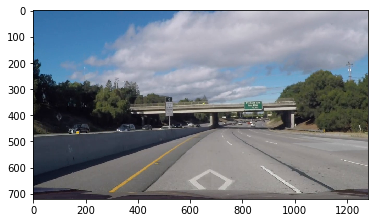

In [115]:
# ------------- DEBUGGING -------------
# This cell is used for debugging only
# Extract frame of interest from video by index
import moviepy.editor as mpy
clip = mpy.VideoFileClip('challenge_video.mp4')
fps = 25
frame_index = 38
frame_sec = frame_index/fps
check_img = clip.get_frame(frame_sec)
# check_img = clip.get_frame(40)
plt.imshow(check_img)

### Challenge Video

In [36]:
line_class = Line()

output_file = 'output_images/challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4").subclip(0,5)
# clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_file, audio=False)

Sliding Window...
Distance between 2 lanes:  511
[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4



  0%|          | 0/150 [00:00<?, ?it/s]

Sliding Window...
Distance between 2 lanes:  511



  1%|▏         | 2/150 [00:00<00:30,  4.90it/s]

in search_around_poly... 574.160643683
......smoothing......



  2%|▏         | 3/150 [00:00<00:29,  4.93it/s]

in search_around_poly... 571.616375248
in search_around_poly... 571.342267388



  3%|▎         | 5/150 [00:01<00:29,  4.96it/s]

in search_around_poly... 569.827954071
......smoothing......
in search_around_poly...


  4%|▍         | 6/150 [00:01<00:28,  4.98it/s]

 561.152427188
in search_around_poly... 559.336600874



  5%|▌         | 8/150 [00:01<00:28,  5.00it/s]

in search_around_poly... 566.973799159
......smoothing......



  6%|▌         | 9/150 [00:01<00:28,  5.00it/s]

in search_around_poly... 567.781566024
in search_around_poly... 572.454027434



  7%|▋         | 11/150 [00:02<00:27,  5.08it/s]

in search_around_poly... 574.136289257
......smoothing......
in search_around_poly... 574.054561197



  9%|▊         | 13/150 [00:02<00:26,  5.13it/s]

in search_around_poly... 574.224595929
in search_around_poly... 573.004510054
......smoothing......



 10%|█         | 15/150 [00:02<00:26,  5.12it/s]

in search_around_poly... 577.89559797
in search_around_poly... 589.038874569



 11%|█▏        | 17/150 [00:03<00:25,  5.19it/s]

in search_around_poly... 588.381781639
......smoothing......
in search_around_poly... 581.382734217



 13%|█▎        | 19/150 [00:03<00:25,  5.17it/s]

in search_around_poly... 579.039579412
in search_around_poly... 576.934917266
......smoothing......



 14%|█▍        | 21/150 [00:04<00:25,  5.08it/s]

in search_around_poly... 589.534051884
in search_around_poly... 589.927090457



 15%|█▌        | 23/150 [00:04<00:24,  5.08it/s]

in search_around_poly... 600.434817263
...Bad Frame...
in search_around_poly... 600.399029115
...Bad Frame...



 17%|█▋        | 25/150 [00:04<00:24,  5.07it/s]

in search_around_poly... 603.334564649
...Bad Frame...
in search_around_poly... 607.920524353
...Bad Frame...



 18%|█▊        | 27/150 [00:05<00:24,  5.07it/s]

in search_around_poly... 604.066716544
...Bad Frame...
Sliding Window...
Distance between 2 lanes:  493
......smoothing......



 19%|█▉        | 29/150 [00:05<00:23,  5.11it/s]

Sliding Window...
Distance between 2 lanes:  503



 20%|██        | 30/150 [00:05<00:23,  5.04it/s]

in search_around_poly... 572.333100743
...Bad Frame...
in search_around_poly... 547.06586015
...Bad Frame...



 21%|██▏       | 32/150 [00:06<00:23,  5.07it/s]

in search_around_poly... 543.030212715
...Bad Frame...
in search_around_poly... 534.812458468
...Bad Frame...



 23%|██▎       | 34/150 [00:06<00:22,  5.12it/s]

in search_around_poly... 539.778477663
...Bad Frame...
Sliding Window...
Distance between 2 lanes:  484



 24%|██▍       | 36/150 [00:07<00:22,  5.12it/s]

Sliding Window...
Distance between 2 lanes:  481
......smoothing......
Sliding Window...
Distance between 2 lanes:  477



 25%|██▌       | 38/150 [00:07<00:21,  5.13it/s]

in search_around_poly... 674.98847535
...Bad Frame...
in search_around_poly... 604.657383693
...Bad Frame...



 27%|██▋       | 40/150 [00:07<00:21,  5.18it/s]

in search_around_poly... 649.297248427
...Bad Frame...
in search_around_poly... 607.839389517
...Bad Frame...



 28%|██▊       | 42/150 [00:08<00:20,  5.17it/s]

in search_around_poly... 559.719293622
...Bad Frame...
Sliding Window...
Distance between 2 lanes:  530



 29%|██▉       | 44/150 [00:09<00:30,  3.48it/s]

Sliding Window...
Distance between 2 lanes:  527
......smoothing......



 30%|███       | 45/150 [00:09<00:28,  3.68it/s]

in search_around_poly... 553.616287662
...Bad Frame...



 31%|███       | 46/150 [00:09<00:27,  3.79it/s]

in search_around_poly... 550.058981628



 31%|███▏      | 47/150 [00:09<00:28,  3.58it/s]

in search_around_poly... 547.419324645



 32%|███▏      | 48/150 [00:10<00:27,  3.67it/s]

in search_around_poly... 549.113025427
......smoothing......



 33%|███▎      | 49/150 [00:10<00:26,  3.76it/s]

in search_around_poly... 545.967302641



 33%|███▎      | 50/150 [00:10<00:27,  3.57it/s]

in search_around_poly... 498.032120534
...Bad Frame...



 34%|███▍      | 51/150 [00:10<00:27,  3.67it/s]

in search_around_poly... 537.225415512



 35%|███▍      | 52/150 [00:11<00:26,  3.74it/s]

in search_around_poly... 567.568766581
......smoothing......



 35%|███▌      | 53/150 [00:11<00:27,  3.56it/s]

in search_around_poly... 565.38880507
...Bad Frame...



 36%|███▌      | 54/150 [00:11<00:26,  3.64it/s]

in search_around_poly... 589.907682412
...Bad Frame...



 37%|███▋      | 55/150 [00:12<00:25,  3.72it/s]

in search_around_poly... 542.109864909



 37%|███▋      | 56/150 [00:12<00:26,  3.52it/s]

in search_around_poly... 544.015276652



 38%|███▊      | 57/150 [00:12<00:25,  3.59it/s]

in search_around_poly... 556.490257573
...Bad Frame...



 39%|███▊      | 58/150 [00:12<00:24,  3.68it/s]

Sliding Window...
Distance between 2 lanes:  519
......smoothing......



 39%|███▉      | 59/150 [00:13<00:25,  3.51it/s]

in search_around_poly... 531.596400823



 40%|████      | 60/150 [00:13<00:24,  3.60it/s]

in search_around_poly... 534.982221394
...Bad Frame...



 41%|████      | 61/150 [00:13<00:24,  3.67it/s]

in search_around_poly... 537.748046002



 41%|████▏     | 62/150 [00:14<00:25,  3.52it/s]

in search_around_poly... 539.995718858
......smoothing......



 42%|████▏     | 63/150 [00:14<00:23,  3.63it/s]

in search_around_poly... 544.242003602



 43%|████▎     | 64/150 [00:14<00:23,  3.71it/s]

in search_around_poly... 583.626324652



 43%|████▎     | 65/150 [00:14<00:24,  3.53it/s]

in search_around_poly... 606.575974224
......smoothing......



 44%|████▍     | 66/150 [00:15<00:23,  3.60it/s]

in search_around_poly... 644.579268447
...Bad Frame...



 45%|████▍     | 67/150 [00:15<00:22,  3.65it/s]

in search_around_poly... 674.667215068
...Bad Frame...



 45%|████▌     | 68/150 [00:15<00:23,  3.45it/s]

in search_around_poly... 653.176779247
...Bad Frame...



 46%|████▌     | 69/150 [00:15<00:22,  3.54it/s]

in search_around_poly... 653.46308268
...Bad Frame...



 47%|████▋     | 70/150 [00:16<00:22,  3.61it/s]

Sliding Window...
Distance between 2 lanes:  518



 47%|████▋     | 71/150 [00:16<00:23,  3.42it/s]

Sliding Window...
Distance between 2 lanes:  521



 48%|████▊     | 72/150 [00:16<00:22,  3.53it/s]

Sliding Window...
Distance between 2 lanes:  515
......smoothing......



 49%|████▊     | 73/150 [00:17<00:21,  3.63it/s]

in search_around_poly... 532.045137152
...Bad Frame...



 49%|████▉     | 74/150 [00:17<00:21,  3.48it/s]

in search_around_poly... 527.736628758



 50%|█████     | 75/150 [00:17<00:21,  3.57it/s]

in search_around_poly... 526.635155536



 51%|█████     | 76/150 [00:17<00:20,  3.66it/s]

in search_around_poly... 524.177048289
......smoothing......



 51%|█████▏    | 77/150 [00:18<00:20,  3.50it/s]

in search_around_poly... 517.220339646
...Bad Frame...



 52%|█████▏    | 78/150 [00:18<00:20,  3.59it/s]

in search_around_poly... 506.454228291
...Bad Frame...



 53%|█████▎    | 79/150 [00:18<00:19,  3.68it/s]

in search_around_poly... 511.126408577
...Bad Frame...



 53%|█████▎    | 80/150 [00:19<00:19,  3.60it/s]

in search_around_poly... 509.515585145
...Bad Frame...



 54%|█████▍    | 81/150 [00:19<00:19,  3.62it/s]

Sliding Window...
Distance between 2 lanes:  537



 55%|█████▍    | 82/150 [00:19<00:18,  3.65it/s]

Sliding Window...
Distance between 2 lanes:  536



 55%|█████▌    | 83/150 [00:19<00:18,  3.54it/s]

Sliding Window...
Distance between 2 lanes:  533
......smoothing......



 56%|█████▌    | 84/150 [00:20<00:18,  3.59it/s]

in search_around_poly... 496.166787795



 57%|█████▋    | 85/150 [00:20<00:17,  3.67it/s]

in search_around_poly... 503.804841399



 57%|█████▋    | 86/150 [00:20<00:18,  3.47it/s]

in search_around_poly... 516.427251274
......smoothing......



 58%|█████▊    | 87/150 [00:20<00:17,  3.56it/s]

in search_around_poly... 509.446060987



 59%|█████▊    | 88/150 [00:21<00:17,  3.63it/s]

in search_around_poly... 511.042651514



 59%|█████▉    | 89/150 [00:21<00:17,  3.43it/s]

in search_around_poly... 525.251003303
......smoothing......



 60%|██████    | 90/150 [00:21<00:17,  3.50it/s]

in search_around_poly... 518.635165047



 61%|██████    | 91/150 [00:22<00:16,  3.60it/s]

in search_around_poly... 495.959128531
...Bad Frame...



 61%|██████▏   | 92/150 [00:22<00:16,  3.53it/s]

in search_around_poly... 343.432676772
...Bad Frame...



 62%|██████▏   | 93/150 [00:22<00:16,  3.45it/s]

in search_around_poly... 385.413530347
...Bad Frame...



 63%|██████▎   | 94/150 [00:22<00:15,  3.54it/s]

in search_around_poly... 407.486440155
...Bad Frame...



 63%|██████▎   | 95/150 [00:23<00:15,  3.60it/s]

in search_around_poly... 532.577312807
...Bad Frame...



 64%|██████▍   | 96/150 [00:23<00:15,  3.46it/s]

Sliding Window...
Distance between 2 lanes:  550



 65%|██████▍   | 97/150 [00:23<00:14,  3.55it/s]

Sliding Window...
Distance between 2 lanes:  535
......smoothing......



 65%|██████▌   | 98/150 [00:24<00:14,  3.62it/s]

in search_around_poly... 526.716224119
...Bad Frame...



 66%|██████▌   | 99/150 [00:24<00:14,  3.48it/s]

in search_around_poly... 522.382510264
...Bad Frame...



 67%|██████▋   | 100/150 [00:24<00:14,  3.55it/s]

in search_around_poly... 517.800251263
...Bad Frame...



 67%|██████▋   | 101/150 [00:24<00:13,  3.61it/s]

in search_around_poly... 520.28497251
...Bad Frame...



 68%|██████▊   | 102/150 [00:25<00:13,  3.55it/s]

in search_around_poly... 522.23501784
...Bad Frame...



 69%|██████▊   | 103/150 [00:25<00:13,  3.45it/s]

Sliding Window...
Distance between 2 lanes:  504



 69%|██████▉   | 104/150 [00:25<00:12,  3.55it/s]

in search_around_poly... 523.126015398
...Bad Frame...



 70%|███████   | 105/150 [00:26<00:12,  3.51it/s]

in search_around_poly... 527.050329579
...Bad Frame...



 71%|███████   | 106/150 [00:26<00:12,  3.47it/s]

in search_around_poly... 524.413046536
...Bad Frame...



 71%|███████▏  | 107/150 [00:26<00:12,  3.37it/s]

in search_around_poly... 530.769153139
...Bad Frame...



 72%|███████▏  | 108/150 [00:26<00:11,  3.50it/s]

in search_around_poly... 527.715825997
...Bad Frame...



 73%|███████▎  | 109/150 [00:27<00:11,  3.42it/s]

Sliding Window...
Distance between 2 lanes:  520



 73%|███████▎  | 110/150 [00:27<00:11,  3.52it/s]

Sliding Window...
Distance between 2 lanes:  522
......smoothing......



 74%|███████▍  | 111/150 [00:27<00:11,  3.44it/s]

in search_around_poly... 529.52535879



 75%|███████▍  | 112/150 [00:28<00:10,  3.53it/s]

in search_around_poly... 522.871679733



 75%|███████▌  | 113/150 [00:28<00:10,  3.59it/s]

in search_around_poly... 526.436759199
......smoothing......



 76%|███████▌  | 114/150 [00:28<00:10,  3.49it/s]

in search_around_poly... 529.9940346



 77%|███████▋  | 115/150 [00:28<00:09,  3.53it/s]

in search_around_poly... 531.503990815



 77%|███████▋  | 116/150 [00:29<00:09,  3.56it/s]

in search_around_poly... 534.219889177
......smoothing......



 78%|███████▊  | 117/150 [00:29<00:09,  3.55it/s]

in search_around_poly... 532.434962833



 79%|███████▊  | 118/150 [00:29<00:09,  3.55it/s]

in search_around_poly... 531.968339404



 79%|███████▉  | 119/150 [00:30<00:08,  3.58it/s]

in search_around_poly... 526.507717216
...Bad Frame...



 80%|████████  | 120/150 [00:30<00:08,  3.59it/s]

in search_around_poly... 521.040282145
...Bad Frame...



 81%|████████  | 121/150 [00:30<00:08,  3.58it/s]

in search_around_poly... 576.842248074
...Bad Frame...



 81%|████████▏ | 122/150 [00:30<00:07,  3.61it/s]

in search_around_poly... 570.932577346
...Bad Frame...



 82%|████████▏ | 123/150 [00:31<00:07,  3.61it/s]

in search_around_poly... 557.755177444
...Bad Frame...



 83%|████████▎ | 124/150 [00:31<00:07,  3.50it/s]

Sliding Window...
Distance between 2 lanes:  507
......smoothing......



 83%|████████▎ | 125/150 [00:31<00:06,  3.58it/s]

Sliding Window...
Distance between 2 lanes:  508



 84%|████████▍ | 126/150 [00:32<00:06,  3.56it/s]

Sliding Window...
Distance between 2 lanes:  524



 85%|████████▍ | 127/150 [00:32<00:06,  3.58it/s]

Sliding Window...
Distance between 2 lanes:  521
......smoothing......



 85%|████████▌ | 128/150 [00:32<00:06,  3.59it/s]

Sliding Window...
Distance between 2 lanes:  523



 86%|████████▌ | 129/150 [00:32<00:05,  3.53it/s]

Sliding Window...
Distance between 2 lanes:  528



 87%|████████▋ | 130/150 [00:33<00:05,  3.65it/s]

Sliding Window...
Distance between 2 lanes:  532
......smoothing......



 87%|████████▋ | 131/150 [00:33<00:05,  3.59it/s]

Sliding Window...
Distance between 2 lanes:  514



 88%|████████▊ | 132/150 [00:33<00:05,  3.50it/s]

Sliding Window...
Distance between 2 lanes:  520



 89%|████████▊ | 133/150 [00:33<00:04,  3.61it/s]

Sliding Window...
Distance between 2 lanes:  529
......smoothing......



 89%|████████▉ | 134/150 [00:34<00:04,  3.61it/s]

Sliding Window...
Distance between 2 lanes:  640
Error in finding lane pixels...



 90%|█████████ | 135/150 [00:34<00:04,  3.62it/s]

Sliding Window...
Distance between 2 lanes:  640
Error in finding lane pixels...



 91%|█████████ | 136/150 [00:34<00:03,  3.59it/s]

Sliding Window...
Distance between 2 lanes:  640
Error in finding lane pixels...



 91%|█████████▏| 137/150 [00:35<00:03,  3.68it/s]

Sliding Window...
Distance between 2 lanes:  640
Error in finding lane pixels...



 92%|█████████▏| 138/150 [00:35<00:03,  3.66it/s]

Sliding Window...
Distance between 2 lanes:  971
Error in finding lane pixels...



 93%|█████████▎| 139/150 [00:35<00:03,  3.62it/s]

Sliding Window...
Distance between 2 lanes:  449



 93%|█████████▎| 140/150 [00:35<00:02,  3.60it/s]

Sliding Window...
Distance between 2 lanes:  458



 94%|█████████▍| 141/150 [00:36<00:02,  3.50it/s]

Sliding Window...
Distance between 2 lanes:  438
......smoothing......



 95%|█████████▍| 142/150 [00:36<00:02,  3.60it/s]

Sliding Window...
Distance between 2 lanes:  438



 95%|█████████▌| 143/150 [00:36<00:01,  3.55it/s]

Sliding Window...
Distance between 2 lanes:  436



 96%|█████████▌| 144/150 [00:37<00:01,  3.55it/s]

Sliding Window...
Distance between 2 lanes:  444
......smoothing......



 97%|█████████▋| 145/150 [00:37<00:01,  3.54it/s]

in search_around_poly... 500.958510407



 97%|█████████▋| 146/150 [00:37<00:01,  3.51it/s]

in search_around_poly... 564.304070202



 98%|█████████▊| 147/150 [00:37<00:00,  3.48it/s]

in search_around_poly... 630.391005025
......smoothing......



 99%|█████████▊| 148/150 [00:38<00:00,  3.41it/s]

in search_around_poly... 525.307772909



 99%|█████████▉| 149/150 [00:38<00:00,  3.48it/s]

in search_around_poly... 544.844184498



100%|██████████| 150/150 [00:38<00:00,  3.37it/s]

in search_around_poly... 511.170045047
......smoothing......


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 23.7 s, sys: 2.23 s, total: 25.9 s
Wall time: 42.3 s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

### Harder Challenge Video

In [ ]:
line_class = Line()

output_file = 'output_images/harder_challenge_video.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_file, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))